In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
import pickle
from matplotlib.ticker import PercentFormatter
import pandas as pd
import seaborn as sns

In [37]:
def logistic_regression(x, y):
    try:
        X = np.transpose([np.ones(len(x)), x])
        model_fit = sm.Logit(y,X).fit(maxiter=50)
        coeff = 1 if model_fit.params[1] > 0 else -1
        return (model_fit.prsquared, coeff, model_fit)
    except np.linalg.LinAlgError:
        return (0, 0, None)
    except sm.tools.sm_exceptions.PerfectSeparationError:
        coeff = 1 if max(x[np.array(y, dtype=bool)]) == max(x) else -1 
        return (1, coeff, None) # Data is linearly separable

def sample_trials(alevel_idxs, n_samples):
    trial_per_alevel = 500
    trials_offset = 200 # Only consider the second half of the alevel
    
    trials_to_sample = []
    for n_bin in alevel_idxs:
        trial_s = n_bin * trial_per_alevel + trials_offset
        trial_t = (n_bin + 1) * trial_per_alevel
        trials_to_sample = trials_to_sample + list(range(trial_s, trial_t))
        
    if n_samples == "all": 
        return np.array(trials_to_sample)
    else:
        return np.array(random.sample(trials_to_sample, n_samples))

In [38]:
def get_data(data_dir):
    N_PFC_NEURONS = 500
    N_MD_NEURONS = 2
    N_OUTPUT_NEURONS = 2
    TRIAL_TIME = 200

    s_trial = 0
    t_trial = 4000
    n_trials = t_trial - s_trial

    rPFC_trials = np.zeros((n_trials, TRIAL_TIME, N_PFC_NEURONS))
    inpMD_trials = np.zeros((n_trials, TRIAL_TIME, N_MD_NEURONS))
    rMD_trials = np.zeros((n_trials, TRIAL_TIME, N_MD_NEURONS))
    rOutput_trials = np.zeros((n_trials, TRIAL_TIME, N_OUTPUT_NEURONS))
    task_input = np.zeros((2, n_trials))
    v1v2_values = np.zeros((2, n_trials))
    wPFC_output = np.zeros((n_trials, N_OUTPUT_NEURONS, N_PFC_NEURONS))

    for i in range(s_trial, t_trial):
        with open(data_dir + "/" + str(i) + ".json") as json_file:
            data = json.load(json_file)
            idx = i - s_trial

            rPFC = np.array(data["network_rates"]["r_PFC"])
            rPFC_trials[idx,:,:] = rPFC
            inpMD = np.array(data["network_rates"]["MD_input"])
            inpMD_trials[idx,:,:] = inpMD
            rMD = np.array(data["network_rates"]["r_MD"])
            rMD_trials[idx,:,:] = rMD
            rOutput = np.array(data["network_rates"]["r_output"])
            rOutput_trials[idx,:,:] = rOutput

            trial_task_input = np.array(data["trial_data"]["input"])
            task_input[:,idx] = trial_task_input[:2]
            v1v2_values[:,idx] = trial_task_input[2:4]
            
            wPFC_output[idx,:,:] = np.array(data["network_weights"]["w_outputs"])

    return (rPFC_trials, task_input, v1v2_values, wPFC_output, inpMD_trials, rMD_trials, rOutput_trials)

def get_trials(v1v2_values, starts_with_90):
    TRIAL_SAMPLE_SIZE = "all"
    N_PFC_NEURONS = 500
    
    if starts_with_90:
        alevel_90_idxs = [0,2,4,6]
        alevel_10_idxs = [1,3,5,7]
    else:
        alevel_10_idxs = [0,2,4,6]
        alevel_90_idxs = [1,3,5,7]

    # Randomly sample trials for analysis from the second half of each alevel
    # We ensure all alevels are equally represented

    alevel_90_trials = sample_trials(alevel_90_idxs, TRIAL_SAMPLE_SIZE)
    alevel_10_trials = sample_trials(alevel_10_idxs, TRIAL_SAMPLE_SIZE)
    match_trials = alevel_90_trials
    nonmatch_trials = alevel_10_trials
    trials = np.concatenate((match_trials, nonmatch_trials))
    
    return (match_trials, nonmatch_trials, trials)

def score_cue_like(rPFC_trials, task_input, match_trials, nonmatch_trials):
    N_PFC_NEURONS = 500
    N_MD_NEURONS = 2
    N_OUTPUT_NEURONS = 2
    TRIAL_TIME = 250
    
    CUE_TIME = 100
    
    cuetime_s = 50 #math.floor(CUE_TIME - (CUE_TIME / 2))
    cuetime_t = 150 #CUE_TIME

    # NOTE: Testing outcome period, not cue
#     cuetime_s = 150
#     cuetime_t = 200
    
    cue_match = task_input[0, match_trials]
    cue_nonmatch = task_input[0, nonmatch_trials]
    
    rsquareds = np.empty((N_PFC_NEURONS, 2))
    rsquareds[:] = np.nan
    betas = np.empty((N_PFC_NEURONS, 2))
    rsquareds[:] = np.nan
    
    for neuron_idx in range(0,N_PFC_NEURONS): 
        fr_match = np.mean(rPFC_trials[match_trials, cuetime_s:cuetime_t, neuron_idx],1)
        fr_nonmatch = np.mean(rPFC_trials[nonmatch_trials, cuetime_s:cuetime_t, neuron_idx],1)
        
        (r2_match, b_match, model_fit_match) = logistic_regression(fr_match, cue_match)
        (r2_nonmatch, b_nonmatch, model_fit_nonmatch) = logistic_regression(fr_nonmatch, cue_nonmatch)
    
        r2_match = 0 if r2_match < 0 else r2_match
        r2_nonmatch = 0 if r2_nonmatch < 0 else r2_nonmatch
            
        rsquareds[neuron_idx,:] = [r2_match, r2_nonmatch]
        betas[neuron_idx,:] = [b_match, b_nonmatch]
        
    return (rsquareds, betas)

In [39]:
def save_obj(name, obj):
    with open('/om2/group/halassa/PFCMD-ali-sabrina/many_seeds/'+ name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('/om2/group/halassa/PFCMD-ali-sabrina/many_seeds/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    

In [18]:
# RUNS_MD = ["seed0_MDon", "seed42_MDon", "seed778_MDon", "seed88_MDon", "seed127_MDon", "seed12_MDon_10", "seed312_MDon_10", "seed400_MDon_10", "seed177_MDon_10", "seed83_MDon_10"]
# RUNS_MD_NO = ["seed0_MDoff", "seed42_MDoff", "seed778_MDoff", "seed88_MDon", "seed127_MDoff", "seed12_MDoff_10", "seed312_MDoff_10", "seed400_MDoff_10", "seed177_MDoff_10", "seed83_MDon_10"]

# for i in range(len(RUNS_MD)):
#     print("Running " + str(i) + "/" + str(len(RUNS_MD)) + "...")
#     data_MDon = get_data("/om2/group/halassa/PFCMD-ali-sabrina/" + RUNS_MD[i] + "/by_trial")
#     data_MDoff = get_data("/om2/group/halassa/PFCMD-ali-sabrina/" + RUNS_MD_NO[i] + "/by_trial")
#     save_obj(RUNS_MD[i], data_MDon)
#     save_obj(RUNS_MD_NO[i], data_MDoff)

Running 0/10...
Running 1/10...
Running 2/10...
Running 3/10...
Running 4/10...
Running 5/10...
Running 6/10...
Running 7/10...
Running 8/10...
Running 9/10...


In [40]:
RUNS_MD = ["seed0_MDon", "seed42_MDon", "seed778_MDon", "seed88_MDon", "seed127_MDon", "seed12_MDon_10", "seed312_MDon_10", "seed400_MDon_10", "seed177_MDon_10", "seed83_MDon_10"]
RUNS_MD_NO = ["seed0_MDoff", "seed42_MDoff", "seed778_MDoff", "seed88_MDon", "seed127_MDoff", "seed12_MDoff_10", "seed312_MDoff_10", "seed400_MDoff_10", "seed177_MDoff_10", "seed83_MDon_10"]


scores = []
scores_noMD = []
b = []
b_noMD = []

for i in range(len(RUNS_MD)):
    starts_with_90 = i < 5
    
    (rPFC_trials, task_input, v1v2_values, wPFC_output, _, _, _) = load_obj(RUNS_MD[i])
    (match_trials, nonmatch_trials, trials) = get_trials(v1v2_values, starts_with_90)
    (scores_, b_) = score_cue_like(rPFC_trials, task_input, match_trials, nonmatch_trials)
        
    (rPFC_trials_noMD, task_input_noMD, v1v2_values_noMD, wPFC_output_noMD, _, _, _) = load_obj(RUNS_MD_NO[i])
    (match_trials_noMD, nonmatch_trials_noMD, trials_noMD) = get_trials(v1v2_values_noMD, starts_with_90)
    (scores_noMD_, b_noMD_) = score_cue_like(rPFC_trials_noMD, task_input_noMD, match_trials_noMD, nonmatch_trials_noMD)
    
    if i == 0:
        scores = scores_
        scores_noMD = scores_noMD_
        b = b_
        b_noMD = b_noMD_
    else:
        scores = np.concatenate((scores, scores_), axis=0)
        b = np.concatenate((b, b_), axis=0)
        scores_noMD = np.concatenate((scores_noMD, scores_noMD_), axis=0)
        b_noMD = np.concatenate((b_noMD, b_noMD_), axis=0)

Optimization terminated successfully.
         Current function value: 0.066833
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.219671
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.450158
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.610439
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.204929
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677048
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.178163
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.539230
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.575777
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.177291
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.670231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.191898
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.592730
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.239664
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.049615
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.660318
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692439
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.054286


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.233168
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.152167
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.004170
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.022539
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.006474
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.692157
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.157736
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.478026
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692651
         Iterations 3
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.655587
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.151210
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.158511
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.101151
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.533739
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.091582
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.027706
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.310581
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.129129
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.684715

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.150557
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.067586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.111406
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.173797
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.199710
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.639977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.120723
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.190729
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.253875
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.212377
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.664577
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.062206
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.020678
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.223288
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.532844
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.162493
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.686824
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692559
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.169698
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.144979
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479591
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.116582
         Iterations 9
         Current function value: 0.000006
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.003369
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685445
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468026
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685870
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.432963
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639862
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.066930
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.330834
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685700
         Iterations 6
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.093276
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.003337
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.685618
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.126838
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.213201
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.115179
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093608
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.100345
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.296140
         Iterations 11
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.072595
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.112463
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.443909
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.558445
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.201008
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.638718
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.619996
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.290454
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.130772
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.086145
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.067691
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.652995
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.032520
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063685
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.489197
         Iterations 6
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.318886
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.031483
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.418332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.167794
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.140197
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.137195
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.174479
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.039953
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.009569
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.683359

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.167663
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.047315
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.350509
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692934
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.020537
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.042960
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.681991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.081267
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.079975
         Iterations 11
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.361291
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.078250
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.611870
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.123356
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.049125
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.059249
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.005725
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.028608
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.203110
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.0548

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.018993
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.660111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.181868
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.416499
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.023831
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.387358
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.150914
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.069830
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.089935
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.124023
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692222
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.054586
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.526617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.128151
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.505379
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.673713
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.068651
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.360414
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.039886
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.150825
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.570904
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392807
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.525123
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.140243
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.565352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411808
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.106971
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.137038
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.673530
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.436202
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.678783
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680152
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.062434
         Iterations 10
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.006891
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.002945
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.004857
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.060170
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.146740
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.070417
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.059831
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.516938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.003387
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.682

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.454395
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.091050
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.461345
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.011396
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.302907
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.354003
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.309534
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.673692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.535861
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.146908
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.568959
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.040333
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.530088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.013457
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.018690
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.304043
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.191400
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.074128
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.037080

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.124119
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.206435
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.061585
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.317850
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.075503
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.494806
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.019660
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.147994
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.32930

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.529037
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.201778
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.083977
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.636599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600604
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.117451
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.182275
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.681624
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.211319
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.136181


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.039277
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.148809
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.402901
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351482
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.564903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692067
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.107651
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.070253
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.134402
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.041479
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037183
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.121425
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378291
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.015979
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.179274
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.220939
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.242923
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.279294
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.059078
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.049353
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.593423
         Iterations 23
Optimization terminated successfully.
         Current function value: 0.085830
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688033
         Iterations 7
Optimization terminated successfully.
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.098216
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.096139
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.216048
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.170065
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.596284
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.120895
         Iterations 9
         Current function value: 0.000016
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.091022
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.001626
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.004299
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.499219
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.112705
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.071567
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.001856
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.179714
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.029831
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.091332
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.143409
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363540
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.077412
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.119003
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.411182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.283563
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.535695
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.134676
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.692119
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014593
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.039951
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.683796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589769
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.201504
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.614273
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.656238
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.679667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.620138
         Iterations 6
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.147237
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357398
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.358830
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.675560
         Iterations 5
         Current function value: 0.683836
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693012
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.454954
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.233917
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.283940
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.071568
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.691863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684647
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.437568
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683626
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.219042
         Iterations 9
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.052514
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.113313
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.024960
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.063940
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.591472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.060367
         Iterations 15
         Current function value: 0.690668
         Iterations: 50
         Current function value: 0.684670
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027502
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.686855
         Iterations 6
Optimization terminated successfully.
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.129663
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.283921
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.568763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.226158
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.035755
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.630155
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.477331
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.683837
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.210036
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.237350
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.117254
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.032385
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.068815
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.067221
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.688967
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470731
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37910

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662763
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038331
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691617
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.016554
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030605
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.494673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.576656
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017370
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.193467
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.007260
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.046159
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.301100
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.539642
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.491739
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092655
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.240929
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.625584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558328
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.031361
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.302120
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.359346
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663402
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.254798
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664821
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076115
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.142247
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.361838
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.185654
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.030302
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.013962
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107615
         Iterations 10
Optimization terminated successf

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.222858
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.019538
         Iterations 12
         Current function value: 0.687254
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.061049
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.626600
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.278779
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.543152
         Iterations 7
         Current function value: 0.000005
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130288
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.277073
         Iterations 9
         Current function value: 0.000000
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.119316
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.134824
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.140270
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.030110
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.146846
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.313804
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087255
         Iterations 10
         Current function value: 11.721036
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.002077
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.675111
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.028991
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.217273
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.035189
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.572588
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.554275
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.212693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.060084
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.079958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.653013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.002925
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.170122
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.032622
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.157796
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.681556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.004705
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.003475
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.035679
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.002849
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.053869
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.688146
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.065067
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.491013
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.018085
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.052650
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.11

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.285616
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.460817
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029830
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.686668
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092183
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.008932
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.125085
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066832
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.147345
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.325672
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.451348
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.007490
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020690
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.002007
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.332433
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015186
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.081632
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.026941
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.150215
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.673635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.015283
         Iterations 17
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.154155
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.371018
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.216367
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.085244
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.679632
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.352810
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.024039
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.652691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693001
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.305124
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.008987
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.145713
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022117
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.399378
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.133452
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.509471
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393359
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682990
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003926
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.001800
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.682139
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.376627
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.408196
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.081347
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.166189
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.005758
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.011953
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017856
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.002934
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.009631
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.021527
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.689302
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.022352
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.004170
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.638429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.028240
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.295223
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.128819
         Iterations 9
         Current function value: 0.002628
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.750452
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.467471
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.296721
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010257
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.239719
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.048196
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.213349
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.025568
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.023968
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.054885
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691953
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.028623
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.029904
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.018297
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.003181
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.022195
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.091507
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.110564
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.647815
         Iterations 7
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.138102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.017457
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.055110
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.289356
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388557
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.502932
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005005
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.365273
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008319
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.010414
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.114007
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.677297
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693009
         Iterations 3
Optimization terminated successfully.
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.357533
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.065836
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.685064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.088215
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.300776
         Iterations 7
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.219318
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016571
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031532
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.014061
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.294185
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.526053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.006826
         Iterations 14
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.061698
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.314993
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.287277
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416961
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.016498
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.058785
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.671641
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.140174
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.642535
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014364
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.036456
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.260515
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.114807
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.139412
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.694130
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.590335
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011736
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015505
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.320114
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.674691
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.509812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678673
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.479366
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.019607
         Iterations 12
Optimization terminated successfully

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.407274
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.216977
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.564898
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.574060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.547389
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.650629
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692725
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692975
         Iterations 3
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.313537
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.040251
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.453820
         Iterations 24
Optimization terminated successfully.
         Current function value: 0.021269
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.602852
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.155055
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.110860
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.432039
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.188116
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.050030
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.238792
         Iterations 8
         Current function value: 0.000000
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.640528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.088011
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.610022
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.005918
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.043809
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.087980
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.003945
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.079342
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.267540
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.011092
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690555
         Iterations 4
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.269504
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.002336
         Iterations 15
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.069884
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.540675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016096
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.272942
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.635124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.175295
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.130388
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012555
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.686942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.006358
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.138346
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.622145
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.656981
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.028186
         Iterations 11
Optimization terminated successfully.
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.677948
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.130151
         Iterations 9
         Current function value: 0.000016
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006752
         Iterations 17


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.281716
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.439976
         Iterations 7
         Current function value: 0.000005
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.425541
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014420
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020639
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.616684
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685627
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.578496
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017221
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.181330
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.006864
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.021806
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.197070
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013885
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.001527
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.454526
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.161824
         Iterations 8
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.700522
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094693
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.005436
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.493487
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.608704
         Iterations 6
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017315
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.023440
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.124908
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.319331
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.015816
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.177093
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.209751
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.618102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460217
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026065
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.592033
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.018272
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.110358
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.099166
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000020
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030048
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.302650
         Iterations 8
Optimization terminate

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.039318
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.093098
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.658206
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.003040
         Iterations 17
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019204
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.398600
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.258925
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.158617
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.042397
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.227487
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005207
         Iterations 20
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.549557
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062563
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.176852
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.359778
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033956
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.663303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.144955
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.233770
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.327197
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.472394
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.538312
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.518225
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.105687
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000604
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008974
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.039304
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.510767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.662172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.012754
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.001617
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.061393
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.579436
         Iterations 6
         Current function value: 0.000008
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013977
         Iterations 13
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.441876
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010239
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004325
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.505240
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.108380
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076827
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.340780
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.008404


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.362673
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.226653
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.646906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.420277
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.072815
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.019058
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.100811
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684949
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.005766
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.645335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.037499
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.683697
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.593681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.004080
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.235702
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689736
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.648957
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.029146
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.065718
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.653204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.209920
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.630570
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.035193
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017159
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.678859
         Iterations 5
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.482372
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.006569
         Iterations 14
         Current function value: 0.000000
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683052
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.037602
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.604920
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.015834
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.001244
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692303
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.181854
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.251743
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.287469
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.287126
         Iterations 7
         Current function value: 0.689251
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678976
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.216075
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.009648
         Iterations 15
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006321
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.530681
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.019605
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000139
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096225
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.003257
         Iterations 18
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006861
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.434604
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.269643
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690956
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680712
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.155563
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.156711
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.228977
         Iterations 8
         Current function value: 0.780673
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044672
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.029835
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146336
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691630
         Iterations 6
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.634862
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681453
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.084670
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.516795
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.031961
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.146187
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.056651
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.118363
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.460206
         Iterations 7
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.651571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.001347
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.145351
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.651734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.003273
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686148
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.199564
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.183433
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.235239
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.090036
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059109
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.619987
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.096

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018151
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.209220
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692784
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.005765
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009473
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.663715
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687292
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.661791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692835
         Iterations 3
         Current function value: 0.003798
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.349263
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.026571
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.197842
         Iterations 9
         Current function value: 0.688919
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016867
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071301
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684980
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.139720
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.004549
         Iterations 15
         Current function value: 0.011134
         Iterations: 50
         Current function value: 0.193133
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.311040
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.687759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.076742
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005804
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.600527
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 21.452051
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.046046
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.216928
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.536301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.022975
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.001819
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.691281
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.167664
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.599472
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.390811
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.164731
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.046917
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673938
         Iterations 5
         Current function value: 0.605651
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005166
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692643
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691231
         Iterations 13
         Current function value: 0.692282
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.506585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.585019
         Iterations 7
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085091
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.548691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.305322
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.677272
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000009
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692260
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.587558
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037708
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.170104
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.675216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.007729
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.690482
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.538754
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.156489
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.060731
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.021554
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.025782
         Iterations 11
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.014274
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069347
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.238383
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.032471
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.028135
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.046801
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.012875
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.448754
         Iterations 7
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.107276
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.460191
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.325409
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.163367
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.001920
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.227683
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.122894
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685732
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.182840
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077119
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.676477
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.463912
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.444665
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.019283
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.075510
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.637105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680123
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.131642
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.351610
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.012998
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.100665
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.441419
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.241946
         Iterations 8
         Current function value: 0.000555
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.171493
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.625874
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151228
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.133087
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.074816
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.364658
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.222011
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.179470
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.386205
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.063872
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.242377
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360809
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.007209
         Iterations 14
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.339715
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.160430
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.219819
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.112361
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.070741
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.423425
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579479
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120917
         Iterations 9
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.181140
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.085866
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.452169
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.086937
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.026838
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.122120
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049845
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.018418
         Iterations 13
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.006630
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.257489
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.020208
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.119152
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.177529
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055623
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.012810
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.124549
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.134412
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.314129
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692163
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.118945
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.137869
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.096948
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.662848
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.267399
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.585992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.039253
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.682658
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004071
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.090263
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691892
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.008401
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.195944
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.165771
         Iterations 7
         Current function value: 0.683859
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.230456
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.137172
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052428
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.346896
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.315430
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333372
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.004189
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665843
         Iterations 7
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.440459
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052477
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.680997
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.228938
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009080
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.677948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651033
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.169206
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.252588
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089350
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.051835
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.157295
         Iterations 10
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.226061
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.020442
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.569178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.013741
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.672240
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.141736
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.043162
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.009763
         Iterations 14
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692152
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.039071
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.303729
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.606870
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.666453
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009837
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.081222
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.024248
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.631880
         Iterations 7
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.031127
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689244
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.387175
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083923
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.633346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.358590
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065350
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.061907
         Iterations 10
         Current function value: 0.000024
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.049138
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.026515
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.689167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.007743
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.688628
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.237742
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.596416
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.263225
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059874
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.006341
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.334246
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.009748
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.302293
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000051
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657026
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.061515
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.182257
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.337300
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.279560
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690639
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692277
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.570832
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.295549
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.528395
         Iterations 7
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.001305
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.107791
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.038376
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.047546
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.069082
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066561
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.687561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.032101
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.403700
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.015779
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.244563
         Iterations 8
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.118572
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.143545
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.124851
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.056870
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.061578
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.014776
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.684487
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079630
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057145
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.274202
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.158721
         Iterations 8
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.014431
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.421471
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004120
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.691878
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.006611
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.172292
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.122084
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.219257
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.418879
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.046178
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.204951
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.170847
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.464554
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.048475
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.022282
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.244917
         Iterations 7
         Current function value: 0.000181
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.273755
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.670962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.155089
         Iterations 9
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.549111
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417540
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.180437
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688464
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007617
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.607404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347848
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.027094
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.433829
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682074
         Iterations 6
Optimization terminated success

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692232
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.638735
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.004979
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.319642
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.386572
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692272
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.210112
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.012058
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025868
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.307986
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.652098
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.676664
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.674410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398093
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.640755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.175097
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.207976
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.544056
         Iterations 6
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.593811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381861
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.388244
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.186350
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.043058
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.007977
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.668327
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006932
         Iterations 13
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049056
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.544479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.001316
         Iterations 24
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055355
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055448
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.027822
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.010076
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.084983
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.040622
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.222072
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.004282
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024352
         Iterations 12
         Current function value: inf
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.375264
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.228179
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.206353
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067471
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.129039
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.141041
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120474
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079302
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657293
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.012525
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.673227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.293210
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.151350
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.077539
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.544734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.067489
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.493393
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.286771
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.060809
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.039384
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.418166
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.229061
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.161589
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.002167
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.539680
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.182894
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.300905

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.168496
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.198317
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.180230
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.574303
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.468513
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393394
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.524870
         Iterations 6
Optimization terminated successfully.
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.065271
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.635792
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.254363
         Iterations 7
         Current function value: 0.832958
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.262325
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284700
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.275689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.530853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016984
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.035488
         Iterations 10
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.419952
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.005805
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.444793
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645360
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072829
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047485
         Iterations 12
Optimization terminated successfully.


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.058357
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.275795
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692089
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087180
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.162359
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.259197
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.530514
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.279986
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.111900
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.130179
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.201833
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013242
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.283039
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.266260
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.226515
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.098427
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.238435
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.064348
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.400841
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.100200
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.689255
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059044
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.386832
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.042104
         Iterations 11
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692279
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.125841
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124258
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.686906
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.148202
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045601
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092855
         Iterations 8
         Current function value: 0.000152
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062084
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.397198
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.047205
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.386274
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048122
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.003069
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.263474
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.002357
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.256293
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009081
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.536668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428012
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.637877
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692120
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058931
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.005344
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.108279
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.117078
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691918
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.034595
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.075112
         Iterations 9
         Current function value: 0.000000
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690216
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.102846
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.681755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.173455
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.019754
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.275263
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.434059
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.145259
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190475
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.452591
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.197889
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.125084
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.011221
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.012317
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.166295
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002466
         Iterations 18
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005261
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011223
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.057524
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.360993
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684908
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.586574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.153044
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.414219
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038396
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.108169
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.069428
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079521
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.034638
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.014949
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000154
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.592892
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057338
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.661090
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.463709
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686746
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.126974
         Iterations 8

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.640956
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042729
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.234271
         Iterations 9
         Current function value: 0.045521
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.204369
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.279743
         Iterations 8
         Current function value: 0.000387
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.174466
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691729
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.216466
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.132970
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067704
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.161569
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.133470
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689253
         Iterations 7
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Optimization terminated successfully.
         Current function value: 0.691171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.018052
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017219
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.210220
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.634701
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064435
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.289957
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.004248
         Iterations 16
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.022806
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.412961
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.485976
         Iterations 7
         Current function value: 0.680722
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.065979
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130375
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683122
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.348940
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.661110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682067
         Iterations 6
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.608197
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.258510
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.009304
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.013763
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.467285
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.670353
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.188762
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.047885
         Iterations 13
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.046430
         Iterations 12
         Current function value: 0.689409
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094440
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.578250
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.262145
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.016101
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.683889
         Iterations 8
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684101
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.673482
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.188213
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.066736
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688967
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.585104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.023449
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.474539
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692107
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.656803
         Iterations 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.111837
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.142736
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.229270
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685290
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405074
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.350903
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.068045
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687982
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.045569
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.004957
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072579
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037390
         Iterations 18


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.101322
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.125317
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692189
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.112850
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.037153
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.558865
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.431787
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688745
         Iterations 6
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.218117
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073491
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.118536
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133955
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.003861
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.100064
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.640322
         Iterations 7
         Current function value: 0.0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.686260
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.418223
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.015714
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.488215
         Iterations 7
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.061427
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079329
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092834
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.653907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.015386
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.012721
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.113195
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.344109
         Iterations 8
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.183583
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.440527
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.127355
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034041
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.031898
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.027277
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.643310
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.005161
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000047
         Iterations: 50
         Current function value: 0.001436
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.519805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623066
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.632392
         Iterations 5
         Current function value: 1.050976
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002434
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003457
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.639231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683623
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691051
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.108394
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.034608
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684399
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.677582
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037262
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042536
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.061397
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.661860
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.547412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.145617
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.248698
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018670
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.003088
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.003251
         Iterations 15
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.413697
         Iterations 7
         Current function value: 1.278195
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.317392
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.065732
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.004025
         Iterations 17


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.011072
         Iterations: 50
         Current function value: 0.010108
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.637130
         Iterations 6
         Current function value: 0.604665
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010722
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.016542
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.522612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.242164
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.066572
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006821
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.098408
         Iterations 10
Optimization terminated successfully.


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010353
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.005327
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033589
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020862
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.173838
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094736
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.005098
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.389195
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.007480
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.276201
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.055705
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.451644
         Iterations 7
Optimizat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.244565
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.372085
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.009345
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.304088
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.656518
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.687120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.364081
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398133
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.032802
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.018982
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.385270
         Iterations 7
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.062624
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094386
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.015019
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.443261
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557299
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.160210
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673950
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046511
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.432157
         Iterations 7
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.676797
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.295573
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.665351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.001235
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.087191
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.432211
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.085832
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.522354
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.070883
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.1322

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.165493
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.186060
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.071356
         Iterations 47
Optimization terminated successfully.
         Current function value: 0.424404
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.040787
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.420700
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.435662
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.046232
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.382293
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.594516
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.602060
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.646600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506007
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019217
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.662282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654025
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032934
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033131
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.571758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678920
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.182447
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685291
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.408443
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.066857
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.004340
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.168155
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.169983
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.498935
         Iterations 8
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004005
         Iterations 14
         Current function value: 0.000059
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.658722
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.659245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.300579
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.022983
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.585158
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.237322
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.020134
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.605167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.012320
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.606551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.073060
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.453469
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.181796
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.573557
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.324754
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.023377
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.007757
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.223585
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056307
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.156992
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.044757
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.682100
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.592726
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392068
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.080510
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.005288
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.151992
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013567
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.460289
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.565328
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.006587
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.150365
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.150895
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.138358
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.243210
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.312503
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.003357
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.042230
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.674352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.451035
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689369
         Iterations 4
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000006
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011153
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.364424
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.295774
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.053816
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.006687
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.227429
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.010177
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038910
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.076577
         Iterations 16
Optimization terminated successfully.
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025126
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691904
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.149571
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.362824
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.581392
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.566316
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.238802
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.619302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.090628
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678992
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.003452
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000076
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034520
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.643380
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681905
         Iterations 21
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.365026
         Iterations 7
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.018806
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030900
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.076210
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.008776
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.163843
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.526729
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022485
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687500
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690123
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010824
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.177316
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.088820
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691397
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.624732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.033053
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.190143
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.590104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.150983
         Iterations 9
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.429857
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.558581
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013220
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.431800
         Iterations 7
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.031666
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039768
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690950
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692275
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678597
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.414436
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.207688
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.004801
         Iterations 15
         Current function value: 0.564296
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053740
         Iterations 11
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.002507
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022795
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.015411
         Iterations 13
         Current function value: 0.690821
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024777
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.018981
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040290
         Iterations 11
         Current function value: 0.017874
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.267495
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045606
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087492
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.648046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491385
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.370276
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.288742
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.427028
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.179202
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.589977
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.165713
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.349892
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.382541
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.344493
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401223
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.680532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.039734
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.398539
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.174094
         Iterations 29
Optimization terminated successfully.
         Current function value: 0.038806
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692128
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.407247
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.033212
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.287841
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.009227
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.3028

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.533103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691894
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.645745
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 3
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002383
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.062838
         Iterations 10
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.490075
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.007450
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.457772
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.012752
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.025657
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated suc

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.127627
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.627973
         Iterations 5
         Current function value: 0.655805
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075377
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.014474
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003369
         Iterations 18
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009672
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037881
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.688109
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.260754
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.193776
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.434361
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011903
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.038737
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000069
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.097422
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688860
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331586
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.021935
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.026316
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.565648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.015802
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009751
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.341667
         Iterations 7
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.023852
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.034173
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.007537
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.113925
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.141861
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692277
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.001942
         Iterations 19
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.163831
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.001593
         Iterations 43
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013212
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.535571
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.335019
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.446041
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.171079
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.099754
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.391722
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682925
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.060734
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.597234
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187263
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.527524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.006123
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.303500
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.226718
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.043910
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.132244
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.060472
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010940
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.212996
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.196295
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677845
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.157018
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.072213
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.099495
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.566547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.314463
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115959
         Iterations 25
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.570074
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.380147
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.002946
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.255407
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.554066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.029914
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.017337
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.368933
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.001504
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.403798
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.082378
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.026677
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.158106
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.309466
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.325056
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.574429
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039279
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041487
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691472
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.302716
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.031001
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.015547
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.001831
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.124731
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076025
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.653643
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.140197
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.554026
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.341547
         Iterations 7
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.110237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691888
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.523625
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.023786
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.031776
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.002936
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.522998
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.040731
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691251
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.467299
         Iterations 9
         Current function value: inf
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.333934
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.332390
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.418928
         Iterations 7
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.337155
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.295428
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.160777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690357
         Iterations 4
         Current function value: 0.690542
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.691057
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009284
         Iterations 14
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016163
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.200003
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.068327
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024324
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.242591
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.204082
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683518
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.064071
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.122230
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.063975
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.504122
         Iterations 26
Optimization terminated successfully.
         Current function value: 0.008144
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.005909
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.096812
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.061980
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.059354
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.637227
         Iterations 7
Optimizat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012671
         Iterations 13
         Current function value: 0.006199
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055798
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.131488
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.285493
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.026366
         Iterations 12
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.335852
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.546457
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.070927
         Iterations 12
         Current function value: 0.679742
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691580
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.404529
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049061
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.138924
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.015491
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.371762
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.246578
         Iterations: 50
         Current function value: 0.000129
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.591937
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.490200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.064703
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.197873
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004245
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010710
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.114696
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.485861
         Iterations 8
         Current function value: 0.015874
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023788
         Iterations 12
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015220
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.354421
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.241550
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.331285
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691713
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.137359
         Iterations 13
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009867
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.002070
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.351997
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.003040
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101674
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.692279
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.084804
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.615475
         Iterations 5
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.428507
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.146883
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.316575
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379918
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.550685
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.056986
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.620572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.014548
         Iterations 13
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034064
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123412
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681415
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.562753
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.590729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.093780
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.489247
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.433366
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.437326
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.034219
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.220369
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.016434
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045476
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 29.937931
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.118199
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.666634
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.463428
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.082033
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.241819
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.002692
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.680920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.003965
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.428562
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689527
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.073217
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.292981
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.157426
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.684036
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.319203
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396084
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421325
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.306589
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033689
         Iterations 13
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.420765
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.568606
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.598076
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.480962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.025768
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.107985
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.050197
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.520028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.097811
         Iterations 27
Optimization terminated successfully.
         Current function value: 0.010327

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.006418
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.001444
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.387565
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.085725
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017671
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.277242
         Iterations 7
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015706
         Iterations 35
Optimization terminated successfully.
         Current function value: 0.662633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.092175
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.176469
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.668343
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.015743
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.640738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.055224
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.646943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489686
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.687829
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670944
         Iterations 6
         Current function value: 0.015706
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.143818
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.112347
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.270145
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.108856
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.068370
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.034769
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.669963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647442
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.69276

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.032477
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.573518
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.009881
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.370362
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.390217
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.007117
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.512994
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.058529
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.022809
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.220014
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.030719
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.199800
         Iterations 8
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.254723
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.016339
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.020993
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.015711
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.111274
         Iterations 18
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.079935
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.002704
         Iterations 17
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038726
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.514302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.079749
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.286435
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.620141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.012892
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.080719
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.587129
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.299610
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.248223
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.137961
         Iterations 9
Optimization terminated successfully.
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.193079
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.219817
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.676319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.303542
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.271959
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.015658
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.595592
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.223402
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011759
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.093439
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.050789
         Iterations 9
         Current function value: 0.666493
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.255562
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692495
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.346259
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.023749
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.003619
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.067987
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.003886
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.691450
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.496937
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685352
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.209361
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000013
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189989
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007440
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.003436
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.038506
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.004484
         Iterations 18
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.122685
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.021184
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024408
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.149549
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.121931
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.652842
         Iterations 6
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071009
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.190029
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.042611
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.376250
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.043730
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.218209
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.152031
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.051081
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.066134
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.425699
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.472355
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.234066
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.380561
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.060222
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.688469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.037978
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.625143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.096949
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.116457
         Iterations 10
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.327651
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.157871
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.333167
         Iterations 8
         Current function value: 0.024076
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030333
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.666493
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027386
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.655289
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.223471
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088700
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.178893
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.023186
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.012984
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.402250
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.070203
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666897
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.136509
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.015331
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.142769
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.023166
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.108962
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593375
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373241
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.280538
         Iterations 7
         Current function value: inf
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.457318
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.047736
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.094181
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.034007
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.006740
         Iterations 15
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005909
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.388815
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374365
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.202081
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151514
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690743
         Iterations 4
         Current function value: 0.001571
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056968
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.574735
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.042726
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.517734
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.659033
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.084184
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.565614
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691249
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.260561
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.046798
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691831
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.199975
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.682361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.101256
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037105
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.507252
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.011863
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.640903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.180555
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.109410
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.111911
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692416
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.666818
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.079236
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.332206
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109719
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.394619
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.029837
         Iterations 11
Optimization terminated suc

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026092
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.240773
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.396930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.019076
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.080058
         Iterations 21


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.225965
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.021328
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.021510
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.159300
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.015713
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007346
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.200207
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.046096
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.164559
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.177276
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.055710
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.026804
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.174140
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.082630
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.670391


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.503556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.540189
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.258602
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.677901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.017291
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.475580
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.034599
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.043647
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.058291
         Iterations 10
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068996
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.135884
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.004786
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.064419
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.033221
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.044148
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.362088
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.198578
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.004981
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.132306
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.351708
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.079234
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.004637
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.688872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.246143
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.087737
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.018900
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.516159
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015781
         Iterations 14
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.172922
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.284987
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692915
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028198
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.228163
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.385895
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.666493
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.577367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.220963
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013687
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.670520
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044183
         Iterations 19
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.015883
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.023454
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109922
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692424
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.057414
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.418938
         Iterations 39
Optimization terminated successfully.
         Current function value: 0.040362
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671052
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004418
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.009613
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.018026
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.011882
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.076757
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019987
         Iterations 12
Optimization terminated successf

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123249
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.353783
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.166782
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064769
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.344202
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.334287
         Iterations 8
Optimization terminated successfully.
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.015755
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.626893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.178588
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.488091
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.003149
         Iterations 17
         Current function value: inf
         Iterations: 50
         Current function value: 0.672141
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084034
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.009351
         Iterations 15
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.666493
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666626
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.056649
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.111554
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.411214
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.023339
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.015669
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.682220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.055461
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.273506
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.281289
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.137216
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.057541
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.183990
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.004664
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.131599
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.052270
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.013924
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.252362
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.106948
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.451451
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.033507
         Iterations 12
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.080556
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.074787
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.113964
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.121956
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.040248
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.057324
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.395939
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.465268
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.115794
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.002071
         Iterations 20
         Current function value: 0.666493
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664650
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052392
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.685836
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094314
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.001884
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.204660
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.081106
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.015507
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.031795
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.652399
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015414
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.003486
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.231198
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015609
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.129330
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.043525
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.361779
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.016208
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.048864
         Iterations 10
         Current function value: 0.004892
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.490790
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051889
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.677116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390764
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.036596
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.187826
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.004875
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.006707
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.011371
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.137429
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.483555
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.429400
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.030804
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173416
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.443564
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046643
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.025650
         Iterations 12
         Current function value: 0.186565
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.186721
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676150
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692122
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.056971
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.538571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.240476
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.164467
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.671889
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009607
         Iterations 14
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.673463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.150528
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.278234
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.151168
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.329812
         Iterations 7
         Current function value: 0.046864
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.467321
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.666426
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.184904
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683468
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395655
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.222175
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.193631
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.614546
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.062646
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660343
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.154446
         Iterations 9
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.283015
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.292326
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.166909
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.023511
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.014679
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.238775
         Iterations 7
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051696
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.287238
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.084334
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.037285
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.172646
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.496511
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.130813
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 1.501851
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.650331
         Iterations: 50
         Current function value: 0.677710
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130057
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.682489
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.172626
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689255
         Iterations 8
         Current function value: 0.006184
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036533
         Iterations 13
         Current function value: 0.688074
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679873
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.177554
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.185907
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.306872
         Iterations 8
         Current function value: 0.467263
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.306850
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.677323
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.917933
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.400849
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.021720
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672593
         Iterations 7
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.627492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.234079
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.673301
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.668663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676409
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.528406
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.027894
         Iterations 17
         Current function value: 0.690724
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.578063
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.002123
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.015171
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.343435
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014971
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005610
         Iterations 14
         Current function value: inf
         Iterations: 50
         Current function value: 0.666493
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.372356
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.456678
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.002081
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.651260
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.691530
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.136380
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.439932
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.691416
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692863
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.005192
         Iterations 17
         Current function value: inf
         Iterations: 50
         Current function value: inf
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.022658
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.064083
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.285726
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.498471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461417
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.269486
         Iterations 7
         Current function value: 0.691289
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002781
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.124144
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.284009
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.004277
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011407
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.186790
         Iterations 36
Optimization terminated successfully.
         Current function value: 0.082540
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.673316
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.227785
         Iterations 8
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.674100
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.214019
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.122277
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.214758
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.092255
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.155849
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.649030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.020554
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.002222
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.215980
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.399223
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.009971
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.209804
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.519922
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634624
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.303983
         Iterations 7
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.070613
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.149027
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.630017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692033
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.015733
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.691329
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689496
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.126685
         Iterations 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.610004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346228
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.061549
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.024042
         Iterations 12
         Current function value: 0.015706
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.146855
         Iterations 11
         Current function value: 0.691289
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.082183
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136911
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691622
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.593586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.053845
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.293874
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.246767
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.380236
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686797
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.179375
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690868
         Iterations 4
         Current function value: 0.471045
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.516125
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.299768
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.132432
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.004346
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.434672
         Iterations 13
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.229553
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.656127
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034207
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.225647
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101941
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.432453
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.503878
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.382410
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.291733
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.581253
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.239813
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.340783
         Iterations 8
         Current function value: 0.000007
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.172350
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.041519
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.471897
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692528
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.394998
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.011458
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.204834
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.001564
         Iterations 24
Optimization terminated successfully.
         Current function value: 0.017228
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665819
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.523516
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.158994
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.003366
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.686899
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002027
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.523156
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.159849
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.687907
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.003604
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.603201
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023724
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692583
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064804
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.264079
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687479
         Iterations 4
         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.180205
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.556784
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.527425
         Iterations 6
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.061433
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.340554
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.380130
         Iterations 7
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042115
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.014306
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.522507
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.013798
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003652
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009382
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.482083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.586573
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685466
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.130403
         Iterations 10
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.161172
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033265
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.067786
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.006632
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.066911
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.675227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.355326
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679011
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.661942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.015185
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.512449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.123735
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.109843
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.520651
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.174293
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690467
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.023695
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.582539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.036310
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.232061
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.488906
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.499049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.073033
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.259704
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687101
         Iterations 4
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019412
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.186166
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.002254
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.561635
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.004438
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.218103
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.133238
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.004222
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.082120
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.004763
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.405679
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692875
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.602136
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.512906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.031694
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.240285
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.424126
         Iterations 7
         Current function value: 0.088086
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006767
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173533
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.633167
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131221
         Iterations 9
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.369414
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.535438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.524413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429327
         Iterations 8
         Current function value: 0.573293
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017885
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.035679
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.019587
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.007015
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.173506
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.251589
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.003082
         Iterations 15
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.624935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.606318
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000099
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692875
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.009263
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.398866
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.181887
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068338
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.049128
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.137166
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692875
         Iterations 3
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.387262
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115237
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026258
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.146235
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.179515
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.316725
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.018404
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.318635
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.060479
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.502622
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028005
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692875
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.050855
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.217677
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.017756
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.030463
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.016515
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.566211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.657463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.005848
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.291850
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048366
         Iterations 11
         Current function value: 0.000009
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.473441
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.041918
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.181172
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.362564
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073244
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.213162
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.639735
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038690
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.676661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.284203
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.197848
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101323
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.055947
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136538
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054844
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004263
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.159969
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.104664
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.016057
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690975
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.165677
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.197128
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.008630
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.006147
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.595654
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.321456
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.006189
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.146236
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020052
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.237935
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045166
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021576
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.658381
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667981
         Iterations 5
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691961
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.133538
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692471
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038813
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.520146
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412264
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.680292
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.093108
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043199
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692875
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660119
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.664817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.670979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.039915
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.414918
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004312
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002157
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010942
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.107559
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.119771
         Iterations 29
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107979
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.574739
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531672
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.390716
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.022908
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.580225
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012087
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.605764
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.010248
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.209148
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.209936
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019956
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.090305
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.105344
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.076488
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.008302
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.028715
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123687
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.036112
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015083
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095136
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033831
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003565
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.067652
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.347401
         Iterations 7
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.011058
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.688766
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.259680
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.691482
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062304
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.672813
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.550471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.004

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.628974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.002634
         Iterations 19
         Current function value: 0.642099
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037242
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.398251
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.433032
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002596
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000005
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.302625
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692322
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409237
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066863
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.062560
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690887
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.459000
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002257
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.304805
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.126789
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.539906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.003404
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.692875
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.068716
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.327834
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404861
         Iterations 7
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004446
         Iterations 14
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.135429
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.556660
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.215773
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.421073
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682832
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.328459
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.250559
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.660848
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.555220
         Iterations 6
         Current function value: 0.298366
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044930
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.331531
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.134265
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008222
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130445
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.594939
         Iterations 6
         Current function value: 0.799556
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.091667
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.034342
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010943
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.163194
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.411393
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185922
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.088646
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.082242
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.371427
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.248616
         Iterations 8
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030851
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.223639
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.476046
         Iterations 7
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692404
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000031
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 1.486690
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.371436
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.038268
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688979
         Iterations 6
         Current function value: 0.671531
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.296298
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.634521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.002265
         Iterations 18
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.280217
         Iterations 13
         Current function value: 0.677538
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013910
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.181914
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.468323
         Iterations 7
         Current function value: 0.053778
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069941
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.459605
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.549193
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.019392
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.595436
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.011642
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.571874
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.009683
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.586331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.559006
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.004910
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.568467
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.094322
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.182832
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692875
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686038
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.036993
         Iterations 19
         Current function value: 0.681719
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.114943
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.006165
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037081
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.002608
         Iterations 17
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.019091
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.688543
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692875
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.583897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415946
         Iterations 7
         Current function value: 0.000002
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.230137
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.452666
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.051078
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043288
         Iterations 14
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014998
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015367
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.111846
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.572994
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.014553
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.341595
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.014605
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.075953
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.042823
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.526889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692875
         Iterations 3
         Current function value: 0.563641
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692875
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680109
         Iterations 4
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000641
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055432
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033456
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.005916
         Iterations 20
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.154199
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.640692
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008361
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029763
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.692875
         Iterations 3
         Current function value: 0.692999
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.420042
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.271618
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692875
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117208
         Iterations 10
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669455
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.003601
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.003449
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.445219
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.186192
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.046845
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692277
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 3
         Current function value: 0.338821
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.657878
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446312
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.543971
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002425
         Iterations 20


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.329043
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.306137
         Iterations 8
         Current function value: 0.000000
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.689278
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669454
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.661284
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.026610
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.106365
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034319
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.070787
         Iterations 9
Optimization terminated succ

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083524
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.162362
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.414530
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470736


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations 6
Optimization terminated successfully.
         Current function value: 0.181510
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.112272
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.664335
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.606727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.010153
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.643477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.520043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.097333
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.395361
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.295372
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.192540
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.210616
         Iterations 8
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.243215
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692912
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.640385
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682507
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.298598
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.002870
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.182640
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003698
         Iterations 18
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.575413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362372

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations 7
Optimization terminated successfully.
         Current function value: 0.015955
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.684313
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143047
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.767149
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.237780
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.530032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.621244
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.272079
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.680345
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692914
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.391553
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.008526
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.685807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.026719
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657932
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003290
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011122
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038447
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.278626
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.249038
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688049
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020651
         Iterations 11
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074622
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.419413
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.541023
         Iterations 6
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.008416
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.074003
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.212324
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.046775
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.143383
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031394
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692935
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.006576
         Iterations 13
         Current function value: 0.000000
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.489244
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.376757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.201572
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.264713
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.044179
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.035468
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.457517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.107553
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.457185
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511403
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.031184
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.508158
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.244016
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013205
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.031935
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.128855
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.164740
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.009078
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.042433
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.206883
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.591047
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.162337
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.046034
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.344494
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.401957
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.669238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.045633
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.613874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.128538
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.003120
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032614
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.638823
         Iterations 7
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.344260
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.046286
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.024896
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.025188
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.687555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.118454
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.120186
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.016189
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692912
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.0175

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688580
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679551
         Iterations 4
         Current function value: 0.229877
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017356
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005493
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.221181
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.037230
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.006469
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.003284
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.358568
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.596229
         Iterations 7
         Current function value: 0.000000
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.006181
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.287646
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.006147
         Iterations 48
Optimization terminated successfully.
         Current function value: 0.573469
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692861
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.326111
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.001197
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064386
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008628
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.433123
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681225
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688700
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681668
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.198143
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.365278
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.637783
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.274558
         Iterations 8
         Current function value: 0.691161
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.351477
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.057707
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.006577
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.681694
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.200475
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.628935
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.047954
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.613794
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.037825
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.285174
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.151187
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.054788
         Iterations 11
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000650
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.114906
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023257
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.422262
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692337
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.019398
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.504874
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692444
         Iterations 4
         Current function

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.637045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.003365
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.651378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.171939
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.612014
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.600965
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.575339
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.254516
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.052690
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.450509
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.519882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.138889
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.012525
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.679072
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.222022
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028899
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.678121
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130230
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.558936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.005527
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.449966
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.362941
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680344
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.158358
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.014930
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.692442
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008636
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.306191
         Iterations 8
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.658359
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133673
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.346463
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.161540
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.602172
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.503406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.570570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.007219
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.073332
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.342483
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.438529
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.238449
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.575576
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.605776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351753
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.554535
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.670061
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.022120
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.007859
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.179286
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.032507
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089986
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000009
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.407144
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.582796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.038108
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604575
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.128567
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.324137
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.655495
         Iterations 6
Optimization terminated successfully.
         Current function value: 0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.514014
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004434
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.661785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.014733
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.004202
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.356030
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.014403
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668824
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.388972
         Iterations 7
         Current function value: 0.000000
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.168646
         Iterations 15
         Current function value: 2.443369
         Iterations: 50
         Current function value: 0.006183
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005257
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.691854
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692119
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.362172
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.021515
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.185627
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.658579
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.548363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417683
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.013567
         Iterations 14
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.174395
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.538406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.046831
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017577
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020862
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686895
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.493791
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.032745
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.337957
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.188304
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.160107
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.387068
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.008771
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.054638
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.511279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.129127
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.352315
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.001986
         Iterations 15
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.677146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.143767
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.022181
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.655039
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689557
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.363710
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.303159
         Iterations 8
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000097
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.421956
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016642
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.657863
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.074985
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.026151
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.690118
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.156342
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051221
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.625457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692912
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.042176
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.114737
         Iterations 26


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.312183
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019810
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.364539
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002144
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.421391
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007226
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.577638
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.291674
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.016751
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.232084
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.469059
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.290802
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.029216
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019061
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.669902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.521694
         Iterations 6
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.025790
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.168573
         Iterations 9
         Current function value: 0.599528
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039938
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.089389
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.068828
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.192439
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.149469
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008160
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.567070
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.161964
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.385839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.590095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.003249
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.563416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.106926
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.053299
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.007548
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.046061
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.557520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.003793
         Iterations 17
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.475278
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.556005
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.283133
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.051410
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.678416
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690193
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015862
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.210721
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.321667
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.063743
         Iterations 18


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.002453
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032613
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.657086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.459025
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.629342
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078896
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.111534
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.019284
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.685161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.024831
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020607
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006182
         Iterations 26
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.175225
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.165286
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.503667
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.271232
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.602097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.006350
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.162098
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.006552
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.092973
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012680
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.688729
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.015690
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.188053
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053869
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.042055
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.015698
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.009514
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.327302
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.001797
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.583124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.036843
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.222296
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.605506
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.555047
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.177101
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692861
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.152070
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.376610
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.218348
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.067787
         Iterations 10
         Current function value: 0.168564
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.417783
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.616933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.195525
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.595533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.028475
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.288017
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.158396
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.110495
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.682679
         Iterations 5
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.216534
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.210668
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.158766
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.063446
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.014202
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.483773
         Iterations 6
         Current function value: 0.000003
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692879
         Iterations 3
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.635235
         Iterations 10
         Current function value: 0.006183
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.025631
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.673288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.082368
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.639524
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.069064
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.013367
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.365199
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.036116
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070357
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.099472
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.016038
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.168564
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043391
         Iterations 12
         Current function value: 0.879761
         Iterations: 50
         Current function value: 0.223336
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.690912
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.559007
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024423


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027805
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.387768
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.214968
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011673
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.600302
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026132
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.195854
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.034584
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.006031
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.538201
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.658817
         Iterations 9
         Current function value: 0.000078
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.320320
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.517043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.011660
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.262295
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.056825
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.413229
         Iterations 6
         Current function value: 0.644607
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.565176
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.192004
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.565455
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692912
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.003266
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.443663
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.527033
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.671216
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.353667
         Iterations 9
         Current function value: 0.691122
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136331
         Iterations 12
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.089684
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.019226
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.561220
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.030436
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.529370
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.663843
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.670056
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365148
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687403
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684863
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029941
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.685795
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688989
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.010742
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.172594
         Iterations 8
Optimization terminated successfully.
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.043135
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.002535
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.376300
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.248059
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.548893
         Iterations 8
         Current function value: 0.721326
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.659886
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007481
         Iterations 12
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.543847
         Iterations 31
Optimization terminated successfully.
         Current function value: 0.038065
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032164
         Iterations 20
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692912
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.024473
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.045469
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.191717
         Iterations 9
         Current function value: 0.026136
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.299745
         Iterations 14
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.006183
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.252549
         Iterations 8
         Current function value: 0.687824
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002027
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.679257
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.122441
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692912
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.295463
         Iterations 8
         Current function value: 0.780699
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.641758
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006195
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.051271
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.659278
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.660641
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.248880
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.345106
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.682944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688954
         Iterations 5
         Current function value: 0.749131
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043867
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.035227
         Iterations 17
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.405500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692796
         Iterations 3
         Current function value: 0.678212
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.590708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.103657
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690278
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661264
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.652786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692422
         Iterations 4
         Current function value: 0.000004
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.015394
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009553
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054558
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.674308
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.045759
         Iterations 11
         Current function value: 0.602540
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.122266
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.016373
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.496738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.004713
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.141606
         Iterations 11
         Current function value: 0.000013
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.651007
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.271686
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.011545
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.473101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681433
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.605636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.169139
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.048090
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.517422
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029611
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.015775
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.170599
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.140495
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.242280
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.043484
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.012727
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.011088
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033332
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.168862
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.631770
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.661230
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.093805
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.604070
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.017401
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.005675
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.019128
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.485063
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368458
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661284
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.02661

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083524
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.162362
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.414530
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470736
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.181510
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.112272
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.664335
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.606727


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations 6
Optimization terminated successfully.
         Current function value: 0.010153
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.643477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.520043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.097333
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.395361
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.295372
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.192540
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.210616
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated success

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.243215
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692912
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.640385
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682507
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.298598
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.002870
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.182640
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003698
         Iterations 18
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.575413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362372
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.015955
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.684313
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143047
         Iterations 11
         Current function value: 0.767149
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.237780
         Iterations 8

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.530032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.621244
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.272079
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.680345
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692914
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.391553
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.008526
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.685807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.026719
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657932
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003290
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011122
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038447
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.278626
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.249038
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688049
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020651
         Iterations 11
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074622
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.419413
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.541023
         Iterations 6
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.008416
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.074003
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.212324
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.046775
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.143383
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031394
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692935
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.006576
         Iterations 13
         Current function value: 0.000000
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.489244
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.376757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.201572
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.264713
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.044179
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.035468
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.457517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.107553
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.457185
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511403
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.031184
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.508158
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.244016
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013205
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.031935
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.128855
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.164740
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.009078
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.042433
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.206883
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.591047
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.162337
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.046034
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.344494
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.401957
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.669238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.045633
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.613874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.128538
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.003120
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032614
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.638823
         Iterations 7
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.344260
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.046286
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.024896
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.025188
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.687555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.118454
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.120186
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.016189
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692912
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.0175

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688580
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679551
         Iterations 4
         Current function value: 0.229877
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017356
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005493
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.221181
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.037230
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.006469
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.003284
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.358568
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.596229
         Iterations 7
         Current function value: 0.000000
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.006181
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.287646
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.006147
         Iterations 48
Optimization terminated successfully.
         Current function value: 0.573469
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692861
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.326111
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.001197
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064386
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008628
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.433123
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681225
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688700
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681668
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.198143
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.365278
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.637783
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.274558
         Iterations 8
         Current function value: 0.691161
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.351477
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.057707
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.006577
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681694
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.200475
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.628935
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.047954
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.613794
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.037825
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.285174
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.151187
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.054788
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.278274
         Iterations 8
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.114906
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023257
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.422262
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692337
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.019398
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.504874
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692444
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.651378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.171939
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.612014
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.600965
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.575339
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.254516
         Iterations 7

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Optimization terminated successfully.
         Current function value: 0.052690
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.450509
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.519882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.138889
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.012525
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.467953
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.626474
         Iterations 6
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.222022
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028899
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.678121
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130230
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.558936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.005527
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.449966
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.362941
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680344
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.158358
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.014930
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.692442
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008636
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.306191
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.658359
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133673
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.346463
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.161540
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.602172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503406
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.570570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.007219
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.073332
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.342483
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.438529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.238449
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.575576
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.605776
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.351753
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.554535
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.670061
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.022120
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.007859
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.662296
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.179286
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.032507
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089986
         Iterations 10
         Current function value: 0.000009
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.407144
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.582796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.038108
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604575
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.128567
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.324137
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.655495
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423714
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.514014
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004434
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.661785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.014733
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.004202
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.356030
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.014403
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668824
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.388972
         Iterations 7
         Current function value: 0.000000
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.168646
         Iterations 15
         Current function value: 2.443369
         Iterations: 50
         Current function value: 0.006183
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005257
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.691854
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692119
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.362172
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.021515
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.185627
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.658579
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.548363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417683
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.013567
         Iterations 14
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.174395
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.538406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.046831
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017577
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020862
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686895
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.493791
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.032745
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.337957
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.188304
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.160107
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.387068
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.008771
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.054638
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.511279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.129127
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.352315
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.001986
         Iterations 15
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.677146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.143767
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.022181
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.655039
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689557
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.363710
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.303159
         Iterations 8
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000097
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.421956
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016642
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.657863
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.074985
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.026151
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.690118
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.156342
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051221
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.625457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692912
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.042176
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.114737
         Iterations 26
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.312183
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019810
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.364539
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002144
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.421391
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007226
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.577638
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.291674
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.016751
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.232084
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.469059
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.290802
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.029216
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019061
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.669902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.521694
         Iterations 6
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.025790
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.168573
         Iterations 9
         Current function value: 0.599528
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039938
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.089389
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.068828
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.192439
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.149469
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008160
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.567070
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.161964
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.385839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.590095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.003249
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.563416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.106926
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.053299
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.007548
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.046061
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.557520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.003793
         Iterations 17
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.475278
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.556005
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.283133
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.051410
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.678416
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690193
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015862
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.210721
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.321667
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.063743
         Iterations 18


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.002453
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032613
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.657086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.459025
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.629342
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078896
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.111534
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.019284
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.685161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.024831
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020607
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006182
         Iterations 26
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.175225
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.165286
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.503667
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.271232
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.602097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.006350
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.162098
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.006552
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.092973
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012680
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.688729
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.015690
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.188053
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053869
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.042055
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.015698
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.009514
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.327302
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.001797
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.583124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.036843
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.222296
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.605506
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.555047
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.177101
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692861
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.152070
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.376610
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.218348
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.067787
         Iterations 10
         Current function value: 0.168564
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.417783
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.616933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.195525
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.595533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.028475
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.288017
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.158396
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.110495
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.682679
         Iterations 5
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.683827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.216534
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.210668
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.158766
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.063446
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.014202
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.483773
         Iterations 6
         Current function value: 0.000003
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.635235
         Iterations 10
         Current function value: 0.006183
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.025631
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.673288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.082368
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.639524
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.069064
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.013367
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.365199
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.036116
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070357
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.099472
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.016038
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.144538
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.168564
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043391
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.879761
         Iterations: 50
         Current function value: 0.223336
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690912
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.559007
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024423
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027805
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.387768
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.214968
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011673
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.600302
         Iterations 6
         Current function value: inf
         Iterations: 50
Opti

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.195854
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.034584
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.006031
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.538201
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.658817
         Iterations 9
         Current function value: 0.000078
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.320320
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.517043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.011660
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.262295
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.056825
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.413229
         Iterations 6
         Current function value: 0.644607
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.565176
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.192004
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.565455
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692912
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.003266
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.443663
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.527033
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.671216
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.353667
         Iterations 9
         Current function value: 0.691122
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136331
         Iterations 12
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.089684
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.019226
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.561220
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.030436
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.529370
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.663843
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.670056
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365148
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687403
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684863
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029941
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.685795
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688989
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.010742
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.172594
         Iterations 8
Optimization terminated successfully.
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.043135
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.002535
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.376300
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.248059
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.548893
         Iterations 8
         Current function value: 0.721326
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.659886
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007481
         Iterations 12
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.543847
         Iterations 31
Optimization terminated successfully.
         Current function value: 0.038065
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032164
         Iterations 20
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692912
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.024473
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.045469
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.191717
         Iterations 9
         Current function value: 0.026136
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.299745
         Iterations 14
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.006183
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.252549
         Iterations 8
         Current function value: 0.687824
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002027
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.679257
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.122441
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692912
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.295463
         Iterations 8
         Current function value: 0.780699
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.641758
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006195
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.051271
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.659278
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.660641
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.248880
         Iterations 8
         Current function value: inf
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.405500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692796
         Iterations 3
         Current function value: 0.678212
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.590708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.103657
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690278
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661264
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.652786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692422
         Iterations 4
         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015394
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009553
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054558
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.674308
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.045759
         Iterations 11
         Current function value: 0.602540
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.122266
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.016373
         Iterations: 50
Opti

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.004713
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.141606
         Iterations 11
         Current function value: 0.000013
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.651007
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.271686
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.011545
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.473101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681433
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.605636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.169139
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.048090
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094148
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.042371
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.578508
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.517422
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029611
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.015775
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.170599
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.140495
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successf

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Optimization terminated successfully.
         Current function value: 0.031870
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.659481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.010401
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.012727
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.011088
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.033332
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.168862
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.631770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.661230
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.093805
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.604070
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.017401
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.005675
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.019128
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.485

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000002
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668428
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079274
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.015790
         Iterations 11
         Current function value: 0.045772
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.648354
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689527
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130275
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.656546
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.496373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333134
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.158562
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.177269
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.126173
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.210954
         Iterations 12

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.207412
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.017774
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.093432
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.637807
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.676191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.094923
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.487207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.024676
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.152345
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.22324

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.372238
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.032836
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.178232
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.053601
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.589492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.009062
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.662260
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.668602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.52920

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009460
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.256010
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.094428
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.445140
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.347367
         Iterations 7
         Current function value: 0.648375
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.023378
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.683543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.363442
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.122924
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.677191
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.565549
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.519473
         Iterations 6
         Current function value: 0.000000
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.114488
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.176597
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.004648
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.262927
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692819
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.005712
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.379588
         Iterations 7
         Current function value: 0.126658
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.451803
         Iterations 6
         Current function value: 0.000000
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.200470
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003174
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.005381
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.008630
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.016975
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.018935
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039067
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.036036
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.128292
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.546969
         Iterations 7
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079332
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.303583
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.131994
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.049728
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.592515
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406573
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.533933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.129037
         Iterations 9
Optimization terminated successfully.
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.019487
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.499333
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.078462
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.304075
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.630937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.254118
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.014409
         Iterations 11
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.150939
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.292013
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692650
         Iterations 5
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079831
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.679288
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402793
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.329748
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173988
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.651978
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.062497
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094746
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.322931
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.288899
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.676155
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.648355
         Iterations 41
Optimization terminated successfully.
         Current function value: 0.172974
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.418214
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.075897
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.112504
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.154987
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.682383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.288479
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.00612

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.005753
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.686322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.002768
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.690533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.082237
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.679039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.067546
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.683033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.38089

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.607929
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691231
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.175052
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.017187
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.021668
         Iterations 10
         Current function value: 0.647729
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678851
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672817
         Iterations 7
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.043483
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.295557
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.278531
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.109710
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.166990
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693092
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.674901
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.020054
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.673762
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.65185

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.648950
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682217
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.274742
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.681541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692684
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686953
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.189278
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.022699
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.573245
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.327326
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.026436
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.117219
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.526854
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.450451
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333531
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.592237

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.614218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.011310
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.238282
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.017365
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.674730
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675707
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369011
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.514029
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011410
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.622716
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683203
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046517
         Iterations 9
Optimization terminated success

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.607063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442380
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.006678
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.012147
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016149
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.077534
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.003216
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.151462
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.507405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.006405
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.690123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.402737
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.051629
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.004938
         Iterations 13
Optimizati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.358358
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.183499
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.507819
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509896
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690498
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015208
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.008296
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.048852
         Iterations 12
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.679310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.146072
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.064900
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.018342
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.153795
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.648355
         Iterations 38
Optimization terminated successfully.
         Current function value: 0.077957
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.272540
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.136951
         Iterations 9
         Current function value: 0.652094
         Iterations: 50
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.016345
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.009622
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.223146
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.245799
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.006601
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.047985
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.126692
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.654130
         Iterations 5
         Current function value: 0.000034
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.406796
         Iterations 8
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.082521
         Iterations: 50
         Current function value: 0.670960
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049687
         Iterations 9
         Current function value: 0.128937
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016616
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.053648
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.065564
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.152981
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.029766
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006761
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.198215
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.631263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388605
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.006285
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.017517
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.014514
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.015664
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.081396
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.022374
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.43

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.034172
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.475861
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.414836
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.198488
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.207601
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.381272
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.105282
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.620328
         Iterations 6
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.506678
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.673932
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.039780
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.635357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.026174
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026961
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.223427
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.651040
         Iterations 6
Optimization terminated successfully.
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.253439
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.216022
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.040608
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.008998
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.265671
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.139017
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.563008
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.016257
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.236219
         Iterations 23
Optimization terminated successfully.
         Current function value: 0.40131

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674361
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073428
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.438849
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.683137
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.016925
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.688789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640430
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677924
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.639020
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.075334
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.693000
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.010458
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.092858

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.063184
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.133082
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.102427
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047509
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.504807
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398998
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.645816
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.031279
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.240812
         Iterations 8
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.021616
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.506830
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.327118
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.011532
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.116422
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027477
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.112900
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.010365
         Iterations 12
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.680725
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.575492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.118905
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.661225
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.686721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525517
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.038042
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019907
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.677525
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.238147
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.083315
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691570
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.359816
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.101772
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.657095
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.006476
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.081902
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.074588
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.350371
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684982
         Iterations 6
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.034876
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.003305
         Iterations 19
         Current function value: 0.113256
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682806
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.036855
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.136221
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.135068
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.310060
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.156174
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.668838
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340971
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.140884
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.675126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688035
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.277830
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.047219
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.130823
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.181211
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.125523
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.015103
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.257489
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.674051

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.653189
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496756
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.356176
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.601688
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.182424
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.604621
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.671383
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.044447
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.005447
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.489952
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.009231
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.170212
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.034085
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.191244
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.450042
         Iterations 6
Optimizati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.067048
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.673934
         Iterations 6
         Current function value: 0.000173
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.126652
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.498357
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691184
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.501687
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.392354
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.123652
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.030896
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.018693
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.146906
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.005146
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.533155
         Iterations 6
         Current function value: 0.647729
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033412
         Iterations 11
         Current function value: 0.000000
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.093452
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.196992
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027277
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.020395
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.643981
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.674500
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.691776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.063529
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024102
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.685848
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.479300
         Iterations 6
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.089633
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538527
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.272268
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.167202
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.658540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691093
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.540254
         Iterations 6
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.051525
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.048099
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.370878
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.558046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.666472
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.147956
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.425138
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.026561
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.263883
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.29650

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.680703
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359112
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394480
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.472398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690401
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.493154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.316284
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.251767
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.687688
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.210190
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.159779
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691621
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.156523
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692525
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667927
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681513
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.680182
         Iterations 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.651873
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.692530
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.312226
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693057
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131154
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.383272
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.670575
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.123030
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.060808
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096372
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.054368
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669826
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.424187
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.534280
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.254951
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692343
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.540304
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.012208
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.602051
         Iterations 12
         Current function value: 0.569629
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062516
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689382
         Iterations 5
         Current function value: 0.000009
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.361603
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505922
         Iterations 7
         Current function value: 0.126658
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.259150
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.008878
         Iterations 14
         Current function value: 0.692469
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.221157
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.040391
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.673109
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.077849
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.280387
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.043924
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.690070
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068661
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.675543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.113447
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.599547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.038321
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.011548
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.244766
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.419059
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.006156
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004371
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.305001
         Iterations 8
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087318
         Iterations 10
         Current function value: 0.639468
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042296
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.307412
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.362578
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032088
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.494675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.263198
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.578224
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642655
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.483254
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693052
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.064921
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592781
         Iterations 6
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071613
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.560125
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.262407
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.671777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690577
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004161
         Iterations 14
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669649
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002758
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.524942
         Iterations 8
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.641630
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.179685
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.018094
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.023130
         Iterations 11
         Current function value: 0.000000
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692693
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002271
         Iterations 18
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.108851
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691386
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.038568
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078581
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.693097
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.005189
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009771
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033145
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.053857
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.191196
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.020869
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.345075
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.002259
         Iterations 17
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.338827
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088402
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.396340
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.009092
         Iterations 12
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.572694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.162566
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.663767
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.001892
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002028
         Iterations 15
         Current function value: inf
         Iterations: 50
         Current function value: 0.000026
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692749
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.553023
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.095057
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.426836
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.056556
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004658
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691951
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.468919
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007513
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.156621
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.649697
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015588
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.641030
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.674710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611432
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663603
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.768684
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039996
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.020933
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.479591
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.352480
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024289
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.004500
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.041859
         Iterations 11
Optimization terminat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010863
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.214333
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515937
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.237190
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.001492
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.649033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.117963
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.012418
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.082141
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.248251
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.596626
         Iterations 6
Optimization terminated successfully.
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029696
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.002196
         Iterations 17
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691110
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.728134
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028205
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.168830
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.026491
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.019973
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.021479
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.691149
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.633545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.143297
         Iterations 9
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.002407
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.004994
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.090303
         Iterations 29
Optimization terminated successfully.
         Current function value: 0.535546
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.423944
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.081635
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006689
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.069994
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.024529
         Iterations 12
         Current function value: 0.685350
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.005251
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.567059
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.556010
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014013
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693025
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.159045
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.008947
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.070941
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.077307
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691525
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.279902
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.025256
         Iterations 12
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000727
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008599
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.006583
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.334356
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.214000
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.099114
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.123792
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002337
         Iterations 18


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.344729
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.378289
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.104919
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693041
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.515190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338463
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.251790
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691828
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.458789
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.011307
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.149878
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.015925
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.102804
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.043168
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002733
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.004846
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.001330
         Iterations 31
         Current function value: 0.009293
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690697
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.684574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.144274
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.617065
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007439
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.011547
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133761
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.003128
         Iterations 13
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040919
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.002536
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.020633
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.664976
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.114038
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.429352
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.675108
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000010
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.638298
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.175762
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.037083
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.006275
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.606154
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.033404
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692893
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037313
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690815
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.081316
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015595
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019163
         Iterations 13
         Current function value: 0.000028
         Iterations: 50
         Current function value: 0.000000
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.643953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.024889
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.049756
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.553284
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692641
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.209096
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.620239
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.409628
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.008845
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004212
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.018763
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037431
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000098
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.583602
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.121540
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.368783
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.054018
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033046
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.656128
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.545814
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.041120
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.638450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676521
         Iterations 4
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.041560
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.407738
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.585701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.009262
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017866
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.693097
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.341127
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.148688
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690713
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.160890
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.630148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.080520
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.108914
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.003344
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.135925
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.076152
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.498526
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.616252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.021258
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.243409
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.676936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.593593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.553146
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.035079
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.067233
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006394
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.425621
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003558
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.668682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.022979
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.693097
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.106284
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.006178
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.001902
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689962
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593112
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352999
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.053596
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.289461
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693097
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.033453
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013564
         Iterations 12
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.605147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693097
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.477679
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.541708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.228880
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.424068
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010355
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.545421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.573552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.001625
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.053004
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.378577
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.359262
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010862
         Iterations 14
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.061722
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.689618
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.003192
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.474525
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.011592
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.057032
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.224065
         Iterations 8
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043941
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038044
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.009923
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.435656
         Iterations 7
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.160209
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.328072
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.282453
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664032
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.160033
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.270775
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.676374
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.310217
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.250551
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.693097
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.021475
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024268
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.014214
         Iterations 12
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692265
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.649083
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.272435
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.187542
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.322795
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.339930
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.569065
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399948
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.557548
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063819
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.590004
         Iterations 7
         Current function value: 0.00

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.051443
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087524
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.072852
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060089
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.339276
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.113010
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.155065
         Iterations 9
         Current function value: 0.690698
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056759
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.137149
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.070272
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.165088
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018690
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.639106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.014996
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.161719
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.182026
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690784
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.649064
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.236718
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.003308
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.692068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608742
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.476346
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.286538
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.614015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.018228
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.014723
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038016
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.529310
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.323772
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.551982
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.050250
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.604773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.011180
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690846
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.355077
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.273520
         Iterations 8
         Current function value: 0.693468
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690319
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690785
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020864
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.165303
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062769
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690254
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.032941
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.021376
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.114193
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.338595
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.650185
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.641717
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688685
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.546108
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.420834
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006102
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.264042
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005940
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.044848
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.489355
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.034387
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.004932
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.215426
         Iterations 8
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010584
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.008948
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.340775
         Iterations 27
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018101
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.422262
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.676514
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028731
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111157
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.145656
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.454003
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.658377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.069966
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.290857
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.046969
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.510715
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.177927
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.408258
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.194240
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.003035
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.054962
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.673741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.088540
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.023144
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.029179
         Iterations 11
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000014
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.559402
         Iterations 6
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.571074
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.162121
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.180952
         Iterations 8
         Current function value: 0.687440
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.387069
         Iterations 7
         Current function value: 40.178923
         Iterations: 50
         Current function value: 0.000028
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005481
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.585019
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.458951
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.027974
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.191073
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.267528
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.627253
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.651164
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.533468
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.274967
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.152406
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.567058
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.639629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.065862
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.041408
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.022395
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.264656
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.672862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.008129
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.003870
         Iterations 17
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045239
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.324171
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.028610
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.659874
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069286
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057540
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690619
         Iterations 8
         Current function value: 0.000003
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.294954
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.142393
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.303797
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032587
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.079338
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.298880
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.305402
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025989
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045088
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.507056
         Iterations 6
         Current function value: 0.690105
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.442720
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685498
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693097
         Iterations 3
         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090835
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.625702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.103678
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.370529
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.123802
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.242462
         Iterations 8
         Current function value: inf
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057150
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037130
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.249456
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013230
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.603271
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.629658
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.376247
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.094809
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024596
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.644768
         Iterations 5
         Current function value: 0.155819
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692935
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.552480
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.045963
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.684551
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006573
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.472759
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644108
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.020036
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.052020
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.123979
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011248
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.650565
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.312458
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010608
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.663378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.162489
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.129731
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071004
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007578
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.693057
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664880
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.049415
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.011108
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007866
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.604288
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336773
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.156858
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.129578
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.086658
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.655861
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.346392
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.311917
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.177882
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.234903
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.405670
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.280172
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125866
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.161895
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.466015
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693097
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.218543
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.133291
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.001013
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115892
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.115217
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.460392
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.237129
         Iterations 9
         Current function value: 0.690105
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.038208
         Iterations 11
         Current function value: 0.690105
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.436109
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.040175
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091629
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.562536
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007217
         Iterations 27
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047389
         Iterations 10
Optimization terminated suc

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.436110
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.003642
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.024263
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.196445
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.050812
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.076935
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.061290
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.003504
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.560492
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692265
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.037713
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.199046
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.215690
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.006195
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.682603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.046329

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055932
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.105792
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.513039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.051825
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.073294
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.011765
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.276999
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019850
         Iterations 13
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations 7
Optimization terminated successfully.
         Current function value: 0.058630
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.041560
         Iterations 10
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092294
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.121684
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.600409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.019079
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.663058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.165082
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689151
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.465469
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.070205
         Iterations 11
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029335
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.650894
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.112657
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.384315
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.449465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016116
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.296471
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.362960
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.485246
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.662605
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.141843
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.097026
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.610262
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008672
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087048
         Iterations 8
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.471203
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.179838
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.083690
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.526546
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.481473
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.059909
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.057505
         Iterations 9
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.594891
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.077068
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.024314
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085836
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.030356
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.038990
         Iterations 13
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.350534
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.004130
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.213101
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.121937
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025172
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.657786
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015485
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.161312
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.020391
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.124292
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.311761
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.028383
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.450439
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000252
         Iterations: 50
         Current function value: 0.011184
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.611104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687535
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.163332
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406636
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.073122
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.227333
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.295418
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691404
         Iterations 4
         Current function value: 0.000000
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.002065
         Iterations 23
Optimization terminated successfully.
         Current function value: 0.165674
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.032944
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076457
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.102835
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.535839
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068138
         Iterations 9
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.683082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.064012
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.241057
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.086197
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.609391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.027861
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.214020
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.074887
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692155
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.314062
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.055509
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.575403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.030987
         Iterations 11
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048010
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.464179
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.316986
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382570
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.067302
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.582258
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.304948
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.011876
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.084309
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.042676
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.035883
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.264428
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.095816
         Iterations 9
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.072237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.014413
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.056762
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.118948
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.053761
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.089314
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.054319
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.618166
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.241036
         Iterations 9
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.036545
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.120343
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.091548
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.007684
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.065755
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.127293
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.364868
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.081493
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.007750
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.10509

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.294868
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.054373
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.036380
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.102015
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071671
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021944
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.491443
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085718
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.313716
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.671263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.055142
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.020138
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated suc

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.209500
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031011
         Iterations 11
         Current function value: 21.176122
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.317571
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047158
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.164997
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.443088
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.241598
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.002117
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.048415
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.016163
         Iterations 13
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.015688
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.020191
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.236687
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.151513
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.118781
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.190146
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.640621
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.011460
         Iterations 13
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.011387
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.093016
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.482434
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.061072
         Iterations 9
         Current function value: inf
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.040043
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.049189
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.686588
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025810
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.247396
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 146.651189
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103280
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023198
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.577508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.105759
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046026
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.441952
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.032897
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.028012
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.659843
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000026
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092998
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.682809
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.134334
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690207
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.150640
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.040537
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.005824
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.579038
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.672712
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677111
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.365684
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.675105
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.100615
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011032
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.654826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408469
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.148787
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.361985
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.025205
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.006121
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.064670
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.173116
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092428
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.285627
         Iterations 9
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.108460
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692671
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.128638
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.221191
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.083333
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.013585
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.198717
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033896
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.591005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693011
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031584
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081720
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.074784
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.216636
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.322079
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.294694
         Iterations 7
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.011098
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.024054
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.303175
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.323766
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.668874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.009088
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.011978
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.013951
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107355
         Iterations 9
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.096432
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.026332
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026945
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.227418
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.204608
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.008880
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.069575
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.113655
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665842
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.033622
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.388523
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.097200
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052547
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.031535
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.019926
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005187
         Iterations 14
Optimization terminated successfully.
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.107937
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.025176
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.688239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.488775
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.085818
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.583040
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.103324
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.069803
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033406
         Iterations 11
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.303548
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.406678
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.003833
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.683876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.026821
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.024848
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.031013
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.476626
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.061045
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.063864
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.242550
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.687419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.010247
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.474236
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimizati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692253
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075125
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.140668
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.615890
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013524
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.027796
         Iterations 11
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.003885
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.055838
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.022199
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.192657
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.400401
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.045771
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.687423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.008770
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030583
         Iterations 11
Optimizati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080348
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.239985
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010621
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.049015
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054006
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.060019
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072249
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688475
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.102178
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.427218
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.045605
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.442088
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.043539
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.616046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.084866
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.014327
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.078161
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.085510
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.087690
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689754
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.516910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.575826


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.045134
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.007882
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.105982
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.192015
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.039481
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.172045
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069810
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.526945
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.037276
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.246836
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.139265
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039844
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.538296
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.194051
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.151450
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040732
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.212505
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.002656
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.153214
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.001922
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.008202
         Iterations 14
Optimization terminated successfully.
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.018539
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.141463
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.009781
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.120926
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.679891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.030833
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.021292
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.066217
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.176927
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.017078
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.014796
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.110012
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.414806
         Iterations 8
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.276271
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.021930
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.685741
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.001809
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.615015
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.012684
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.009338
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038030
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689722
         Iterations 5
Optimization terminated successfully.
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103380
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.067468
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.256564
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.029622
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003724
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.238905
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.119474
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.015127
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.689490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.210361
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.069445
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.060894
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.278550
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.037843
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.687526
         Iterations 5
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.001458
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.045927
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.059188
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.081905
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.075554
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690204
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058258
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.011751
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.105205
         Iterations 9
         Current function value: 0.000000
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095171
         Iterations 13
         Current function value: 0.682921
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095729
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.265990
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677074
         Iterations 7
         Current function value: 0.687323
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.599299
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692824
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010417
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.674621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.049487
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.530294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.003103
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.078298
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.227793
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.262231
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.126337
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007979
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.205610
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.097351
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.038421
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.015329
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.692937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.438837
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.685992
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.137132
         Iterations 8
         Current function value: 0.678886
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.385041
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.086734
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.296052
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.051105
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028820
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.155391
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.014592
         Iterations 12
Optimization terminated successfully.
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.652218
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.076002
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.412339
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027135
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.019772
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.123919
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689121
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.585531
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.145120
         Iterations 11
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.221496
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.206129
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.427775
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.385257
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.513395
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.221492
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.109963
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.119510
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.328349
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.052635
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.136901
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.586919
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.050404
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.172262
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.542178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.135235
         Iterations 23
Optimization terminated successfully.
         Current function value: 0.387142
         Iterations 37
Optimization terminated successfully.
         Current function value: 0.027789
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.066113
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689080
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.165347
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.034485
         Iterations 11
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.472369
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.540599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.213344
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692644
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690534
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133908
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.189790
         Iterations 9
Optimization terminated successfully.
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.030412
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023377
         Iterations 10
         Current function value: 0.699862
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.012490
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.055590
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.013300
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.011009
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.209568
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.693111
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.654667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.412685
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674624
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.058738
         Iterations 11
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.012039
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.692629
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.144202
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.045230
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.003039
         Iterations 15
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.245506
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.497133
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.004495
         Iterations 14
         Current function value: 0.690495
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026528
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.008429
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.171521
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.610250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.128415
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.015118
         Iterations 19
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.182711
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692192
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.667483
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.157015
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.102615
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.057387
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.007081
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.679933
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.556547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418642
         Iterations 7
         Current function value: 0.000026
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095621
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.054258
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.024043
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.389763
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.053323
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.426123
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081783
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679169
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.160854
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.551895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487287
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.008155
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.285849
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.050465
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.149420
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.663065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.283804
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.153585
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685921
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.138698
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.684751
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026898
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.054821
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690723
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.059557
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.336227
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.061111
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.679881
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.618652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.602855
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.187361
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.097447
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050735
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.001420
         Iterations 19
Optimizati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004423
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665815
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052490
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.099835
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.560721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693078
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.091231
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.160563
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.506907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.045327
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.685904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.005481
         Iterations 16
Optim

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688384
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.001819
         Iterations 17
         Current function value: 0.006204
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025837
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.623860
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.066242
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.127621
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.622650
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.334295
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.195150
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.226237
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378921
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.015630
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.076973
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.034103


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.005051
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.469653
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.466700
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691583
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.153561
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033247
         Iterations 11
         Current function value: 0.036934
         Iterations: 50
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.358255
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.433415
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.560478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.438916
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.518538
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.686376
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027858
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.672329
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045484
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.090669
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.137182
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.059694
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.029460
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.002956
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.120739
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.562456
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.049342
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.008495
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.155021
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009147
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.121707
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.629976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.663911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.345430
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.033808
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.127628
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.474869
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.178205
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682808
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.005102
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.111376
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.081399
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.142329
         Iterations 9
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.390243
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.188057
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.266298
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.658085
         Iterations 6
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.521782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662445
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124781
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.675505
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.076431
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.341239
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.094002
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.248607
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.025120
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.002047
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.031909
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.042179
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.003082
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.034735
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692765
         Iterations 4
         Current function value: 0.000002
         Iterations: 50
Optimizat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations 6
Optimization terminated successfully.
         Current function value: 0.048337
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.032874
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.198303
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.223364
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.214730
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.020020
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.601659
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.540492
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.186708
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.005456
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.445345
         Iterations 7
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.101873
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.509408
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.123939
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.668590
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.606332
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689820
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.006392
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.290953
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.154569
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.685113
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563571
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011563
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.382761
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.014684
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.156804
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136967
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.660811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.403545
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.207329
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.420029
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.684942
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.414839
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002125
         Iterations 15
         Current function value: 0.000003
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.098620
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105169
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.099650
         Iterations 10
         Current function value: 0.659485
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069197
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.189937
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.169446
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.028563
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691550
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.677692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692927
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006599
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.093887
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039140
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.192514
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.672137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.237925
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687364
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.085755
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.238862
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.003465
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.620398
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.578652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.074819
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.622466
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013839
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.667175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.001814
         Iterations 20
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.150207
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.014857
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.005701
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.511654
         Iterations 6
         Current function value: 0.000000
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.001850
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.563154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.164922
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.098506
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.018940
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.026291
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.077383
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.040620
         Iterations 14
         Current function value: 0.499393
         Iterations: 50
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.033736
         Iterations 11
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008421
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.014789
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.647164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.050246
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049710
         Iterations 12
         Current function value: 0.000018
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008352
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.019593
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.660968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.026731
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047827
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.104864
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.678859
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.010924
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.072290
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.052743
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.190210
         Iterations 40
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007210
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.076773
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.680249
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692430
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690386
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.218191
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.050954
         Iterations 10
Optimization terminated

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.016547
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070113
         Iterations 11
         Current function value: 0.000035
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679016
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.467985
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.607891
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.099777
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084550
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.245242
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.003633
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.544503
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053118
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.101312
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.135890
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.267244
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.632151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.080351
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.673896
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.002747
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.400031
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.142723
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007812
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.688268
         Iterations 6
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.610140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.073674
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.515639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.038718

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations 11
Optimization terminated successfully.
         Current function value: 0.202252
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109675
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.683873
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004058
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.307683
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.054343
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.016070
         Iterations 12
Optimization terminated successfully.
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.032646
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.496262
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.157124
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.358985
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.009324
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.674815
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.134359
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.467995
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.176438
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.662508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.009788
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062097
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.076235
         Iterations 16
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.401837
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.092012
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.690259
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008537
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.004666
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.027780
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.191077
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.398124
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.687027
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690488
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.439273
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.001834
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
         Current function value: 19.868444
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.343738
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.197228
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.002082
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.016764
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.041988
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.045515
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.113091
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.215060
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.559460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.3307

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.668477
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008596
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.021653
         Iterations 12
         Current function value: 0.692377
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107238
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.586067
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685727
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.544102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634869
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.463601
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.107844
         Iterations 9
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.393484
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008560
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.009753
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.688933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.003083
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.055732
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.006834
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.001318
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.238499
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.100631
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.287792
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692855
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.258430
         Iterations 31
Optimization terminated successfully.
         Current function value: 0.692759
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.195167
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.515225
         Iterations 6
         Current function value: 0.673642
         Iterations: 50
         Current function value: 0.254002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.097289
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.057675
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123338
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036950
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.081172
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.545737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.200105
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.650169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574286
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.027700
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.558180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.002660
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.003977
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.687921
         Iterations 40
Optimization terminated successfully.
         Current function value: 0.32144

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.148350
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.615482
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.169308
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.565771
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692360
         Iterations 4
         Current function value: 0.000535
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023061
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.159341
         Iterations 9
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.061849
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.044220
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.023428
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.575486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.038152
         Iterations 11
         Current function value: 0.066340
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.625660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.090182
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030401
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687929
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.608212
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030167
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014536
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.050270
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.411521
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.002695
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.003841
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045056
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.112740
         Iterations 15
         Current function value: 0.727757
         Iterations: 50
         Current function value: 0.001123
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.431721
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.006987
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.404582
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.038998
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.233365
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033519
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.030043
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.022379
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.262099
         Iterations 12
         Current function value: 33.855943
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.414533
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.096017
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.211305
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.434511
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.051275
         Iterations 12
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.106356
         Iterations 11
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.225814
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.658838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.003544
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.619200
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041094
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.609074
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050141
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated suc

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.067891
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.682337
         Iterations 10
         Current function value: 0.682699
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029826
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.218658
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.500221
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669704
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692416
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.034915
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.469699
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.021684
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.381216
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686204
         Iterations 12
         Current function value: 0.496181
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.535201
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690316
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.118281
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.689026
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.117287
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.025758
         Iterations 18
         Current function value: 0.006051
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.562960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.163580
         Iterations 29
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.249919
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.075940
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.656837
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040104
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033476
         Iterations 27
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.375866
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.300665
         Iterations 8
Optimization terminated successfully.
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.461433
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.144799
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.088388
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011233
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.018376
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.003068
         Iterations 17
         Current function value: 0.698073
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.625195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.042623
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.497280
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.178963
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.200474
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.029011
         Iterations 11
         Current function value: 0.573644
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.462462
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670590
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.044821
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.148302
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.629009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.676019
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.028825
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.015916
         Iterations 15
         Current function value: 0.510271
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.687663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.060707
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.012732
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.495561
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.577652
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.224828
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.195623
         Iterations 8

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.359390
         Iterations 7
         Current function value: 0.107977
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.331460
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.675979
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.670635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.051779
         Iterations 11
         Current function value: 0.683285
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008510
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002441
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.679559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.001527
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.691093
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.664092
         Iterations 7
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.080092
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.101124
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077619
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.220982
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.162313
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.134793
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.691971
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677417
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.483790
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065588
         Iterations 9
         Current function value: 0.219752
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.155966
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120659
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.020988
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.002022
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.206106
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017997
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.673635
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151639
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.249031
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.550942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.588976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.309258
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651356
         Iterations 6
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.204449
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.178709
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692770
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.061246
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034955
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.132874
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.004451
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.467242
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151422
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.021474
         Iterations 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.163168
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.395305
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399518
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.439383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.044610
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.095583
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.058063
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.018164
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.467451
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.010283

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.138674
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.135103
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.299253
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.081816
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.536819
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331636
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.500430
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.092309
         Iterations 11
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.031565
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.268151
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.492550
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.532331
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.009725
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.669216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.107688
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693091
         Iterations 3
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.681915
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068312
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014781
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.279842
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.078040
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143119
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038147
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.069519
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.463314
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.564245
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.011246
         Iterations 13
         Current function value: 0.000003
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.063587
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.337843
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.142955
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080321
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.371275
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.143782
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.008246
         Iterations 14
         Current function value: inf
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.110013
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.673993
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.077973
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.366105
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130188
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.114272
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.233798
         Iterations 8
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.102784
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.053218
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.014964
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.618460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.004761
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.676595
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.663025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.101923
         Iterations 11
         Current function value: 0.354681
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065383
         Iterations 10
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.057361
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.192883
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.234018
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.192194
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.112149
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.059301
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693048
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.258919
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.094585
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.109327
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.581294
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022320
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.011952
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.134902
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.209115
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.050264
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.312060
         Iterations 15
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.653035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.271909
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.166821
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.087307
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.626941
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.135602
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058069
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.059854
         Iterations 11
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.402442
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.504520
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.139370
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.135140
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.680457
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.675865
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.106648
         Iterations 10
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.432592
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.052038
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.689063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433349
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.471560
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.379816
         Iterations 9
         Current function value: 0.000009
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.289841
         Iterations 8
         Current function value: 0.000000
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.024386
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.215985
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.216220
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.022967
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.027581
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.235543
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.040459
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.295812
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.004754
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.524824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455366
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.543529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.010580
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.039175
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.074320
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.356692
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005248
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.096816
         Iterations 9
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.208088
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.448752
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.265608
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416771
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.504648
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.372049
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.051627
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.327529
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033531
         Iterations 11
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.522703
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.229351
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.521112
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.586297
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.148414
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.141901
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.608128
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.551664
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.183664
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.094299
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.242137
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125867
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.660730
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.129873
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.055300
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.182208
         Iterations 8
         Current function value: 0.000020
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.593996
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.306355
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.415435
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.176850
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.115071
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.003617
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.002191
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.132457
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.613497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503458
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.133317
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.518254
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.226111
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185284
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477545
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069325
         Iterations 10
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.045382
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.124266
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.366700
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.397432
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015895
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.562340
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.171100
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.182399
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361147
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.630213
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.002975
         Iterations 16
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.216566
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.005869
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.616230
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.030647
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.193844
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.179101
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.602159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.405353
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.308349
         Iterations 7
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.113232
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.163692
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.071091
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.471926
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.014736
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.115103
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.267497
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.136537
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.217901
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.013005


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691184
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.351100
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.167574
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.087175
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.084907
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.311211
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.019303
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.002905
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.673050
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.071086
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.181795
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.303142
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441154
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.266248
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115702
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.309972
         Iterations 9
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.436297
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.194762
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.482004
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.074329
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.007389
         Iterations 14
         Current function value: 0.000003
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.392433
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.502678
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369280
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.127312
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.666111
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.316948
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.159684
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.299228
         Iterations 8
Optimization terminated successfully.
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.411894
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648525
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054164
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.018275
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.683372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.628671
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681969
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.540342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.015394
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.081249
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.512375
         Iterations 6
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.341186
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031508
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017457
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.528960
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.648437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.202784
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.095499
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.056034
         Iterations 9
         Current function value: 0.611193
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.680691
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.024878
         Iterations 12
         Current function value: 0.000020
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.647126
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.503748
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.151519
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.592931
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.321262
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.189695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.342139
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.574958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.089540
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.114242
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.472772
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.041245
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.173972


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.388575
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.187108
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.469566
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.659578
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.007121
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.168569
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.253243
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.560652
         Iterations 6
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000032
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.505690
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.003146
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.065190
         Iterations 10
         Current function value: 0.323202
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120115
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.601010
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.343068
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.617193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.053925
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.348406
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.105579
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.562344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.060767
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.002214
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.246904
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.16133

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.134638
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.350162
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.082770
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.195910
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073196
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688699
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.531420
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.142348
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.355355
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185327
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.158958
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.141522
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.171262
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026983
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.301546
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.065712
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.343762
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.015262
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.057429
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.094012
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.076321
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.304548
         Iterations 8
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.001843
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.535692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.277592
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.144475
         Iterations 8
         Current function value: 0.090369
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.293952
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.015822
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.147569
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.461447
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Optimization terminated successfully.
         Current function value: 0.095880
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.363759
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.086885
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679723
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.010758
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.012203
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.692695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598747
         Iterations 6
         Current function value: 0.609434
         Iterations: 50
         Current function value: inf
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.594370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.155799
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083789
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.455262
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085244
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.682127
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.061578
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.681915
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.596775
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.663564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687802
         Iterations 5
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.409686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475427
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.032196
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691956
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.274716
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.024164
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.683107
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.028534
         Iterations 12
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040692
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.020153
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.064346
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.375507
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.390298
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008849
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.669645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684117
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692442
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681425
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.596683
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.060031
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.435273
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.102309
         Iterations 13
         Current function value: 0.683122
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.157958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.277652
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.079000
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.605925
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692330
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671376
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678961
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.213258
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.685815
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.029911
         Iterations 13
         Current function value: 0.681915
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.106787
         Iterations 12
         Current function value: inf
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028887
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.479513
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692771
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.121180
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.420191
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.684080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469930
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692281
         Iterations 4
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.003233
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.239175
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681989
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.103991
         Iterations 18
         Current function value: 0.684366
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.568941
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388289
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.184192
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.687493
         Iterations 5
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692529
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.353991
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.555514
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.138633
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.222648
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.032350
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.068323
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.137753
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.050236
         Iterations 10
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647485
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.108726
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.532575
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638335
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.546557
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034044
         Iterations 1

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.261476
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688689
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.647287
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.585806
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020415
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.093797
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.229360
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.687258
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.485855
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.612553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418648
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.373121
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.373874
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.588913
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.068638
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.005072
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.510989
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.153445
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.110703
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047286
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.644682
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.346615
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.587798
         Iterations 6
         Current function value: 0.000008
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.344264
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.175571
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005108
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.194228
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.591761
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.169796
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000005
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.106886
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.279430
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.015309
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572126
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.114679
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.578846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.009118
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.050023
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.679914
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.067695
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.068585
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.016571
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.007762
         Iterations 15
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047480
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.181635
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070598
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009004
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013212
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.686239
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.279371
         Iterations 8
         Current function value: 0.000017
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131771
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004838
         Iterations 15
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070669
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.099368
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.012187
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.077030
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.142593
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.021730
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055395
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.012797
         Iterations 13
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011228
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.475928
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.042405
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.306926
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004268
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.047010
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimiza

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009793
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.001420
         Iterations 18
         Current function value: 0.000003
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077334
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.547893
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.216008
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.111353
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.314519
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.051793
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.579808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.276560
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.344304
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.125110
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677524
         Iterations 4
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.606883
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.012712
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.411590
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395173
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.010124
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.012643
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.418302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.095384
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.659543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.072504
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124868
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.003210
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.002047
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.139319
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.391730
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685327
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.686141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.259359
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.287745
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.164124
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.238731
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022951
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010463
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.072436
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.346734
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.002105
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.083703
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.015383
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.165958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.558804
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.176643
         Iterations 9
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.631125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.226305
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406360
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.003560
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.691185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.257734
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.273623
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.048712
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.001814
         Iterations 15
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.006047
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.016311
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.668847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.330936
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.089539
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.437635
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.385770
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019330
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.003690
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.137873
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.678281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.085657
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.204219
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.243515
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075792
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.306786
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.283483
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.005211
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.451865
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.672797
         Iterations 5
         Current function value: 0.684309
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.624941
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.011214
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.329468
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.452779
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.160865
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.052601
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.004066
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.088865
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.197106
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.176054
         Iterations 9
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.584363
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.035491
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.173905
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.625561
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.585393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.084874
         Iterations 9
         Current function value: 0.663917
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173853
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.171211
         Iterations 9
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028788
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.488547
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.301830
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.076232
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.038396
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002068
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.043941
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successf

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.017158
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020782
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011501
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.291115
         Iterations 8
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.185067
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.058372
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.394761
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.030375
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.241962
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.036806
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148952
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666429
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.063063
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.589782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.151125
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.043403
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.224502
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.494485
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690078
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.128754
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.347213
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.142540
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.278672
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.008470
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.127587
         Iterations 9
         Current function value: 0.758001
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.213205
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.058476
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.116352
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.564449
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047141
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.417964
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.019655
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.540744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.010816
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.280377
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.151759
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.603819
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.108914
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032611
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079639
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015438
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.171117
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.013568
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.134902
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.022245
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.488862
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.059911
         Iterations 10
         Current function value: 0.644851
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143588
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.609943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.137254
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.059336
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.666402
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.543783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.053632
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.118399
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.292472
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010598
         Iterations 14
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.406786
         Iterations 7
Optimization terminated successful

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.680703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692772
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017532
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.274071
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689431
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371413
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.005579
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.679858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.513614
         Iterations 6
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.056345
         Iterations 10
         Current function value: 0.000036
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.528019
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681318
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.036095
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.004487
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.024802
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008769
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.586584
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.228106
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010559
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.104800
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.047689
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.094255
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028045
         Iterations 12
         Current function value: 0.066173
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067759
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.015578
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017395
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031680
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000027
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.833642
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.023584
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047671
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.649564
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.001369
         Iterations 22
         Current function value: inf
         Iterations: 50
         Current function value: 0.000206
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504029
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030623
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.606531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.095530
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.223054
         Iterations 8
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.257051
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359262
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008798
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.035293
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.012247
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.350157
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.462932
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.575025
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.006285
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.178264
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 6

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024039
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.287973
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.020782
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.666935
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.560947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.255909
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010496
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004358
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.655913
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.325640
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.214613
         Iterations 12
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.327476
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.052945
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.057423
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.002943
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687382
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.002619
         Iterations 16
         Current function value: 0.689853
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668487
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004582
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.326376
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.039903
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.445487
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.586776
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.008909
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.005673
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successf

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010368
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.628100
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026988
         Iterations 11
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.247097
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041429
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.624376
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.082373
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.684719
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.218037
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.026346
         Iterations 12
         Current function value: 0.648268
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036017
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.002317
         Iterations 18
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.692744
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.012211
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.571878
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.140383
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.437710
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.370386
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687794
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453591
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.017907
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.051890
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.165164
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.043239
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.00626

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131419
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.438380
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.086502
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.326167
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.211199
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.226884
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.126474
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.162276
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.203505
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.073153
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087759
         Iterations 18


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187479
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.050919
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.306915
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021299
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187139
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.065601
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.127026
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684920
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011244
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.409183
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.040573
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.028281
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.152784
         Iterations 9
         Current function value: 0.006145
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068347
         Iterations 10
         Current function value: 0.690872
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.299498
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.314685
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.655335
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004112
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.184008
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.588591
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066668
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.027867
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.146790
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.687769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.521695
         Iterations 6
         Current function value: 0.019082
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.360581
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010498
         Iterations 23
Optimization terminated successfully.
         Current function value: 0.687996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.010111
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.607545
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023041
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.476900
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.217512
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.003114
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.040803
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.128800
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.529230
         Iterations 6
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017958
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.006170
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687862
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.259736
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.011067
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.265719
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.241249
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.630525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.295785
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010650
         Iterations 14
         Current function value: 0.692914
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062315
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.004695
         Iterations 16
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.387690
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.146445
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.007915
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.002377
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.672105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.278016
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.022428
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691170
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.367375
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.50449

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.556532
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.012526
         Iterations 13
         Current function value: 0.013593
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.627694
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.573880
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040762
         Iterations 12
         Current function value: 0.000009
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.226131
         Iterations 8
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688636
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.003366
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.673160
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691248
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686202
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.022612
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130699
         Iterations 9
         Current function value: 0.686046
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.369764
         Iterations 33
Optimization terminated successfully.
         Current function value: 0.008503
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.461623
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.350594
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.517041
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692414
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.337272
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039206
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.624200
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685454
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.426805
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.669875
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.044847
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090787
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690875
         Iterations 4
         Current function value: 0.586620
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.329603
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.691757
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.148880
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.570283
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.185091
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024183
         Iterations 11
         Current function value: 0.683832
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.228634
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.151780
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.034827
         Iterations 15
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692704
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.607951
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.439542
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665745
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189518
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.005430
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.075683
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.673725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613118
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.015342
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.692736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.223952
         Iterations 9
         Current function value: 0.000000
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.673855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.003579
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092542
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.011445
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.129815
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.198920
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.022264
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.200931
         Iterations 11
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.031816
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.157327
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.005770
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.128929
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.270838
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.265387
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.123622
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.252586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.102291
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.247257
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.548093
         Iterations 7
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.092141
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679576
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.008664
         Iterations 14
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.128283
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.034735
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.032629
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.229547
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.117779
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.153198
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.643828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.012393
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.170039
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.299232

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.684006
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.598445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691464
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.638082
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.230407
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.024555
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.308218
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.610317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440165
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690507
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.456110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.317259
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354317
         Iterations 7
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.039297
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.166749
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592439
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.316815
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.610091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.086679
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.364639
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692527
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.027401
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.584933

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.301605
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.099832
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.571087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400029
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.078926
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.047414
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.533811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.545520
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.444990
         Iterations 7
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.387595
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.021052
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.193665
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.009112
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.374946
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.062434
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.630980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340165
         Iterations 8
         Current function value: 0.000000
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.608718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458357
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437663
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.326522
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.316811
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.097726
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.090657
         Iterations 10
         Current function value: 6.498105
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123135
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.680618
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.387779
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.539435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.113979
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.319817
         Iterations 8
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.051317
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076877
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.674188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.356101
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.107384
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.679105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500611
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650317
         Iterations 5
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.027346
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.467749
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.491522
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.087651
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.669653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343835
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.233351
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005907
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.250906
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.165184
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.165553
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.171872
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.299529
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.672106
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.441983
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528092
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.222236
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.009832
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.013484
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.252220
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.511093
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.250616
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.319339
         Iterations 8
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.015453
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.662589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.266640
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.292470
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.401574
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.216131
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.003956
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.199649
         Iterations 8
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.032725
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.680182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611784
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.151101
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.003166
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.684989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688686
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.149796
         Iterations 8
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.235446
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360237
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095735
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.015371
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.494853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500295
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.106858
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.130171
         Iterations 12
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.626508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666889
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660864
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.255831
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.272928
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.686016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.011294
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.076223
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.648265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.266817
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.370645
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407854
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.077937
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.093023
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.112249
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691999
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.286292
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.151491
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.009520
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.029929
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.419974
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.601002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449442
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.325381
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.052467


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060757
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.004468
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.310751
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.566015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.263276
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.475077
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.172724
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.682333
         Iterations 7
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.276459
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397455
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.244737
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.217306
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.154975
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.684211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.044163
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.003475
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.04172

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.070344
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.122115
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.208783
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.166836
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.029820
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.456998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688066
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.593664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.187543
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.418418
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.136816
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.561611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.154654
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.317747
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.312009
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.585151
         Iterations 6
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.078005
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.027421
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.014502
         Iterations 12
         Current function value: 0.650494
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.282118
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692517
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.635490
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.001836
         Iterations 17


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.682777
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.539711
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.133701
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.156107
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.227860
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.326670
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597479
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.338423
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388709
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686355
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691173
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.291403
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.459361
         Iterations 6
         Current function value: 0.684409
         Iterations: 50
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.199788
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.305621
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.314648
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.201639
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.525697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531620
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.339937
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.139234
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.072683
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691840
         Iterations 4
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.459011
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.259574
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.338436
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.620973
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.269763
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081592
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.560546
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.553961
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.003110
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.545545
         Iterations 6
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.160732
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.150729
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.166687
         Iterations 11
         Current function value: 0.000005
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.573398
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.608547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.007465
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.132543
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.230411
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.615933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423928
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.017665
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.138964

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.655749
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.424103
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.243333
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013565
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.143677
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.102903
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.254163
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.159124
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.086085
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.014961
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.125524
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.201

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.292673
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451188
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.169771
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.659781
         Iterations 47
Optimization terminated successfully.
         Current function value: 0.362466
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.260181
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.115946
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.287324
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.430557
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.256007
         Iterations 7
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.198901
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.625080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.058455
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.675626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.092712
         Iterations 10
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.304672
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341260
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.430758
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.230470
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.294282
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013976
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.676742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689570
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.029973
         Iterations 13
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.299855
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.430009
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.070660
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.228232
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.555541
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.151255
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.261344
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.056862
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007493
         Iterations 14
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.279408
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.297742
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.122566
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.646756
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692105
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.234999
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389923
         Iterations 7
         Current function value: 0.687712
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.347052
         Iterations 8
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.028557
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.643453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.675537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.395926
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173581
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.050616
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.011459
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.179247
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.102850
         Iterations 9
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.090074
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006944
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.577759
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.387600
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.256282
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.158964
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.235130
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.083690
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.332465
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.080272
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.643668
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021729
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.187791
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.170582
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018278
         Iterations 14
         Current function value: 0.659781
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677128
         Iterations 12
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.405506
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.200533
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.484718
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.540554
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014901
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.269019
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.099176
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.395033
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.071864
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.340195
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.139885
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.038602
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690793
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691963
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.097085

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692252
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.175201
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.359736
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.679994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499208
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.146470
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692132
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.043008
         Iterations 11
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.182085
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.071840
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.257884
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.341156
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.270058
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.191242
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.203750
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.155674
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.687928
         Iterations 6
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.080089
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.652254
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.603785
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.683206
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173441
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067131
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.196336
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.432220
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.154516
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.499179
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.120036
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.679779
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336841
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.521458
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.073630
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691789
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627615
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.307599
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.662643
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.121805
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.635627
         Iterations 5
         Current function value: 1.118085
         Iterations: 50
         Current function value: 0.638687
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.304242
         Iterations 8
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.696871
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.099159
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.182633
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.683428
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131603
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030118
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.013310
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.554165
         Iterations 8
         Current function value: 0.282325
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.243807
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.007607
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.424001
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377427
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.622889
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.509658
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.485483
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.484498
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.476268
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.204123
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691640

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690286
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.139823
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105548
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054302
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.692745
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.639510
         Iterations 10
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688648
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.629007
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.112623
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107193
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692666
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.676957
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.687121
         Iterations 5
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.547342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.154770
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.687974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690584
         Iterations 4
         Current function value: 0.164499
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.503007
         Iterations 18
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038714
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.667946
         Iterations 6
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000115
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.528834
         Iterations 6
         Current function value: 0.659781
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087620
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.679051
         Iterations 5
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022991
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.653619
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.447532
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.146300
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.206545
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.641632
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.106791
         Iterations 13
         Current function value: 0.499129
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033235
         Iterations 11
         Current function value: 0.654004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.195723
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.080030
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.503319
         Iterations 7
         Current function value: 0.677352
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038541
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667975
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.063476
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692134
         Iterations 3
         Current function value: 92.155772
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672392
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015174
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.104321
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692746
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004481
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.600613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.204445
         Iterations 9
         Current function value: 0.645432
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006296
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.027683
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.620333
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.021103
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692046
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688474
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692090
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.567092
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.033369
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014228
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.640354
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.198118
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107448
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.277017
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.144054
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.376808
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692134
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.246148
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.006236
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041833
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692746
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.006296
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.340891
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.140441
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.018216
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.149719
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002369
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.131188
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.395151
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396637
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.077974
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.040388
         Iterations 13
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.424870
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.218648
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.261521
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.183898
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.323328
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.677654
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009537
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.572859
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.090241
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.432883
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.026047
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.232204
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.319862
         Iterations 8
         Current function value: 0.472849
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.651759
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.259963
         Iterations 27


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054385
         Iterations 11
         Current function value: 0.000001
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189283
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.580494
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.268326
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120804
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.023256
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.524770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.608660
         Iterations 19
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020512
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.009675
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.054668
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.489833
         Iterations 6
         Current function value: 0.014605
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.481529
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.625496
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003622
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.455183
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.560574
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005302
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.688233
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031424
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.533166
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077760
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.035625
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.549556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.142438
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004732
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.029672
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.611670
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.029916
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691719
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.584841
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.174845
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.485544
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.678459
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.454002
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.302601
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067608
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.548180
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002719
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.118832
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.190867
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.384175
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.074475
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.686473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.048184
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.615631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376180
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.308047
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692746
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.023389
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.673567

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030002
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.013799
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.016744
         Iterations 14
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692564
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.366704
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.675832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.594062
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004303
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027174
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.570391
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.360909
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373208
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.578103
         Iterations 6
         Current function value: 0.549874
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.128725
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.089743
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.034604
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.519019
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.685275
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.219043
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.640669
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173798
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.004974
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052852
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.025086
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685796
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003820
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.678441
         Iterations 5
         Current function value: 0.664322
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.659740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.045405
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.290441
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.586099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.080398
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.029175
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691518
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.102345
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.202053
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.265415
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.453423
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040633
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671497
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.008884
         Iterations 15
         Current function value: 0.687184
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027476
         Iterations 12
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.025096
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123529
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.008827
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.046097
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009665
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.213258
         Iterations 9
         Current function value: 0.000010
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000013
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004140
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.012501
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.108554
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003821
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.123286
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.135519
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.677718
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.016419
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.053809
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011840
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.356171
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.065336
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.651000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.343118
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.522275
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.163882
         Iterations 9
         Current function value: 0.712008
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.057466
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082807
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032366
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.649366
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692133
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597559
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.060679
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.373322
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.400932
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.477206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016424
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.156353
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.580814
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.040744
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030217
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044067
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010588
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069655
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130754
         Iterations 33
Optimization terminated successfully.
         Current function value: 0.076983
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.309838
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.011520
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.689851
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.140856
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.004389
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.475650
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.199858
         Iterations 10
         Current function value: 0.006188
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.552958
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.358581
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.686507
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.026846
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692134
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022561
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.160321
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670268
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107996
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003013
         Iterations 16

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005850
         Iterations 14
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070976
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.681825
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052882
         Iterations 11
         Current function value: 0.753331
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.063109
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.070174
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.003287
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.405554
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.200022
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053965
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692113
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692134
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.144595
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.602532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.029308
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.689189
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.338589
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692134
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.683222
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.137511
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.630890
         Iterations 7
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014512
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692577
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660144
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.405291
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407474
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.258008
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.004343
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085575
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.002824
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.015162
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.264269
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.194884
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.324161
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013531
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.597093
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015144
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.594881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.069312
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.223787
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.002021
         Iterations 19
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.112288
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated suc

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692746
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.059182
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.593932
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010975
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.288375
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.002246
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.601618
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.610252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402801
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.306644
         Iterations 8
         Current function value: 0.692227
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057682
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.022539
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.667100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681040
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.478859
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.026646
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.492207
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.187172
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.256222
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.014221
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022160
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079197
         Iterations 10
         Current function value: 0.000002
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058618
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083424
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.667143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.006155
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.196662
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073861
         Iterations 10
         Current function value: 1.393139
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010500
         Iterations 20


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006892
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.049967
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024145
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.026431
         Iterations 11
         Current function value: 0.631129
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630830
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692746
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.074386
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.122536
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.584096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692746
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.662111
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059351
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.411553
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.452316
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470403
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.154050
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.027228
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009361
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.078529
         Iterations 45
Optimization terminated successfully.
         Current function value: 0.073762
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.639528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494585
         Iterations 6
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.003084
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.049020
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.061973
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.005774
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.515121
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.614466
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.379709
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.170117
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.099318
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.345656
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.423049
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.644658
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069276
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654904
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.166425
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692134
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083752
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.651350
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692144
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692134
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.523404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402757
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.572544
         Iterations 6
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.581187
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.011481
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.167963
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020029
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.687839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.308224
         Iterations 8
         Current function value: 0.000003
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.049031
         Iterations 15
         Current function value: 0.276569
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.691518
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.176484
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.175425
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015413
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.223218
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.410351
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.686962
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689852
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.498474
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.362227
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692746
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685655
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690598
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.002469
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639926
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.0045

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015544
         Iterations 14
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.056031
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.689672
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.352647
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.566196
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022182
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692134
         Iterations 3
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024021
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.001296
         Iterations 22
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085309
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: 0.496998
         Iterations: 50
         Current function value: 0.519775
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692027
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053119
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.651909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.048495
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.255520
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.505082
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.029143
         Iterations 12
         Current function value: 0.518218
         Iterations: 50
         Current function value: 0.089213
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691432
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.369753
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.207854
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.204320
         Iterations 9
         Current function value: 0.690959
         Iterations: 50
         Current function value: 0.692144
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.680922
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067642
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.646306
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049977
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012007
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692134
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.536343
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000193
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686947
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.688883
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.303652
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.171521
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.615644
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.630757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617452
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.166320
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000002
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.002611
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663535
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.007658
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.104179
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.692144
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.329861
         Iterations 8
Optimization terminated successfully.
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.465177
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000270
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.190033
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.671412
         Iterations: 50
         Current function value: 0.689972
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689888
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.450335
         Iterations 8
         Current function value: 0.064376
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033479
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.050834
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.118393
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.160344
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.315158
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.009601
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.583848
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501643
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.308085
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457347
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.517703
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.029527


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.219956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.001879
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.014490
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.411180
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107544
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.558560
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693003
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.002789
         Iterations 16
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.269540
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.015823
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.263660
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.094532
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.635937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.270761
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.107652
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.633552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.030531
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.58070

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.307000
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045943
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.611466
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.432432
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.053850
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004658
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.023909
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.108904
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.151703
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.073374
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.424856
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.257942
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.119468
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.634853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487003
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.054311
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.267590
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.203605
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.018550
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.006618
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.256117
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.156519
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.105783
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.677230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.141619
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.338361
         Iterations 7
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.483704
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.119725
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.584552
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.496762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.064093
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.350794
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.141860
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.374661
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017262
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.608795


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.376377
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.511109
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.049997
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.067247
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693028
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.073987
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.470733
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.102245
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.252163
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.401254
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.177535
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.636733
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.536985
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.014801
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.600927
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.348426
         Iterations 7
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007639
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.690979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.278971
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.294046
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.598115
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.211381
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.664773
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.060105
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.033111
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.676184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.082551
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.505335
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.376898
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.008889
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.353233
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.551620
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.083339

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.147843
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.008720
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.082950
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.243258
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374976
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.542515
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.003535
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.127079
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.355792
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.230505
         Iterations 8
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.026004
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.437305
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.673975
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465932
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.032851
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.600344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.013753
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.424340
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.083480
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.433405

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.137608
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.017315
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.687684
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.032450
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.440256
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.060845
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.118842
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.408971
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.627839
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.349881

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000747
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.129711
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689553
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018435
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.586766
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.277642
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.054777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.686592
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.211633
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.681788
         Iterations 6

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Optimization terminated successfully.
         Current function value: 0.680621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.048635
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693096
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.075401
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125411
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.022555
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.009469
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.511058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.025023
         Iterations 11
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.627594
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.030831
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.637037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.317451
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.679676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.284699
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.365162
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.325868
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.465932
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691533
         Iterations 4
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.053052
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.020610
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.664485
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.423497
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.056754
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.582207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.016802
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.601081
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.145193
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.441957
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025984
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.667632
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.297165
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.625172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.129930
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693075
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.665479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.206424
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.201841
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.096003
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.336913
         Iterations 7
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.325520
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.459062
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.581183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.004000
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.058569
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.029370
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.019015
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.011741
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.016204
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.068

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.679235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692689
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684415
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.031100
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.076439
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.642990
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.608656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.055877
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.678294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.041277


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.012559
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.021055
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.690225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690175
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.347702
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.032392
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.005496
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.418212
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425140
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimizati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.012484
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.089007
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.562614
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.001194
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.037618
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398333
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.178796
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.636554
         Iterations 6
         Current function value: inf
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.333840
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.148073
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.484766
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.202457
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.252716
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.096951
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.471096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.014208
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.653495
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.021166
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.651616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.261472
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.682373
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.034621
         Iterations 10
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.483103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.032159
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.404184
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.024573
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.478992
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.680549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.003445
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.018164
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.292701
         Iterations 10
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.061002
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.338069
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013390
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.326264
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.445493
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.675165
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.384279
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645283
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359818
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.015359
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.234152
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.322842
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.600274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.025402
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.664585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.038944
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.588630
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.018565
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.505698

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.136365
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.569081
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.395662
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.199084
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.193568
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.011892
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692651
         Iterations 3
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.387724
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.372087
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.342633
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.644584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.049641
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.472886
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009994
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.675521
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.656632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.112298
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.028806
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.551983
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683144
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.187348
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.036211
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.65

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.006165
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.222762
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.346268
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.383460
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.297224
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.170178
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.122209
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.363133
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.399181
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.031905
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.639991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517297
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.565604
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.543109
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691841
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678746
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.018511
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.207498
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.411150


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.178490
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.350748
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682615
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.117806
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.146963
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.639207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.044038
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.227532
         Iterations 8
         Current function value: 0.690181
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691481
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.059309
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.659750
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.343031
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.202236
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.021788
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.604229
         Iterations 5
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.384171
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092889
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.068199
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032597
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.127047
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.205755
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.010185
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.422326
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.278844
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.140875
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037889
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.256444
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.229110
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.583025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475213
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.202150
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.581198
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.305694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.643844
         Iterations 5
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.312611
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.002091
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.617505
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004045
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.026134
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.108921
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.561490
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.114763
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.037858
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692127
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.011336
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.264469
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015416
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.382951
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010854
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.639864
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.250198
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.554032
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466656
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.466294
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.438229
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.017696
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133859
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.437507
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.013056
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.044340
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013638
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.271311
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.440077
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.015932
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.058623
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.075352
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.614260
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.541320
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.126089
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065652
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.028370
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024438
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.163210
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058906
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.655076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.158455
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.310280
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.197962
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.259950
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.022471
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.305890
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.004315
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.011671
         Iterations 36
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105588
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.242450
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033148
         Iterations 11
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.005088
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.021519
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017359
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.658815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.038753
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088907
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.472735
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated suc

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.020783
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.065859
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008782
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.013720
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.961324


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105425
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.018912
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.032411
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003064
         Iterations 15
         Current function value: 0.421425
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002134
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.001758
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.273106
         Iterations 8
Optimization terminated successfully.
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.088890
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693083
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.010219
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014858
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071261
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048992
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.019303
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690382
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.389605
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.070320
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.028870
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.256175
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691032
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.400484
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.001594
         Iterations 18
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.035604
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189703
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689185
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.065220
         Iterations 11
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075574
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084513
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009984
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.153143
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.168758
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.385983
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.079076
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.358007
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.017253
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.031116
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.316045
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.032662
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.115585
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.043070
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085871
         Iterations 10
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.451561
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690041
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002567
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.041524
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.560406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.009028
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.669901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.321070
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690119
         Iterations 4
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.655613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.099705
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.330633
         Iterations 10
         Current function value: 0.709036
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.094387
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.351561
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.141979
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.451288
         Iterations 7
         Current function value: 0.496591
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105262
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.677224
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023647
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.083898
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.299740
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.644162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.114346
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.009205
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.163599
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.148039
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.454773
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.615821
         Iterations 6
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.614195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.014431
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.675704
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008974
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.020445
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.083256
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.043968
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.028741
         Iterations 13
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032422
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.005865
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.623767
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.007059
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.013493
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058748
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.118638
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.296729
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039315
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.213729
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.003203
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.035557
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.117853
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.298669
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019156
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.067870
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.415034
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.061783
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.018846
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.065906
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.167659
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692523
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003775
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004369
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.020021
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.684834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.031510
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.387528
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.113696
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035228
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.172515
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.315416
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.563184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.035311
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.046957
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.403979
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.015865
         Iterations 12
         Current function value: 0.280953
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.596878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.138804
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.011186
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.573450
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.163323
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.477532
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359546
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.013794
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.281791
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.139123
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.531998
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.291111
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.588505
         Iterations 6
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.060549
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.392507
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.440031
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.057279
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.350990
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.116716
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.009834
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.179547
         Iterations 9
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.592697
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.238899
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.228582
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688849
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.270733
         Iterations 24
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.478108
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.217905
         Iterations 24
         Current function value: 0.000000
         Iterations: 50
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.007754
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.067932
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.687188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.541162
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006979
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.029319
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.558259
         Iterations 6
         Current function value: 0.261123
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074500
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.023013
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.030256
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.019434
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.666035
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690716
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.446500
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.596859
         Iterations 6
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.139911
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.444644
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031127
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.018094
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024935
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.280697
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.039880
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692603
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604927
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.102853
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.493113
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015570
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013003
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.131297
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.144071
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.673710
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070065
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.093524
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.553622
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.082435
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.658364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.024402
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.665979
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.088991
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.004827
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.672629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.122945
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.057932
         Iterations 10
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058670
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.129340
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.439625
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.035678
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.575914
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.023876
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.346284
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.138542
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.005439
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.055964
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.658258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.041305
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.237805
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.012771
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.377946
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.506931
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423667
         Iterations 8
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078819
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690229
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.023094
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.010441
         Iterations 24
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014932
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.049342
         Iterations 10
         Current function value: 0.000022
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.093538
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.476710
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.096050
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.014293
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.649657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.053073
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.424307
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033889
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.188862
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.076619
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.183781
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.179725
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.543136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.057280
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.667924
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.004428
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.305429
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.094650
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.007590
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.410219
         Iterations 15
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000314
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.416824
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003840
         Iterations 15
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.160138
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.153674
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003243
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.508774
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.005396
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.074243
         Iterations 11
         Current function value: 0.031374
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064278
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691788
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007211
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005838
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002397
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003043
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.623495
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026969
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.033225
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.004025
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.241578
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691263
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.420573
         Iterations 7
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.676936
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.049553
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.643300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.140039
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.090087
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688404
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.667403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.140761
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.631239
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.561046

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.145822
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025427
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.370640
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.020414
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.139609
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691873
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.055492
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.146643
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693030
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.081302
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.287038
         Iterations 8
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.611322
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016607
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.536312
         Iterations 10
         Current function value: 0.000451
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690041
         Iterations 40
Optimization terminated successfully.
         Current function value: 0.064512
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.677431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.480208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356203
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.615724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.005424
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.631465
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687747
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.361086
         Iterations 8
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690389
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.028339
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.003650
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008204
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.657487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.232555
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692252
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109064
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.316170
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.032416
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011842
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.009359
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.005399
         Iterations 14
         Current function value: 0.419582
         Iterations: 50
         Current function value:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.627265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601940
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.003164
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.080604
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.011644
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.341602
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.015618
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.044689
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.205009
         Iterations 9
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.084725
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045181
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.051401
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.061259
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.035233
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674559
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.681249
         Iterations 4
O

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.691824
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.527420
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.035732
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.302091
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.008475
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055102
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.085293
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.056953
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.693008
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.675670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.100238
         Iterations 9
         Current function value: 0.969857
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059966
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.665202
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.033942
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.681966
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.350994
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.021458
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.527983
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.051165
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.401639
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008215
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.678221
         Iterations 5
         Current function value: 0.308144
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.192908
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.678188
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003067
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.439913
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033019
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.693008
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.579879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.014539
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.331918
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088844
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.053144
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.528856
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.022094
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.012038
         Iterations 14
         Current function value: 0.766261
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.649468
         Iterations 8
         Current function value: 0.618645
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.020047
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.164038
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.065134
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690041
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.606044
         Iterations 6
         Current function value: 0.006165
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021751
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.064811
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.135067
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.389972
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338222
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.533297
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.150842
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.101524
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.544319
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026066
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148509
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.003331
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.130882
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.057742
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.644423
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.675000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.274009
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.369115
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.459118
         Iterations 7
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.691330
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.530238
         Iterations 7
         Current function value: 0.000011
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.686852
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063786
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.274127
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.651172
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.165949
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.151469
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.009598
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.649221
         Iterations 5
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.236619
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.673848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.133428
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.069949
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.065209
         Iterations 11
         Current function value: 0.683299
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.548068
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381988
         Iterations 7
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.281073
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.055133
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.609742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.114994
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.189427
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.025558
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.080376
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.256732
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.144473
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.018583
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.123323
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.100814
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.457320
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.140941
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019215
         Iterations 14
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.329739
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.020092
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.024451
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.467355
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.046671
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.449400
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.430310
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.019666
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.062542
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.351595
         Iterations 8
         Current function value: 0.683299
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.068203
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.405385
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.186166
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125460
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002217
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.691176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.133045
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.646138
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.328652
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.413509
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.047815
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.541046
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.683299
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053925
         Iterations 11
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.293726
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.524454
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.534347
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345368
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.137750
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067391
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.604991
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.069442
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685057
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.315131
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.040178
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.551136
         Iterations 8
         Current function value: 0.000004
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.176308
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.058496
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049084
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.064546
         Iterations 26
Optimization terminated successfully.
         Current function value: 0.676558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683533
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.658647
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677313
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.499809
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.110845
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.099062
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.343906
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.262041
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687074
         Iterations 4
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.065316
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.277299
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.337114
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.446524
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.071826
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.524910
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.106591
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073218
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.431126
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.006448
         Iterations 14
         Current function value: 0.677558
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.186404
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.679812
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.472259
         Iterations 7
         Current function value: 0.596687
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.570260
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.362492
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683301
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.651309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.160855
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.154278
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.163002
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.008602
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.250303
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467093
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.234571
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.059442
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.176418

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.330090
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683326
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.288871
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692618
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667366
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.597980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.104591
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.288637
         Iterations 7
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.033973
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.109084
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.003224
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.065269
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.201457
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.686637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.011204
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.004271
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.454631
         Iterations 9
         Current function value: 0.143202
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.043716
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.182169
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.594772
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635582
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626534
         Iterations 5
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143013
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.487444
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.154754
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.686788
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.006610
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.010148
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.243785
         Iterations 8
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075902
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.605909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.067102
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012352
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.682571
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.256393
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.390609
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.215849
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148221
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.673756
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148547
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.176328
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.275240
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.185751
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.016969
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032224
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.578235
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.034469
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.366152
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051796
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105871
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.134849
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.454829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.187000
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.113751
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.596128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.033984
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.424143
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.136758
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.005288
         Iterations: 50
Optimization terminated success

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.599135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466330
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692905
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.665873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.008902
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.062786
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.472850
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.503477
         Iterations 7
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.308139
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.095574
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.509573
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.102018
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669276
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419944
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.278455
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.093465
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.031325
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.145073
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.054239
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.617553
         Iterations 10
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027257
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.654755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.314615
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.213278
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.012421
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.198125
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.004249
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.568753
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.158162
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.245144
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.183566
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.389515
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.227016
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653261
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.055971
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.174619
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689093
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.450848
         Iterations 7
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.044095
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.266202
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.003810
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.675620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691409
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.332178
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000130
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594236
         Iterations 6
         Current function value: 0.001479
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.398353
         Iterations 8
         Current function value: 0.000002
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049619
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.339451
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.067454
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.019376
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.431082
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595473
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.263184
         Iterations 7
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017678
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.180484
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.178515
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.240589
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.683463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.194868
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.170796
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.037280
         Iterations 12
         Current function value: 0.000000
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.582503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.003819
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.239535
         Iterations 8
         Current function value: 0.629136
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.121929
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.339481
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.224501
         Iterations 7
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.489717
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.543341
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.165928
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.261494
         Iterations 7
         Current function value: 0.000081
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007670
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.208097
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009166
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.015164
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034444
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.444125
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.170838
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.039621
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.121697
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.071659
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.025251
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.074464
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.025991
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.014276
         Iterations 13
Optimizati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014028
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.004560
         Iterations 16
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.170368
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.371534
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.088819
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.298624
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632588
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369837
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.239799
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.198306
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190424
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.059160
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101051
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.113836
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032402
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.529425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.268837
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.610049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.186744
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.014964
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.174080
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.063247
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692526
         Iterations 4
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003066
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.354637
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.366706
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428387
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.025701
         Iterations 12
         Current function value: inf
         Iterations: 50
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.036626
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667747
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146041
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.003074
         Iterations 17


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.662663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.013078
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.683669
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.253591
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039287
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.009530
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.177982
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.057577
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.454532
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.585521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.093503
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.202323
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.334640
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.011203
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084515
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.059995
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.214378
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.050214
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.042980
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.622118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421166
         Iterations 7
         Current function value: 0.224619
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.385792
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.634873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691528
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.107232
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.053414
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.665333
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031755
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.243697
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.030855
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.085821
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060932
         Iterations 10
         Current function value: inf
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.064546
         Iterations 22
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.214406
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.053153
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.022675
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.022315
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.195407
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.679182
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.044532
         Iterations 11
         Current function value: 0.000000
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.280857
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.131498
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.429384
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085048
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.636097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.667288
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.007365
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.073800
         Iterations 9
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.469218
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.004587
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.086497
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.650783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.205160
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151092
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.127360
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092461
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.634953
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686789
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025232
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.008999
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.656043
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.188227
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101939
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.609781
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690555
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.284430
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.654561
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016869
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.110888
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078854
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.027472
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.003406
         Iterations 19
         Current function value: inf
         Iterations: 50
Optimization terminated successfu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.425823
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.009583
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.014662
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027217
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.522945
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059800
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043900
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.159619
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.578121
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.326580
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101667
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optim

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000009
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.167594
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.245928
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.242496
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366132
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.024758
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.196657
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003297
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.114446
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.352368
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.068488
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.671257
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.320867
         Iterations 7
         Current function value: 0.026848
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.038228
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.131321
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.042323
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.009920
         Iterations 14
         Current function value: 0.002022
         Iterations: 50
         Current function value: 0.000012
         Iterations: 50
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.595916
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.150515
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.114970
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.038377
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.665629
         Iterations 44
Optimization terminated successfully.
         Current function value: 0.005968
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.209445
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.005693
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.005075
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.05

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.368512
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.139173
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013128
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.298011
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332737
         Iterations 7
         Current function value: 0.683299
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.686299
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671868
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.207254
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.671243
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.258341
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065843
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.539439
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.042485
         Iterations 18
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023132
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.683299
         Iterations 43
Optimization terminated successfully.
         Current function value: 0.219780
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.182359
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.240893
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.108681
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.232235
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.241266
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690294
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003340
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.094917
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.288550
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.437602
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.132596
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.358790
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.120963
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692733
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.674986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.138392
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666758
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.664785
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659040
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.580336
         Iterations 7
         Current function value: inf
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.389544
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.064597
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.516344
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.289075
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.001711
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.604188
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.172670
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654627
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.385156
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.140920
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.673632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677189
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.563278
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120864
         Iterations 10
         Current function value: 0.095757
         Iterations: 50
Optimization terminated successfully

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.417349
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692912
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690241
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689110
         Iterations 6
         Current function value: 0.550541
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.683871
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004271
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.098346
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.590295
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.182079
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687011
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.170463
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692912
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.022503
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.683299
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692999
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.092076
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342205
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.047456
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.245915
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120676
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.249507
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.006494
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.692205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.091815
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.176798
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.670041
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032386
         Iterations 11
         Current function value: 0.523798
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032393
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.692074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.090890
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.215179
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.094577
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.672231
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.421322
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.683911
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.518517
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.244491
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.380051
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692860
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.364994
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.592834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445415
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.173868
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.437103
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.451807
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.666879
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.550196
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.634790
         Iterations 45
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692738
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.674625
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.002348
         Iterations 18
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.342672
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685499
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.165949
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.151469
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.009598
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.649221
         Iterations 5
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.236619
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.673848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.133428
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.069949
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.065209
         Iterations 11
         Current function value: 0.683299
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.548068
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381988
         Iterations 7
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.281073
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.055133
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.609742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.114994
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.189427
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.025558
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.080376
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.256732
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.144473
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.018583
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.123323
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.100814
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.457320
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.140941
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019215
         Iterations 14
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.329739
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.020092
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.024451
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.467355
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.046671
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.449400
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.430310
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.019666
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.062542
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.351595
         Iterations 8
         Current function value: 0.683299
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.068203
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.405385
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.186166
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125460
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.002217
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.691176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.133045
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.646138
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.413509
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.047815
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.541046
         Iterations 6
         Current function value: 0.683299
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053925
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.293726
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.524454
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.534347
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345368
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.137750
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067391
         Iterations 12
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.604991
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.069442
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685057
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.315131
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.040178
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.551136
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000004
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.176308
         Iterations 8
         Current function value: 0.058496
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.049084
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.064546
         Iterations 26
Optimization terminated successfully.
         Current function value: 0.676558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683533
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.658647
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677313
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.499809
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.110845
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.099062
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.343906
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.262041
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687074
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.065316
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.277299
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.446524
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.071826
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.524910
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.106591
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073218
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.431126
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.006448
         Iterations 14
         Current function value: 0.677558
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.186404
         Iterations 8
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.596687
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.570260
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.362492
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683301
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.651309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.160855
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.154278
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.163002
         Iterations 9
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.250303
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467093
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.234571
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.059442
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.176418
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031150
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.387812
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.330090
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683326
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.288871
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692618
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667366
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.597980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.104591
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033973
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.109084
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.003224
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.065269
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.201457
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.686637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.011204
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.004271
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.665003
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.410214
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.095957
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.043716
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.182169
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.594772
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635582
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626534
         Iterations 5
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143013
         Iterations 9
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.686788
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.006610
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.010148
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.243785
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075902
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.605909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.067102
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.012352
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.682571
         Iterations 7
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.256393
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.390609
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.215849
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148221
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.673756
         Iterations 7
         Current function value: 0.000000
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.275240
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.185751
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.016969
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032224
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.578235
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.034469
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.366152
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051796
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105871
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.134849
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.454829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.187000
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.113751
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.596128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.033984
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.424143
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.136758
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.005288
         Iterations: 50
Optimization terminated success

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.599135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466330
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692905
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.665873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.008902
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.062786
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.472850
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.503477
         Iterations 7
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.149340
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.308139
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.095574
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.509573
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.102018
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669276
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419944
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.278455
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.093465
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.031325
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.145073
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.054239
         Iterations 10
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027257
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.654755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.314615
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.213278
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.012421
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.198125
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.004249
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.568753
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.158162
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.245144
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.183566
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.389515
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.227016
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653261
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.055971
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.174619
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689093
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.450848
         Iterations 7
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.044095
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.266202
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.003810
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.675620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691409
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.332178
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000130
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594236
         Iterations 6
         Current function value: 0.001479
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.398353
         Iterations 8
         Current function value: 0.000002
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049619
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.339451
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.067454
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.019376
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.431082
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595473
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.263184
         Iterations 7
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017678
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.180484
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.178515
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.240589
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.683463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.194868
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.170796
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.037280
         Iterations 12
         Current function value: 0.000000
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.582503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.003819
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.239535
         Iterations 8
         Current function value: 0.629136
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.121929
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.339481
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.224501
         Iterations 7
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.543341
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.165928
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.261494
         Iterations 7
         Current function value: 0.000081
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007670
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.208097
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.009166
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.015164
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034444
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.444125
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.170838
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.039621
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.121697
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.071659
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.025251
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.074464
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.025991
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.014276
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.058

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014028
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.004560
         Iterations 16
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.170368
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.371534
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.088819
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.298624
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632588
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369837
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.239799
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.198306
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190424
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.059160
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101051
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.113836
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032402
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.529425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.268837
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.610049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.186744
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.014964
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.174080
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.063247
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692526
         Iterations 4
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003066
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.354637
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.366706
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428387
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.025701
         Iterations 12
         Current function value: inf
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036626
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667747
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146041
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.003074
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.662663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.013078
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.683669
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.253591
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039287
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.009530
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.177982
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.093503
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.202323
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.334640
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.011203
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013365
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084515
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.059995
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.214378
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.050214
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.042980
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.622118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421166
         Iterations 7
         Current function value: 0.224619
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.385792
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.634873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691528
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.107232
         Iterations 12
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.031755
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.243697
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.030855
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.085821
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060932
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.671230
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064546
         Iterations 22
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.214406
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.053153
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.022675
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.022315
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.195407
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.679182
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.044532
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.280857
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.636097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.667288
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.007365
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.073800
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.037230
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.085383
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.118743
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013270
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690590
         Iterations 5
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.676940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692891
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.469218
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.004587
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.086497
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.650783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.205160
         Iterations 7
         Current function value: inf
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151092
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.127360
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092461
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.634953
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686789
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025232
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.008999
         Iterations 13
Optimization terminated

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.602279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504483
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.188227
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101939
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.609781
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690555
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.284430
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.654561
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.110888
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078854
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.027472
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.003406
         Iterations 19
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007584
         Iterations 16
         Current function value: 0.062832
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.425823
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.009583
         Iterations 14
Optimization terminated suc

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027217
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.522945
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059800
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043900
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.159619
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.578121
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.326580
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012272
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000009
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.167594
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.245928
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.242496
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366132
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.024758
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.196657
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.003297
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.114446
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.352368
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.068488
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.671257
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.320867
         Iterations 7
         Current function value: 0.026848
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685597
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.038228
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.131321
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.042323
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.009920
         Iterations 14
         Current function value: 0.002022
         Iterations: 50
         Current function value: 0.000012
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.175842
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.210591
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595916
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.150515
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.114970
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.038377
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.665629
         Iterations 44
Optimization terminated successfully.
         Current function value: 0.005968
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.209445
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.0056

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.004054
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.663229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.169577
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.368512
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.139173
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013128
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.298011
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332737
         Iterations 7
         Current function value: 0.683299
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686299
         Iterations 5
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065843
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.539439
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003904
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.067330
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090455
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.453790
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.042485
         Iterations 18
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023132
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.683299
         Iterations 43
Optimization terminated successfully.
         Current function value: 0.219780
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.182359
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.240893
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.108681
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.232235
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.241266
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690294
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.003340
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.094917
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.120963
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692733
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.674986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.138392
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666758
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.664785
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659040
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.580336
         Iterations 7
         Current function value: inf
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.389544
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.064597
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.516344
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.289075
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.001711
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.604188
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.172670
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654627
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.385156
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.140920
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.673632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677189
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.563278
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120864
         Iterations 10
         Current function value: 0.095757
         Iterations: 50
Optimization terminated successfully

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.417349
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692912
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690241
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689110
         Iterations 6
         Current function value: 0.550541
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.683871
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004271
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.098346
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.590295
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.182079
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687011
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.170463
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692912
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.022503
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.683299
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692999
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.092076
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342205
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.047456
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.245915
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120676
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.249507
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.006494
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.692205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.091815
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.176798
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.670041
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032386
         Iterations 11
         Current function value: 0.523798
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032393
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.692074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.090890
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.215179
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.094577
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.672231
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.421322
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.683911
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.518517
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.244491
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.380051
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692860
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.364994
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.592834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445415
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.173868
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.437103
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.451807
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.666879
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.550196
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.634790
         Iterations 45
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692738
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.674625
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.002348
         Iterations 18
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.342672
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685499
         Iterations 5
         Current function value: inf
         Iterations: 50


In [42]:
def plot_bars(ax, D, style="number"):
    w = 0.3
    x = np.arange(len(D.keys()))
            
    means1 = []
    means2 = []
    std_errs1 = []
    std_errs2 = []
    
    d1s = []
    d2s = []
    for key in D:
        if style == "number":
            d1 = D[key][0]
            d2 = D[key][1]
        elif style == "perc-pfc":
            d1 = [x / N_PFC_NEURONS for x in D[key][0]]
            d2 = [x / N_PFC_NEURONS for x in D[key][1]]
        elif style == "perc-cue":
            d1 = []
            d2 = []
            for i in range(len(D[key][0])):
                x1 = D[key][0][i] / np.sum([D[k][0][i] for k in D.keys()])
                d1.append(x1)
                x2 = D[key][1][i] / np.sum([D[k][1][i] for k in D.keys()])
                d2.append(x2)
                
        means1.append(np.mean(d1))
        means2.append(np.mean(d2))
        std_errs1.append(np.std(d1) / math.sqrt(len(d1)))
        std_errs2.append(np.std(d2) / math.sqrt(len(d2)))
        d1s.append(d1)
        d2s.append(d2)
        
    print("means1: ", means1)
    print("means2: ", means2)

    ax.bar(x-w/2, means1, width=w, label="max")
    ax.errorbar(x-w/2, means1, std_errs1, color="k", capsize=2, zorder=20)
    ax.bar(x+w/2, means2, width=w, label="second max")
    ax.errorbar(x+w/2, means2, std_errs2, color="k", capsize=2, zorder=20)
    for i in range(len(d1s)):
        ax.scatter(np.ones(len(d1s[i]))*i-w/2, d1s[i], color="grey", marker=".", s=10, zorder=10)
        ax.scatter(np.ones(len(d2s[i]))*i+w/2, d2s[i], color="grey", marker=".", s=10, zorder=10)
    plt.xticks(x, D.keys(), rotation = 25)
    if style == "perc-pfc" or style == "perc-cue":
        ax.yaxis.set_major_formatter(PercentFormatter(1))
        
        
    print("stderr 1: ", std_errs1)
    print("stderr 2: ", std_errs2)



In [45]:
print(scores.shape)

(5000, 2)


means1:  [37.5, 39.3, 71.4]
means2:  [52.3, 55.2, 138.9]
stderr 1:  [2.566125484071268, 6.104178896461013, 6.54858763398643]
stderr 2:  [3.5834341071101057, 2.633628675421043, 9.18634856730355]


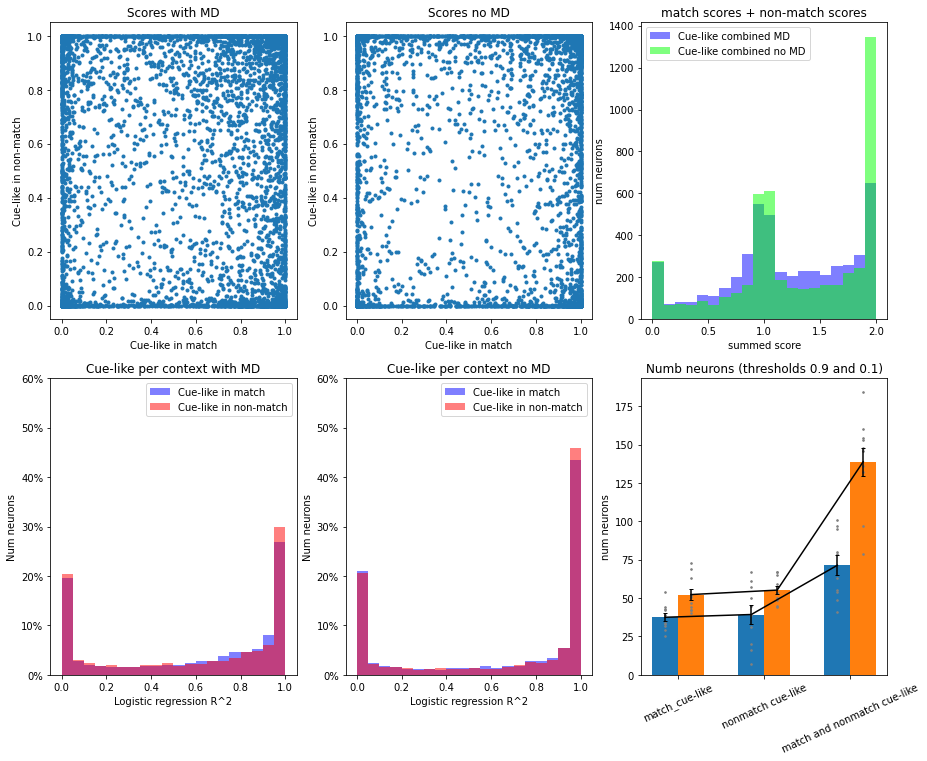

In [43]:
def plot_kmeans(ax, X):
    model = KMeans(n_clusters=5)
    model.fit(X)
    yhat = model.predict(X)
    clusters = np.unique(yhat)
    for cluster in clusters:
        row_ix = np.where(yhat == cluster)
        ax.scatter(X[row_ix, 0], X[row_ix, 1], marker=".")

fig = plt.figure(figsize=(15,12))
N_PFC_NEURONS = 500
hist_weights = np.ones(N_PFC_NEURONS * len(RUNS_MD)) / (N_PFC_NEURONS * len(RUNS_MD))

ax1 = fig.add_subplot(2,3,1)
ax1.scatter(scores[:,0],scores[:,1], marker=".")
ax1.set_xlabel("Cue-like in match")
ax1.set_ylabel("Cue-like in non-match")
ax1.set_title("Scores with MD")

ax2 = fig.add_subplot(2,3,4)
ax2.hist(scores[:,0], bins=20, fc=(0, 0, 1, 0.5), weights=hist_weights, label="Cue-like in match")
ax2.hist(scores[:,1], bins=20, fc=(1, 0, 0, 0.5), weights=hist_weights, label="Cue-like in non-match")
ax2.legend()
ax2.yaxis.set_major_formatter(PercentFormatter(1))
ax2.set_title("Cue-like per context with MD")
ax2.set_xlabel("Logistic regression R^2")
ax2.set_ylabel("Num neurons")
ax2.set_ylim((0,0.6))

ax3 = fig.add_subplot(2,3,2)
ax3.scatter(scores_noMD[:,0],scores_noMD[:,1], marker=".")
ax3.set_xlabel("Cue-like in match")
ax3.set_ylabel("Cue-like in non-match")
ax3.set_title("Scores no MD")

ax4 = fig.add_subplot(2,3,5)
w1 = np.ones(len(scores_noMD[:,0])) / len(scores_noMD[:,0])
ax4.hist(scores_noMD[:,0], bins=20, fc=(0, 0, 1, 0.5), weights=hist_weights, label="Cue-like in match")
ax4.hist(scores_noMD[:,1], bins=20, fc=(1, 0, 0, 0.5), weights=hist_weights, label="Cue-like in non-match")
ax4.legend()
ax4.yaxis.set_major_formatter(PercentFormatter(1))
ax4.set_title("Cue-like per context no MD")
ax4.set_xlabel("Logistic regression R^2")
ax4.set_ylabel("Num neurons")
ax4.set_ylim((0,0.6))

ax5 = fig.add_subplot(2,3,3)
ax5.hist(np.add(scores[:,0], scores[:,1]), bins=20, fc=(0, 0, 1, 0.5), label="Cue-like combined MD")
ax5.hist(np.add(scores_noMD[:,0], scores_noMD[:,1]), bins=20, fc=(0, 1, 0, 0.5), label="Cue-like combined no MD")
ax5.legend()
ax5.set_title("match scores + non-match scores")
ax5.set_xlabel("summed score")
ax5.set_ylabel("num neurons")

ax6 = fig.add_subplot(2,3,6)

def get_nums(s):
    num_cue1 = []
    num_cue2 = []
    num_cue = []
    for i in range(len(RUNS_MD)):
        i_low = i * N_PFC_NEURONS
        i_high = (i+1) * N_PFC_NEURONS
        num_cue1.append(len(np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] < 0.1))[0]))
        num_cue2.append(len(np.where(np.logical_and(s[i_low:i_high,1] > 0.9, s[i_low:i_high,0] < 0.1))[0]))
        num_cue.append(len(np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] > 0.9))[0]))
    return (num_cue1, num_cue2, num_cue)

(num_cue1_MD, num_cue2_MD, num_cue_MD) = get_nums(scores)
(num_cue1_noMD, num_cue2_noMD, num_cue_noMD) = get_nums(scores_noMD)
D = {}
D["match_cue-like"] = (num_cue1_MD, num_cue1_noMD)
D["nonmatch cue-like"] = (num_cue2_MD, num_cue2_noMD)
D["match and nonmatch cue-like"] = (num_cue_MD, num_cue_noMD)
plot_bars(ax6, D, "number")
ax6.set_ylabel("num neurons")
ax6.set_title("Numb neurons (thresholds 0.9 and 0.1)")
plt.show()



40.57984661805383 4.13368356891247e-17
KstestResult(statistic=0.6, pvalue=0.05244755244755244)
KstestResult(statistic=0.5, pvalue=0.16782134274394334)
KstestResult(statistic=0.8, pvalue=0.002056766762649115)
MannwhitneyuResult(statistic=15.5, pvalue=0.01002391575810747)
MannwhitneyuResult(statistic=27.0, pvalue=0.08813219286855527)
MannwhitneyuResult(statistic=6.0, pvalue=0.0009991495058677866)
KruskalResult(statistic=37.432005337929894, pvalue=4.906227115670192e-07)
              1         2         3        4         5             6
1  1.000000e+00  1.000000  1.000000  0.26268  0.012159  9.735730e-07
2  1.000000e+00  1.000000  1.000000  1.00000  1.000000  4.913135e-03
3  1.000000e+00  1.000000  1.000000  1.00000  0.134739  4.555391e-05
4  2.626804e-01  1.000000  1.000000  1.00000  1.000000  3.681006e-02
5  1.215935e-02  1.000000  0.134739  1.00000  1.000000  5.973283e-01
6  9.735730e-07  0.004913  0.000046  0.03681  0.597328  1.000000e+00
means1:  [37.5, 39.3, 71.4]
means2:  [52.3, 5

Text(0.5, 1.0, 'Numb neurons (thresholds 0.9 and 0.1)')

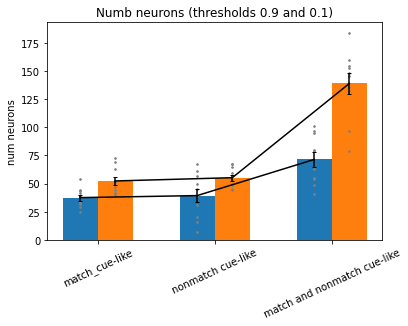

In [44]:
from scipy import stats
from scipy.stats import ks_2samp, mannwhitneyu
import scikit_posthocs as sp


f_value, p_value = stats.f_oneway(num_cue1_MD, num_cue2_MD, num_cue_MD, num_cue1_noMD, num_cue2_noMD, num_cue_noMD)
print(f_value, p_value)

print(ks_2samp(num_cue1_MD, num_cue1_noMD))
print(ks_2samp(num_cue2_MD, num_cue2_noMD))
print(ks_2samp(num_cue_MD, num_cue_noMD))

print(mannwhitneyu(num_cue1_MD, num_cue1_noMD, use_continuity=True, alternative='two-sided'))
print(mannwhitneyu(num_cue2_MD, num_cue2_noMD, use_continuity=True, alternative='two-sided'))
print(mannwhitneyu(num_cue_MD, num_cue_noMD, use_continuity=True, alternative='two-sided'))

print(stats.kruskal(num_cue1_MD, num_cue2_MD, num_cue_MD, num_cue1_noMD, num_cue2_noMD, num_cue_noMD))
data = [num_cue1_MD, num_cue1_noMD, num_cue2_MD, num_cue2_noMD, num_cue_MD, num_cue_noMD]
print(sp.posthoc_dunn(data, p_adjust = 'bonferroni'))

(num_cue1_MD, num_cue2_MD, num_cue_MD) = get_nums(scores)
(num_cue1_noMD, num_cue2_noMD, num_cue_noMD) = get_nums(scores_noMD)
D = {}
D["match_cue-like"] = (num_cue1_MD, num_cue1_noMD)
D["nonmatch cue-like"] = (num_cue2_MD, num_cue2_noMD)
D["match and nonmatch cue-like"] = (num_cue_MD, num_cue_noMD)
plot_bars(plt, D, "number")
plt.ylabel("num neurons")
plt.title("Numb neurons (thresholds 0.9 and 0.1)")
plt.savefig('cue-like-bars.eps', format='eps')


Text(0.5, 1.0, 'Num neurons (thresholds 0.9 and 0.1)')

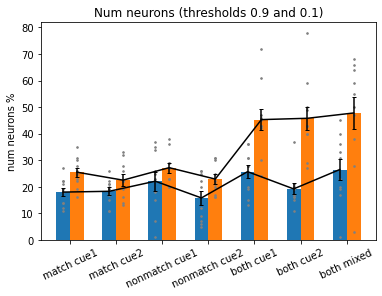

In [26]:
N_PFC_NEURONS = 500
def get_nums7(s,b):
    match_cue1_neurons = []
    match_cue2_neurons = []
    nomatch_cue1_neurons = []
    nonmatch_cue2_neurons = []
    cuelike_cue1_neurons = []
    cuelike_cue2_neurons = []
    cuelike_mixed_neurons = []
        
    for i in range(len(RUNS_MD)):
        i_low = i * N_PFC_NEURONS
        i_high = (i+1) * N_PFC_NEURONS
        match_neurons    = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] < 0.1))[0]
        nonmatch_neurons = np.where(np.logical_and(s[i_low:i_high,1] > 0.9, s[i_low:i_high,0] < 0.1))[0]
        cuelike_neurons  = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] > 0.9))[0]

        match_cue1_neurons.append(len(match_neurons[np.where(b[match_neurons,0] == 1)[0]]))
        match_cue2_neurons.append(len(match_neurons[np.where(b[match_neurons,0] == -1)[0]]))
        nomatch_cue1_neurons.append(len(nonmatch_neurons[np.where(b[nonmatch_neurons,1] == 1)[0]]))
        nonmatch_cue2_neurons.append(len(nonmatch_neurons[np.where(b[nonmatch_neurons,1] == -1)[0]]))
        
        cuelike_cue1_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == 1, b[cuelike_neurons,1] == 1))[0]]
        cuelike_cue2_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == -1, b[cuelike_neurons,1] == -1))[0]]
        cuelike_cue1_neurons.append(len(cuelike_cue1_neurons_))
        cuelike_cue2_neurons.append(len(cuelike_cue2_neurons_))        
        cuelike_mixed_neurons.append(len(np.setdiff1d(cuelike_neurons, np.concatenate((cuelike_cue1_neurons_, cuelike_cue2_neurons_)))))
        
    return (match_cue1_neurons, match_cue2_neurons, nomatch_cue1_neurons, nonmatch_cue2_neurons, cuelike_cue1_neurons, cuelike_cue2_neurons, cuelike_mixed_neurons)
                                     
                        
(num_match_cue1_neurons, num_match_cue2_neurons, num_nomatch_cue1_neurons, num_nonmatch_cue2_neurons, num_cuelike_cue1_neurons, num_cuelike_cue2_neurons, num_cuelike_mixed_neurons) = get_nums7(scores, b)
(num_match_cue1_neurons_noMD, num_match_cue2_neurons_noMD, num_nomatch_cue1_neurons_noMD, num_nonmatch_cue2_neurons_noMD, num_cuelike_cue1_neurons_noMD, num_cuelike_cue2_neurons_noMD, num_cuelike_mixed_neurons_noMD) = get_nums7(scores_noMD, b_noMD)
D = {}
D["match cue1"] = (num_match_cue1_neurons, num_match_cue1_neurons_noMD)
D["match cue2"] = (num_match_cue2_neurons, num_match_cue2_neurons_noMD)
D["nonmatch cue1"] = (num_nomatch_cue1_neurons, num_nomatch_cue1_neurons_noMD)
D["nonmatch cue2"] = (num_nonmatch_cue2_neurons, num_nonmatch_cue2_neurons_noMD)
D["both cue1"] = (num_cuelike_cue1_neurons, num_cuelike_cue1_neurons_noMD)
D["both cue2"] = (num_cuelike_cue2_neurons, num_cuelike_cue2_neurons_noMD)
D["both mixed"] = (num_cuelike_mixed_neurons, num_cuelike_mixed_neurons_noMD)                       
plot_bars(plt.gca(), D, "number")
plt.ylabel("num neurons %")
plt.title("Num neurons (thresholds 0.9 and 0.1)")
                                     

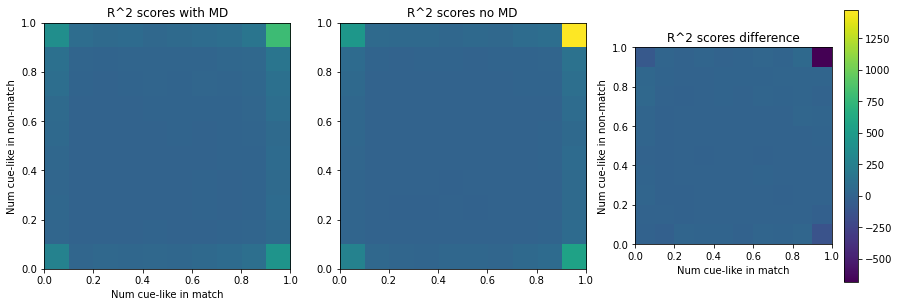

In [14]:
fig = plt.figure(figsize=(15,5))

H1, xedges, yedges = np.histogram2d(scores[:,0], scores[:,1], bins=10)
H2, _, _ = np.histogram2d(scores_noMD[:,0], scores_noMD[:,1], bins=10)
H3 = np.subtract(H1, H2)

vmax = max(np.max(H1),np.max(H2))
vmin = np.min(H3)

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(H1, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax1.set_title("R^2 scores with MD")
ax1.set_xlabel("Num cue-like in match")
ax1.set_ylabel("Num cue-like in non-match")

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(H2, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax2.set_title("R^2 scores no MD")
ax1.set_xlabel("Num cue-like in match")
ax1.set_ylabel("Num cue-like in non-match")

ax3 = fig.add_subplot(1,3,3)
im = ax3.imshow(H3, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax3.set_title("R^2 scores difference")
ax3.set_xlabel("Num cue-like in match")
ax3.set_ylabel("Num cue-like in non-match")

fig.colorbar(im)

plt.show()

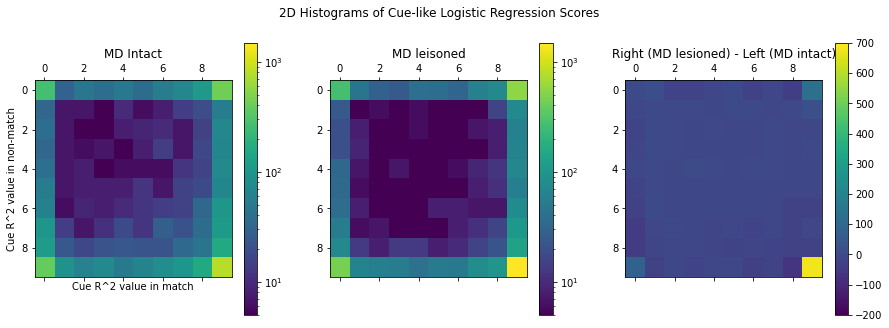

In [13]:
import matplotlib as mpl
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm

H1, xedges, yedges = np.histogram2d(scores[:,0], scores[:,1], bins=10)
H2, _, _ = np.histogram2d(scores_noMD[:,0], scores_noMD[:,1], bins=10)
H3 = np.subtract(H2, H1)
vmax = max(np.max(H1),np.max(H2))

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1,3,1)
im1 = ax1.matshow(H1, norm=LogNorm(vmin=5, vmax=vmax))
fig.colorbar(im1,ax=ax1)
# par1 = ax1.hist2d(scores[:,0], scores[:,1], norm=mpl.colors.LogNorm(vmin=10, vmax=1500))
# fig.colorbar(par1[3], ax=ax1)
ax1.set_title("MD Intact")
ax1.set_xlabel("Cue R^2 value in match")
ax1.set_ylabel("Cue R^2 value in non-match")

ax2 = fig.add_subplot(1,3,2)
im2 = ax2.matshow(H2, norm=LogNorm(vmin=5, vmax=vmax))
fig.colorbar(im2,ax=ax2)
# par2 = ax2.hist2d(scores_noMD[:,0], scores_noMD[:,1], norm=mpl.colors.LogNorm(vmin=10, vmax=1500))
# fig.colorbar(par2[3], ax=ax2)
ax2.set_title("MD leisoned")

ax3 = fig.add_subplot(1,3,3)
im3 = ax3.matshow(H3, vmin=-200, vmax=700)
fig.colorbar(im3,ax=ax3)
ax3.set_title("Right (MD lesioned) - Left (MD intact)")

plt.suptitle("2D Histograms of Cue-like Logistic Regression Scores")
plt.savefig('2d_hists.eps', format='eps')


In [ ]:
N_PFC_NEURONS = 500

def get_idxs7(s,b):
    match_cue1_neurons = []
    match_cue2_neurons = []
    nomatch_cue1_neurons = []
    nonmatch_cue2_neurons = []
    cuelike_cue1_neurons = []
    cuelike_cue2_neurons = []
    cuelike_mixed_neurons = []
        
    for i in range(len(RUNS_MD)):
        i_low = i * N_PFC_NEURONS
        i_high = (i+1) * N_PFC_NEURONS
        match_neurons    = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] < 0.1))[0]
        nonmatch_neurons = np.where(np.logical_and(s[i_low:i_high,1] > 0.9, s[i_low:i_high,0] < 0.1))[0]
        cuelike_neurons  = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] > 0.9))[0]
        
        match_cue1_neurons.extend([match_neurons[np.where(b[match_neurons,0] == 1)[0]]])
        match_cue2_neurons.extend([match_neurons[np.where(b[match_neurons,0] == -1)[0]]])
        nomatch_cue1_neurons.extend([nonmatch_neurons[np.where(b[nonmatch_neurons,1] == 1)[0]]])
        nonmatch_cue2_neurons.extend([nonmatch_neurons[np.where(b[nonmatch_neurons,1] == -1)[0]]])
        
        cuelike_cue1_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == 1, b[cuelike_neurons,1] == 1))[0]]
        cuelike_cue2_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == -1, b[cuelike_neurons,1] == -1))[0]]
        cuelike_cue1_neurons.extend([cuelike_cue1_neurons_])
        cuelike_cue2_neurons.extend([cuelike_cue2_neurons_])     
        cuelike_mixed_neurons.extend([np.setdiff1d(cuelike_neurons, np.concatenate((cuelike_cue1_neurons_, cuelike_cue2_neurons_)))])
        
    return (match_cue1_neurons, match_cue2_neurons, nomatch_cue1_neurons, nonmatch_cue2_neurons, cuelike_cue1_neurons, cuelike_cue2_neurons, cuelike_mixed_neurons) 

(match_cue1_neurons, match_cue2_neurons, nonmatch_cue1_neurons, nonmatch_cue2_neurons, cuelike_cue1_neurons, cuelike_cue2_neurons, cuelike_mixed_neurons) = get_idxs7(scores, b)
(match_cue1_neurons_noMD, match_cue2_neurons_noMD, nonmatch_cue1_neurons_noMD, nonmatch_cue2_neurons_noMD, cuelike_cue1_neurons_noMD, cuelike_cue2_neurons_noMD, cuelike_mixed_neurons_noMD) = get_idxs7(scores_noMD, b_noMD)


(3000, 2)
(4000, 72)


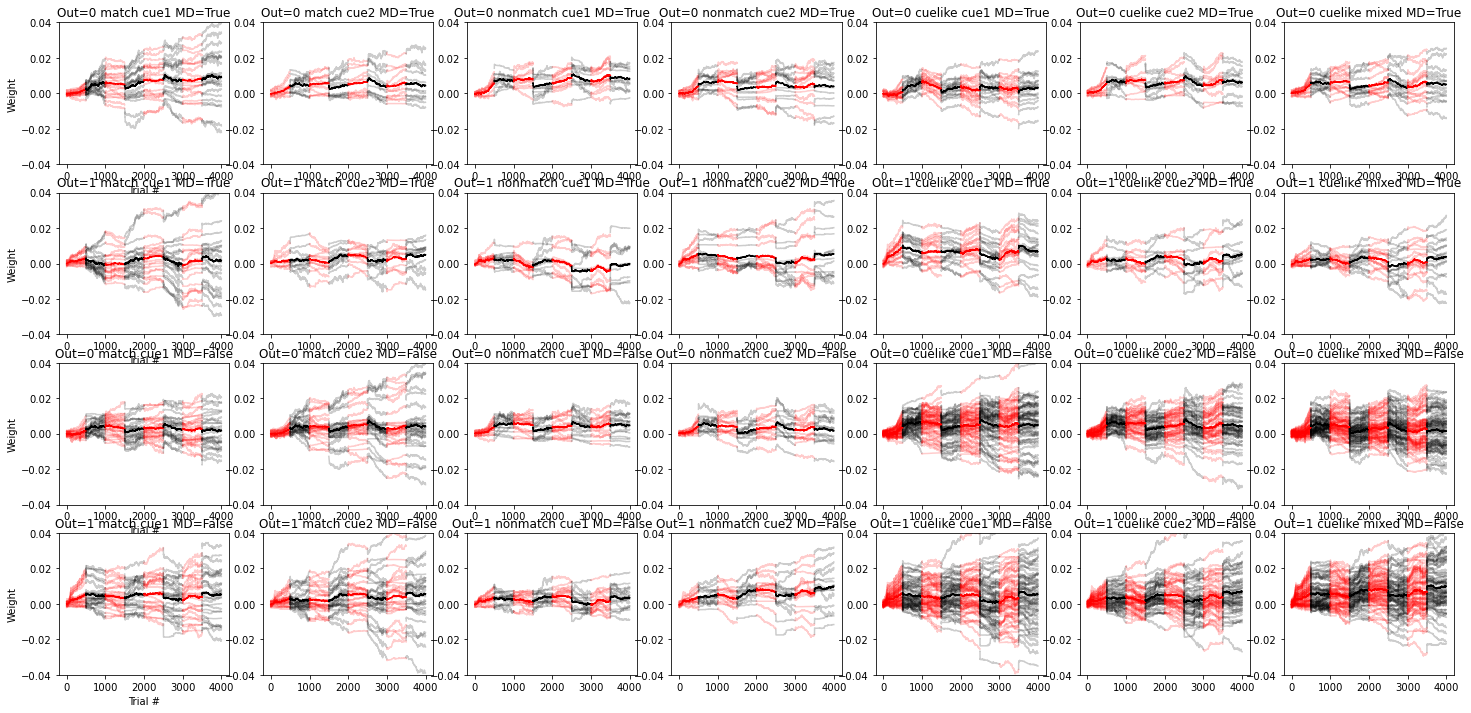

In [13]:
# IGNORE THIS CELL -- I FORGET WHAT'S GOING ON HERE

def plot_weights(run_idx, scores, wPFC_output, scores_noMD, wPFC_output_noMD):
    cue1_MD_idxs    = np.where(np.logical_and(scores[:,0] > 0.9, scores[:,1] < 0.1))[0]
    cue2_MD_idxs    = np.where(np.logical_and(scores[:,1] > 0.9, scores[:,0] < 0.1))[0]
    cuelike_MD_idxs = np.concatenate((cue1_MD_idxs, cue2_MD_idxs))
    cue1_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,0] > 0.9, scores_noMD[:,1] < 0.1))[0]
    cue2_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,1] > 0.9, scores_noMD[:,0] < 0.1))[0]
    cuelike_noMD_idxs = np.concatenate((cue1_noMD_idxs, cue2_noMD_idxs))

    x = np.arange(0,4000)
    wPFC_out0_all = wPFC_output[match_trials,0,:]
    wPFC_out1_all = wPFC_output[match_trials,1,:]
    wPFC_out0_all_noMD = wPFC_output_noMD[match_trials,0,:]
    wPFC_out1_all_noMD = wPFC_output_noMD[match_trials,1,:]

    m0 = np.mean(wPFC_out0_all,1)
    m1 = np.mean(wPFC_out1_all,1)
    e0 = np.std(wPFC_out0_all,1) / math.sqrt(wPFC_out0_all.shape[1])
    e1 = np.std(wPFC_out1_all,1) / math.sqrt(wPFC_out1_all.shape[1])

    m0_noMD = np.mean(wPFC_out0_all_noMD,1)
    m1_noMD = np.mean(wPFC_out1_all_noMD,1)
    e0_noMD = np.std(wPFC_out0_all_noMD,1) / math.sqrt(wPFC_out0_all_noMD.shape[1])
    e1_noMD = np.std(wPFC_out1_all_noMD,1) / math.sqrt(wPFC_out1_all_noMD.shape[1])

    wPFC_out0_match_cue1_MD = wPFC_output[:,0,match_cue1_neurons[run_idx]]
    wPFC_out0_match_cue2_MD = wPFC_output[:,0,match_cue2_neurons[run_idx]]
    wPFC_out0_nonmatch_cue1_MD = wPFC_output[:,0,nonmatch_cue1_neurons[run_idx]]
    wPFC_out0_nonmatch_cue2_MD = wPFC_output[:,0,nonmatch_cue2_neurons[run_idx]]
    wPFC_out0_cuelike_cue1_MD = wPFC_output[:,0,cuelike_cue1_neurons[run_idx]]
    wPFC_out0_cuelike_cue2_MD = wPFC_output[:,0,cuelike_cue2_neurons[run_idx]]
    wPFC_out0_cuelike_mixed_MD = wPFC_output[:,0,cuelike_mixed_neurons[run_idx]]

    wPFC_out1_match_cue1_MD = wPFC_output[:,1,match_cue1_neurons[run_idx]]
    wPFC_out1_match_cue2_MD = wPFC_output[:,1,match_cue2_neurons[run_idx]]
    wPFC_out1_nonmatch_cue1_MD = wPFC_output[:,1,nonmatch_cue1_neurons[run_idx]]
    wPFC_out1_nonmatch_cue2_MD = wPFC_output[:,1,nonmatch_cue2_neurons[run_idx]]
    wPFC_out1_cuelike_cue1_MD = wPFC_output[:,1,cuelike_cue1_neurons[run_idx]]
    wPFC_out1_cuelike_cue2_MD = wPFC_output[:,1,cuelike_cue2_neurons[run_idx]]
    wPFC_out1_cuelike_mixed_MD = wPFC_output[:,1,cuelike_mixed_neurons[run_idx]]

    wPFC_out0_match_cue1_noMD = wPFC_output[:,0,match_cue1_neurons_noMD[run_idx]]
    wPFC_out0_match_cue2_noMD = wPFC_output[:,0,match_cue2_neurons_noMD[run_idx]]
    wPFC_out0_nonmatch_cue1_noMD = wPFC_output[:,0,nonmatch_cue1_neurons_noMD[run_idx]]
    wPFC_out0_nonmatch_cue2_noMD = wPFC_output[:,0,nonmatch_cue2_neurons_noMD[run_idx]]
    wPFC_out0_cuelike_cue1_noMD = wPFC_output[:,0,cuelike_cue1_neurons_noMD[run_idx]]
    wPFC_out0_cuelike_cue2_noMD = wPFC_output[:,0,cuelike_cue2_neurons_noMD[run_idx]]
    wPFC_out0_cuelike_mixed_noMD = wPFC_output[:,0,cuelike_mixed_neurons_noMD[run_idx]]

    wPFC_out1_match_cue1_noMD = wPFC_output[:,1,match_cue1_neurons_noMD[run_idx]]
    wPFC_out1_match_cue2_noMD = wPFC_output[:,1,match_cue2_neurons_noMD[run_idx]]
    wPFC_out1_nonmatch_cue1_noMD = wPFC_output[:,1,nonmatch_cue1_neurons_noMD[run_idx]]
    wPFC_out1_nonmatch_cue2_noMD = wPFC_output[:,1,nonmatch_cue2_neurons_noMD[run_idx]]
    wPFC_out1_cuelike_cue1_noMD = wPFC_output[:,1,cuelike_cue1_neurons_noMD[run_idx]]
    wPFC_out1_cuelike_cue2_noMD = wPFC_output[:,1,cuelike_cue2_neurons_noMD[run_idx]]
    wPFC_out1_cuelike_mixed_noMD = wPFC_output[:,1,cuelike_mixed_neurons_noMD[run_idx]]

    def plt_trials(ax, w):
        if w.shape[1] == 0:
            return

        match_blocks = [1,3,5,7]
        nmatch_blocks = [0,2,4,6]

        for block in range(0,8):
            c = 'k' if block in match_blocks else 'r'
            s = block * 500
            t = block * 500 + 500
            ax.plot(np.arange(s,t), w[s:t,:], c, alpha=0.2)

        for block in range(0,8):
            c = 'k' if block in match_blocks else 'r'
            s = block * 500
            t = block * 500 + 500
            m = np.mean(w[s:t,:],1)
            e = np.std(w[s:t,:],1)        
            ax.plot(np.arange(s,t), np.mean(w[s:t,:], 1), c)
#             ax.fill_between(np.arange(s,t), m-e, m+e, color=c, alpha=0.3)

    fig = plt.figure(figsize=(25,12))

    ax1 = fig.add_subplot(4,7,1)
    plt_trials(ax1,wPFC_out0_match_cue1_MD)
    ax1.set_ylim((-0.04,0.04))
    ax1.set_title("Out=0 match cue1 MD=True")
    ax1.set_xlabel("Trial #")
    ax1.set_ylabel("Weight")

    ax2 = fig.add_subplot(4,7,2)
    plt_trials(ax2,wPFC_out0_match_cue2_MD)
    ax2.set_ylim((-0.04,0.04))
    ax2.set_title("Out=0 match cue2 MD=True")

    ax3 = fig.add_subplot(4,7,3)
    plt_trials(ax3,wPFC_out0_nonmatch_cue1_MD)
    ax3.set_ylim((-0.04,0.04))
    ax3.set_title("Out=0 nonmatch cue1 MD=True")

    ax4 = fig.add_subplot(4,7,4)
    plt_trials(ax4,wPFC_out0_nonmatch_cue2_MD)
    ax4.set_ylim((-0.04,0.04))
    ax4.set_title("Out=0 nonmatch cue2 MD=True")

    ax5 = fig.add_subplot(4,7,5)
    plt_trials(ax5,wPFC_out0_cuelike_cue1_MD)
    ax5.set_ylim((-0.04,0.04))
    ax5.set_title("Out=0 cuelike cue1 MD=True")

    ax6 = fig.add_subplot(4,7,6)
    plt_trials(ax6,wPFC_out0_cuelike_cue2_MD)
    ax6.set_ylim((-0.04,0.04))
    ax6.set_title("Out=0 cuelike cue2 MD=True")

    ax7 = fig.add_subplot(4,7,7)
    plt_trials(ax7,wPFC_out0_cuelike_mixed_MD)
    ax7.set_ylim((-0.04,0.04))
    ax7.set_title("Out=0 cuelike mixed MD=True")

    ax8 = fig.add_subplot(4,7,8)
    plt_trials(ax8,wPFC_out1_match_cue1_MD)
    ax8.set_ylim((-0.04,0.04))
    ax8.set_title("Out=1 match cue1 MD=True")
    ax8.set_xlabel("Trial #")
    ax8.set_ylabel("Weight")

    ax9 = fig.add_subplot(4,7,9)
    plt_trials(ax9,wPFC_out1_match_cue2_MD)
    ax9.set_ylim((-0.04,0.04))
    ax9.set_title("Out=1 match cue2 MD=True")

    ax10 = fig.add_subplot(4,7,10)
    plt_trials(ax10,wPFC_out1_nonmatch_cue1_MD)
    ax10.set_ylim((-0.04,0.04))
    ax10.set_title("Out=1 nonmatch cue1 MD=True")

    ax11 = fig.add_subplot(4,7,11)
    plt_trials(ax11,wPFC_out1_nonmatch_cue2_MD)
    ax11.set_ylim((-0.04,0.04))
    ax11.set_title("Out=1 nonmatch cue2 MD=True")

    ax12 = fig.add_subplot(4,7,12)
    plt_trials(ax12,wPFC_out1_cuelike_cue1_MD)
    ax12.set_ylim((-0.04,0.04))
    ax12.set_title("Out=1 cuelike cue1 MD=True")

    ax13 = fig.add_subplot(4,7,13)
    plt_trials(ax13,wPFC_out1_cuelike_cue2_MD)
    ax13.set_ylim((-0.04,0.04))
    ax13.set_title("Out=1 cuelike cue2 MD=True")

    ax14 = fig.add_subplot(4,7,14)
    plt_trials(ax14,wPFC_out1_cuelike_mixed_MD)
    ax14.set_ylim((-0.04,0.04))
    ax14.set_title("Out=1 cuelike mixed MD=True")

    ax15 = fig.add_subplot(4,7,15)
    plt_trials(ax15,wPFC_out0_match_cue1_noMD)
    ax15.set_ylim((-0.04,0.04))
    ax15.set_title("Out=0 match cue1 MD=False")
    ax15.set_xlabel("Trial #")
    ax15.set_ylabel("Weight")

    ax16 = fig.add_subplot(4,7,16)
    plt_trials(ax16,wPFC_out0_match_cue2_noMD)
    ax16.set_ylim((-0.04,0.04))
    ax16.set_title("Out=0 match cue2 MD=False")

    ax17 = fig.add_subplot(4,7,17)
    plt_trials(ax17,wPFC_out0_nonmatch_cue1_noMD)
    ax17.set_ylim((-0.04,0.04))
    ax17.set_title("Out=0 nonmatch cue1 MD=False")

    ax18 = fig.add_subplot(4,7,18)
    plt_trials(ax18,wPFC_out0_nonmatch_cue2_noMD)
    ax18.set_ylim((-0.04,0.04))
    ax18.set_title("Out=0 nonmatch cue2 MD=False")

    ax19 = fig.add_subplot(4,7,19)
    plt_trials(ax19,wPFC_out0_cuelike_cue1_noMD)
    ax19.set_ylim((-0.04,0.04))
    ax19.set_title("Out=0 cuelike cue1 MD=False")

    ax20 = fig.add_subplot(4,7,20)
    plt_trials(ax20,wPFC_out0_cuelike_cue2_noMD)
    ax20.set_ylim((-0.04,0.04))
    ax20.set_title("Out=0 cuelike cue2 MD=False")

    ax21 = fig.add_subplot(4,7,21)
    plt_trials(ax21,wPFC_out0_cuelike_mixed_noMD)
    ax21.set_ylim((-0.04,0.04))
    ax21.set_title("Out=0 cuelike mixed MD=False")

    ax22 = fig.add_subplot(4,7,22)
    plt_trials(ax22,wPFC_out1_match_cue1_noMD)
    ax22.set_ylim((-0.04,0.04))
    ax22.set_title("Out=1 match cue1 MD=False")
    ax22.set_xlabel("Trial #")
    ax22.set_ylabel("Weight")

    ax23 = fig.add_subplot(4,7,23)
    plt_trials(ax23,wPFC_out1_match_cue2_noMD)
    ax23.set_ylim((-0.04,0.04))
    ax23.set_title("Out=1 match cue2 MD=False")

    ax24 = fig.add_subplot(4,7,24)
    plt_trials(ax24,wPFC_out1_nonmatch_cue1_noMD)
    ax24.set_ylim((-0.04,0.04))
    ax24.set_title("Out=1 nonmatch cue1 MD=False")

    ax25 = fig.add_subplot(4,7,25)
    plt_trials(ax25,wPFC_out1_nonmatch_cue2_noMD)
    ax25.set_ylim((-0.04,0.04))
    ax25.set_title("Out=1 nonmatch cue2 MD=False")

    ax26 = fig.add_subplot(4,7,26)
    plt_trials(ax26,wPFC_out1_cuelike_cue1_noMD)
    ax26.set_ylim((-0.04,0.04))
    ax26.set_title("Out=1 cuelike cue1 MD=False")

    ax27 = fig.add_subplot(4,7,27)
    plt_trials(ax27,wPFC_out1_cuelike_cue2_noMD)
    ax27.set_ylim((-0.04,0.04))
    ax27.set_title("Out=1 cuelike cue2 MD=False")

    ax28 = fig.add_subplot(4,7,28)
    plt_trials(ax28,wPFC_out1_cuelike_mixed_noMD)
    ax28.set_ylim((-0.04,0.04))
    ax28.set_title("Out=1 cuelike mixed MD=False")
    
    print(wPFC_out1_cuelike_mixed_noMD.shape)

    plt.show()

    
(_, _, _, wPFC_output) = load_obj(RUNS_MD[5])
(_, _, _, wPFC_output_noMD) = load_obj(RUNS_MD_NO[5])
plot_weights(5, scores[2500:3000], wPFC_output, scores_noMD[2500:3000], wPFC_output_noMD)

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


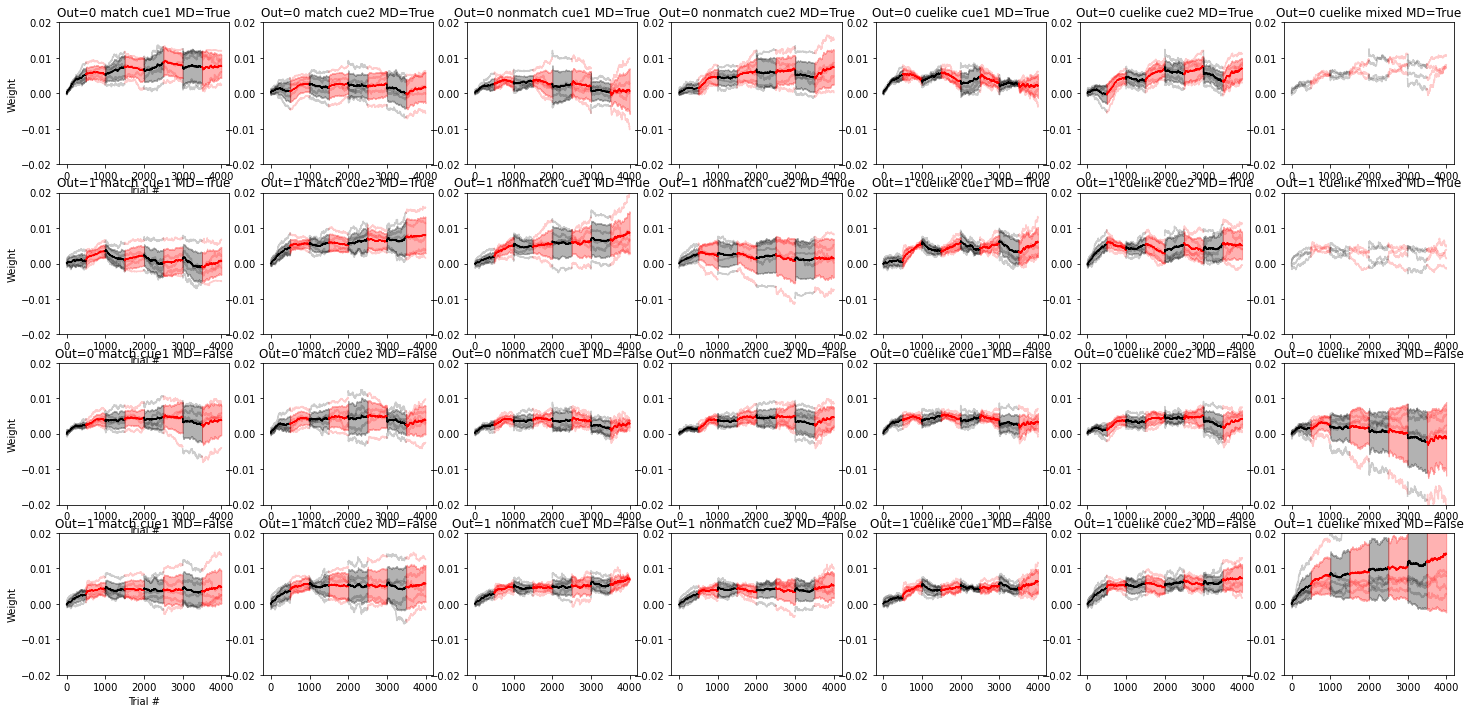

In [27]:
def plt_trials(ax, w, starts_with_match=True):
    if w.shape[1] == 0:
        return

    c = 'k' if starts_with_match else 'r'
    for block in range(0,8):
        s = block * 500
        t = block * 500 + 500
        ax.plot(np.arange(s,t), w[s:t,:], c, alpha=0.2)
        c = 'k' if c == 'r' else 'r'

    c = 'k' if starts_with_match else 'r'
    for block in range(0,8):
        s = block * 500
        t = block * 500 + 500
        m = np.mean(w[s:t,:],1)
        e = np.std(w[s:t,:],1)        
        ax.plot(np.arange(s,t), np.mean(w[s:t,:], 1), c)
        ax.fill_between(np.arange(s,t), m-e, m+e, color=c, alpha=0.3)
        c = 'k' if c == 'r' else 'r'

def plot_weights(scores_, scores_noMD_):
    fig = plt.figure(figsize=(25,12))

    ax1 = fig.add_subplot(4,7,1)
    ax1.set_ylim((-0.02,0.02))
    ax1.set_title("Out=0 match cue1 MD=True")
    ax1.set_xlabel("Trial #")
    ax1.set_ylabel("Weight")

    ax2 = fig.add_subplot(4,7,2)
    ax2.set_ylim((-0.02,0.02))
    ax2.set_title("Out=0 match cue2 MD=True")

    ax3 = fig.add_subplot(4,7,3)
    ax3.set_ylim((-0.02,0.02))
    ax3.set_title("Out=0 nonmatch cue1 MD=True")

    ax4 = fig.add_subplot(4,7,4)
    ax4.set_ylim((-0.02,0.02))
    ax4.set_title("Out=0 nonmatch cue2 MD=True")

    ax5 = fig.add_subplot(4,7,5)
    ax5.set_ylim((-0.02,0.02))
    ax5.set_title("Out=0 cuelike cue1 MD=True")

    ax6 = fig.add_subplot(4,7,6)
    ax6.set_ylim((-0.02,0.02))
    ax6.set_title("Out=0 cuelike cue2 MD=True")

    ax7 = fig.add_subplot(4,7,7)
    ax7.set_ylim((-0.02,0.02))
    ax7.set_title("Out=0 cuelike mixed MD=True")

    ax8 = fig.add_subplot(4,7,8)
    ax8.set_ylim((-0.02,0.02))
    ax8.set_title("Out=1 match cue1 MD=True")
    ax8.set_xlabel("Trial #")
    ax8.set_ylabel("Weight")

    ax9 = fig.add_subplot(4,7,9)
    ax9.set_ylim((-0.02,0.02))
    ax9.set_title("Out=1 match cue2 MD=True")

    ax10 = fig.add_subplot(4,7,10)
    ax10.set_ylim((-0.02,0.02))
    ax10.set_title("Out=1 nonmatch cue1 MD=True")

    ax11 = fig.add_subplot(4,7,11)
    ax11.set_ylim((-0.02,0.02))
    ax11.set_title("Out=1 nonmatch cue2 MD=True")

    ax12 = fig.add_subplot(4,7,12)
    ax12.set_ylim((-0.02,0.02))
    ax12.set_title("Out=1 cuelike cue1 MD=True")

    ax13 = fig.add_subplot(4,7,13)
    ax13.set_ylim((-0.02,0.02))
    ax13.set_title("Out=1 cuelike cue2 MD=True")

    ax14 = fig.add_subplot(4,7,14)
    ax14.set_ylim((-0.02,0.02))
    ax14.set_title("Out=1 cuelike mixed MD=True")

    ax15 = fig.add_subplot(4,7,15)
    ax15.set_ylim((-0.02,0.02))
    ax15.set_title("Out=0 match cue1 MD=False")
    ax15.set_xlabel("Trial #")
    ax15.set_ylabel("Weight")

    ax16 = fig.add_subplot(4,7,16)
    ax16.set_ylim((-0.02,0.02))
    ax16.set_title("Out=0 match cue2 MD=False")

    ax17 = fig.add_subplot(4,7,17)
    ax17.set_ylim((-0.02,0.02))
    ax17.set_title("Out=0 nonmatch cue1 MD=False")

    ax18 = fig.add_subplot(4,7,18)
    ax18.set_ylim((-0.02,0.02))
    ax18.set_title("Out=0 nonmatch cue2 MD=False")

    ax19 = fig.add_subplot(4,7,19)
    ax19.set_ylim((-0.02,0.02))
    ax19.set_title("Out=0 cuelike cue1 MD=False")

    ax20 = fig.add_subplot(4,7,20)
    ax20.set_ylim((-0.02,0.02))
    ax20.set_title("Out=0 cuelike cue2 MD=False")

    ax21 = fig.add_subplot(4,7,21)
    ax21.set_ylim((-0.02,0.02))
    ax21.set_title("Out=0 cuelike mixed MD=False")

    ax22 = fig.add_subplot(4,7,22)
    ax22.set_ylim((-0.02,0.02))
    ax22.set_title("Out=1 match cue1 MD=False")
    ax22.set_xlabel("Trial #")
    ax22.set_ylabel("Weight")

    ax23 = fig.add_subplot(4,7,23)
    ax23.set_ylim((-0.02,0.02))
    ax23.set_title("Out=1 match cue2 MD=False")

    ax24 = fig.add_subplot(4,7,24)
    ax24.set_ylim((-0.02,0.02))
    ax24.set_title("Out=1 nonmatch cue1 MD=False")

    ax25 = fig.add_subplot(4,7,25)
    ax25.set_ylim((-0.02,0.02))
    ax25.set_title("Out=1 nonmatch cue2 MD=False")

    ax26 = fig.add_subplot(4,7,26)
    ax26.set_ylim((-0.02,0.02))
    ax26.set_title("Out=1 cuelike cue1 MD=False")

    ax27 = fig.add_subplot(4,7,27)
    ax27.set_ylim((-0.02,0.02))
    ax27.set_title("Out=1 cuelike cue2 MD=False")

    ax28 = fig.add_subplot(4,7,28)
    ax28.set_ylim((-0.02,0.02))
    ax28.set_title("Out=1 cuelike mixed MD=False")
    
    N_TRIALS = 4000
    N_SIMS = 5
    wPFC_out0_match_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_match_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_nonmatch_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_nonmatch_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_mixed_MD = np.zeros((N_TRIALS,N_SIMS))

    wPFC_out1_match_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_match_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_nonmatch_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_nonmatch_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_mixed_MD = np.zeros((N_TRIALS,N_SIMS))

    wPFC_out0_match_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_match_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_nonmatch_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_nonmatch_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_mixed_noMD = np.zeros((N_TRIALS,N_SIMS))

    wPFC_out1_match_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_match_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_nonmatch_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_nonmatch_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_mixed_noMD = np.zeros((N_TRIALS,N_SIMS))
    
    for run_idx in range(0,5):
        i = run_idx #run_idx - 5
        s = run_idx * 500
        t = run_idx * 500 + 500
        scores = scores_[s:t]
        scores_noMD = scores_noMD_[s:t]
        (_, _, _, wPFC_output) = load_obj(RUNS_MD[run_idx])
        (_, _, _, wPFC_output_noMD) = load_obj(RUNS_MD_NO[run_idx])
    
        cue1_MD_idxs    = np.where(np.logical_and(scores[:,0] > 0.9, scores[:,1] < 0.1))[0]
        cue2_MD_idxs    = np.where(np.logical_and(scores[:,1] > 0.9, scores[:,0] < 0.1))[0]
        cuelike_MD_idxs = np.concatenate((cue1_MD_idxs, cue2_MD_idxs))
        cue1_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,0] > 0.9, scores_noMD[:,1] < 0.1))[0]
        cue2_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,1] > 0.9, scores_noMD[:,0] < 0.1))[0]
        cuelike_noMD_idxs = np.concatenate((cue1_noMD_idxs, cue2_noMD_idxs))

        x = np.arange(0,4000)
        wPFC_out0_all = wPFC_output[match_trials,0,:]
        wPFC_out1_all = wPFC_output[match_trials,1,:]
        wPFC_out0_all_noMD = wPFC_output_noMD[match_trials,0,:]
        wPFC_out1_all_noMD = wPFC_output_noMD[match_trials,1,:]

        m0 = np.mean(wPFC_out0_all,1)
        m1 = np.mean(wPFC_out1_all,1)
        e0 = np.std(wPFC_out0_all,1) / math.sqrt(wPFC_out0_all.shape[1])
        e1 = np.std(wPFC_out1_all,1) / math.sqrt(wPFC_out1_all.shape[1])

        m0_noMD = np.mean(wPFC_out0_all_noMD,1)
        m1_noMD = np.mean(wPFC_out1_all_noMD,1)
        e0_noMD = np.std(wPFC_out0_all_noMD,1) / math.sqrt(wPFC_out0_all_noMD.shape[1])
        e1_noMD = np.std(wPFC_out1_all_noMD,1) / math.sqrt(wPFC_out1_all_noMD.shape[1])

        wPFC_out0_match_cue1_MD[:,i] = np.mean(wPFC_output[:,0,match_cue1_neurons[run_idx]],1)
        wPFC_out0_match_cue2_MD[:,i] = np.mean(wPFC_output[:,0,match_cue2_neurons[run_idx]],1)
        wPFC_out0_nonmatch_cue1_MD[:,i] = np.mean(wPFC_output[:,0,nonmatch_cue1_neurons[run_idx]],1)
        wPFC_out0_nonmatch_cue2_MD[:,i] = np.mean(wPFC_output[:,0,nonmatch_cue2_neurons[run_idx]],1)
        wPFC_out0_cuelike_cue1_MD[:,i] = np.mean(wPFC_output[:,0,cuelike_cue1_neurons[run_idx]],1)
        wPFC_out0_cuelike_cue2_MD[:,i] = np.mean(wPFC_output[:,0,cuelike_cue2_neurons[run_idx]],1)
        wPFC_out0_cuelike_mixed_MD[:,i] = np.mean(wPFC_output[:,0,cuelike_mixed_neurons[run_idx]],1)

        wPFC_out1_match_cue1_MD[:,i] = np.mean(wPFC_output[:,1,match_cue1_neurons[run_idx]],1)
        wPFC_out1_match_cue2_MD[:,i] = np.mean(wPFC_output[:,1,match_cue2_neurons[run_idx]],1)
        wPFC_out1_nonmatch_cue1_MD[:,i] = np.mean(wPFC_output[:,1,nonmatch_cue1_neurons[run_idx]],1)
        wPFC_out1_nonmatch_cue2_MD[:,i] = np.mean(wPFC_output[:,1,nonmatch_cue2_neurons[run_idx]],1)
        wPFC_out1_cuelike_cue1_MD[:,i] = np.mean(wPFC_output[:,1,cuelike_cue1_neurons[run_idx]],1)
        wPFC_out1_cuelike_cue2_MD[:,i] = np.mean(wPFC_output[:,1,cuelike_cue2_neurons[run_idx]],1)
        wPFC_out1_cuelike_mixed_MD[:,i] = np.mean(wPFC_output[:,1,cuelike_mixed_neurons[run_idx]],1)

        wPFC_out0_match_cue1_noMD[:,i] = np.mean(wPFC_output[:,0,match_cue1_neurons_noMD[run_idx]],1)
        wPFC_out0_match_cue2_noMD[:,i] = np.mean(wPFC_output[:,0,match_cue2_neurons_noMD[run_idx]],1)
        wPFC_out0_nonmatch_cue1_noMD[:,i] = np.mean(wPFC_output[:,0,nonmatch_cue1_neurons_noMD[run_idx]],1)
        wPFC_out0_nonmatch_cue2_noMD[:,i] = np.mean(wPFC_output[:,0,nonmatch_cue2_neurons_noMD[run_idx]],1)
        wPFC_out0_cuelike_cue1_noMD[:,i] = np.mean(wPFC_output[:,0,cuelike_cue1_neurons_noMD[run_idx]],1)
        wPFC_out0_cuelike_cue2_noMD[:,i] = np.mean(wPFC_output[:,0,cuelike_cue2_neurons_noMD[run_idx]],1)
        wPFC_out0_cuelike_mixed_noMD[:,i] = np.mean(wPFC_output[:,0,cuelike_mixed_neurons_noMD[run_idx]],1)

        wPFC_out1_match_cue1_noMD[:,i] = np.mean(wPFC_output[:,1,match_cue1_neurons_noMD[run_idx]],1)
        wPFC_out1_match_cue2_noMD[:,i] = np.mean(wPFC_output[:,1,match_cue2_neurons_noMD[run_idx]],1)
        wPFC_out1_nonmatch_cue1_noMD[:,i] = np.mean(wPFC_output[:,1,nonmatch_cue1_neurons_noMD[run_idx]],1)
        wPFC_out1_nonmatch_cue2_noMD[:,i] = np.mean(wPFC_output[:,1,nonmatch_cue2_neurons_noMD[run_idx]],1)
        wPFC_out1_cuelike_cue1_noMD[:,i] = np.mean(wPFC_output[:,1,cuelike_cue1_neurons_noMD[run_idx]],1)
        wPFC_out1_cuelike_cue2_noMD[:,i] = np.mean(wPFC_output[:,1,cuelike_cue2_neurons_noMD[run_idx]],1)
        wPFC_out1_cuelike_mixed_noMD[:,i] = np.mean(wPFC_output[:,1,cuelike_mixed_neurons_noMD[run_idx]],1)


    plt_trials(ax1,wPFC_out0_match_cue1_MD)

    plt_trials(ax2,wPFC_out0_match_cue2_MD)

    plt_trials(ax3,wPFC_out0_nonmatch_cue1_MD)

    plt_trials(ax4,wPFC_out0_nonmatch_cue2_MD)

    plt_trials(ax5,wPFC_out0_cuelike_cue1_MD)

    plt_trials(ax6,wPFC_out0_cuelike_cue2_MD)

    plt_trials(ax7,wPFC_out0_cuelike_mixed_MD)

    plt_trials(ax8,wPFC_out1_match_cue1_MD)

    plt_trials(ax9,wPFC_out1_match_cue2_MD)

    plt_trials(ax10,wPFC_out1_nonmatch_cue1_MD)

    plt_trials(ax11,wPFC_out1_nonmatch_cue2_MD)

    plt_trials(ax12,wPFC_out1_cuelike_cue1_MD)

    plt_trials(ax13,wPFC_out1_cuelike_cue2_MD)

    plt_trials(ax14,wPFC_out1_cuelike_mixed_MD)

    plt_trials(ax15,wPFC_out0_match_cue1_noMD)

    plt_trials(ax16,wPFC_out0_match_cue2_noMD)

    plt_trials(ax17,wPFC_out0_nonmatch_cue1_noMD)

    plt_trials(ax18,wPFC_out0_nonmatch_cue2_noMD)

    plt_trials(ax19,wPFC_out0_cuelike_cue1_noMD)

    plt_trials(ax20,wPFC_out0_cuelike_cue2_noMD)

    plt_trials(ax21,wPFC_out0_cuelike_mixed_noMD)

    plt_trials(ax22,wPFC_out1_match_cue1_noMD)

    plt_trials(ax23,wPFC_out1_match_cue2_noMD)

    plt_trials(ax24,wPFC_out1_nonmatch_cue1_noMD)

    plt_trials(ax25,wPFC_out1_nonmatch_cue2_noMD)

    plt_trials(ax26,wPFC_out1_cuelike_cue1_noMD)

    plt_trials(ax27,wPFC_out1_cuelike_cue2_noMD)

    plt_trials(ax28,wPFC_out1_cuelike_mixed_noMD)

    plt.show()    

plot_weights(scores, scores_noMD)

# See neurons inputs/encoding breadown


[array([ 27,  29,  33,  62,  65,  67,  73,  74,  86,  87,  92, 100, 110,
       114, 116, 124, 127, 134, 135, 141, 145, 148, 149, 153, 154, 156,
       166, 171, 180, 209, 373, 425]), array([ 13,  29,  31,  40,  43,  47,  48,  54,  57,  59,  67,  69,  71,
        73,  81,  86,  90, 102, 114, 121, 136, 146, 152, 153, 156, 157,
       166, 168, 171, 180, 184, 185, 187, 196, 199, 250, 379, 387, 401,
       410, 414, 472, 485, 497]), array([ 22,  27,  54,  64,  70,  74,  78,  80,  98, 102, 124, 133, 134,
       136, 148, 161, 163, 184, 187, 193, 203, 209, 250, 340, 352, 373,
       387, 427, 489]), array([  1,   3,  13,  22,  23,  33,  35,  40,  48,  54,  60,  78,  80,
        86,  96, 100, 112, 114, 134, 135, 149, 153, 154, 156, 161, 163,
       168, 190, 193, 194, 209, 223, 227, 340, 342, 467, 494]), array([ 11,  33,  73,  74, 129, 141, 153, 154, 174, 179, 185, 342, 352,
       379]), array([  3,  11,  12,  22,  27,  29,  45,  64,  66,  71,  73,  74,  96,
        99, 110, 133, 135, 136, 

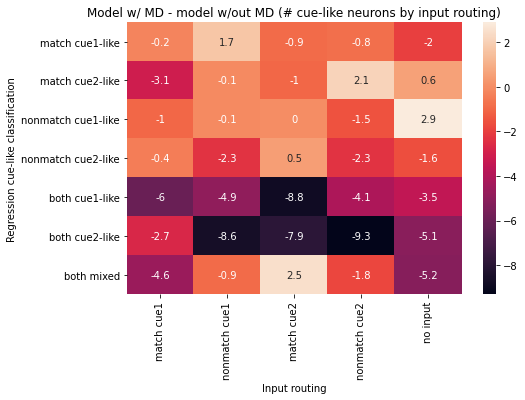

In [52]:
def count_groups(X):
    Y = []
    for arr in X:
        d = [0, 0, 0, 0, 0]
        for neuron_idx in arr:
            if neuron_idx < 100:
                d[0] = d[0] + 1
            elif neuron_idx < 200:
                d[1] = d[1] + 1
            elif neuron_idx < 300:
                d[2] = d[2] + 1
            elif neuron_idx < 400:
                d[3] = d[3] + 1
            elif neuron_idx < 500:
                d[4] = d[4] + 1
        Y.append(d)
    return Y

def comp_diff(a,b):
    A = np.matrix(count_groups(a))
    B = np.matrix(count_groups(b))
    return np.subtract(A,B).tolist()
    
D = {}
D["match cue1"] = comp_diff(match_cue1_neurons, match_cue1_neurons_noMD)
D["match cue2"] = comp_diff(match_cue2_neurons, match_cue2_neurons_noMD)
D["nonmatch cue1"] = comp_diff(nonmatch_cue1_neurons, nonmatch_cue1_neurons_noMD)
D["nonmatch cue2"] = comp_diff(nonmatch_cue2_neurons, nonmatch_cue2_neurons_noMD)
D["both cue1"] = comp_diff(cuelike_cue1_neurons, cuelike_cue1_neurons_noMD)
D["both cue2"] = comp_diff(cuelike_cue2_neurons, cuelike_cue2_neurons_noMD)
D["both mixed"] = comp_diff(cuelike_mixed_neurons, cuelike_mixed_neurons_noMD)

Ms = []
for i in range(len(D["match cue1"])):
    M = [D["match cue1"][i], 
         D["match cue2"][i],
         D["nonmatch cue1"][i],
         D["nonmatch cue2"][i],
         D["both cue1"][i],
         D["both cue2"][i],
         D["both mixed"][i]]
    Ms.append(M)

F = np.zeros((len(Ms[0]), len(Ms[0][0])))
    
for r in range(len(Ms[0])):
    for c in range(len(Ms[0][0])):
        s = 0
        for idx in range(len(D["match cue1"])):
            s = s + Ms[idx][r][c]
        F[r,c] = s / len(D["match cue1"])
        
        
cm_df = pd.DataFrame(np.array(F),
                     columns = ['match cue1', 'nonmatch cue1', 'match cue2', 'nonmatch cue2', 'no input'], 
                     index = ['match cue1-like', 'match cue2-like', 'nonmatch cue1-like', 'nonmatch cue2-like', 'both cue1-like', 'both cue2-like', 'both mixed'])
plt.figure(figsize=(7.5,5))
sns.heatmap(cm_df, annot=True)
plt.title("Model w/ MD - model w/out MD (# cue-like neurons by input routing)")
plt.ylabel("Regression cue-like classification")
plt.xlabel("Input routing")
plt.show()

<ipython-input-25-f1dfce12a37f>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  print(np.array(match_cue1_neurons).shape)


(10,)
[[ 5 10  7  3  6]
 [ 3  2  7  8  4]
 [ 1  2  0  0  3]
 [ 1  1  0  0  1]
 [ 3  1  2  4  0]
 [ 3  0  6  8  2]
 [ 6  5  9  3  3]]
[5, 3, 1, 1, 3, 3, 6]
[10, 2, 2, 1, 1, 0, 5]


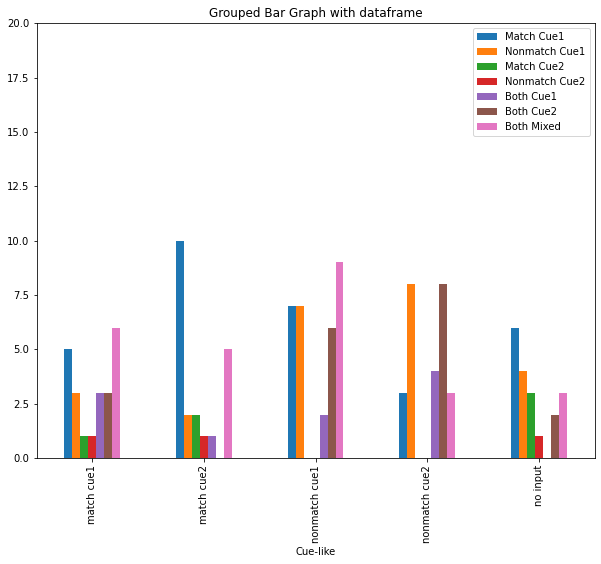

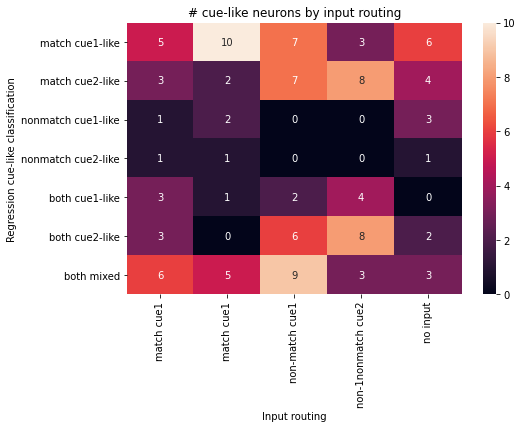

In [25]:
import pandas as pd
from operator import add

print(np.array(match_cue1_neurons).shape)

def get_plot_group(neuron_idx):
    R = [0, 0, 0, 0, 0, 0, 0]
    
    run_num = 8
    R[0] = match_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[1] = match_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[2] = nonmatch_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[3] = nonmatch_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[4] = cuelike_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[5] = cuelike_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[6] = cuelike_mixed_neurons[run_num].tolist().count(neuron_idx)
        
    return R

def get_plot_group_noMD(neuron_idx):
    R = [0, 0, 0, 0, 0, 0, 0]
    
    run_num = 2    
    R[0] = match_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[1] = match_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[2] = nonmatch_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[3] = nonmatch_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[4] = cuelike_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[5] = cuelike_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[6] = cuelike_mixed_neurons_noMD[run_num].tolist().count(neuron_idx)
        
    return R


def get_plot_data(min_neuron_idx, max_neuron_idx):
    D = [0, 0, 0, 0, 0, 0, 0]
    for neuron_idx in range(min_neuron_idx, max_neuron_idx):
        group = get_plot_group(neuron_idx)
        D = list(map(add, D, group))
    return D

def get_plot_data_noMD(min_neuron_idx, max_neuron_idx):
    D = [0, 0, 0, 0, 0, 0, 0]
    for neuron_idx in range(min_neuron_idx, max_neuron_idx):
        group = get_plot_group_noMD(neuron_idx)
        D = list(map(add, D, group))
    return D
  
    
D_0_100 = ["match cue1"] + get_plot_data(0,100)
D_100_200 = ["match cue2"] + get_plot_data(100,200)
D_200_300 = ["nonmatch cue1"] + get_plot_data(200,300)
D_300_400 = ["nonmatch cue2"] + get_plot_data(300,400)
D_400_500 = ["no input"] + get_plot_data(400,500)

# D_0_100 = ["match cue1"] + get_plot_data_noMD(0,100)
# D_100_200 = ["match cue2"] + get_plot_data_noMD(100,200)
# D_200_300 = ["nonmatch cue1"] + get_plot_data_noMD(200,300)
# D_300_400 = ["nonmatch cue2"] + get_plot_data_noMD(300,400)
# D_400_500 = ["no input"] + get_plot_data_noMD(400,500)

df = pd.DataFrame([D_0_100, D_100_200, D_200_300, D_300_400, D_400_500],
                  columns=['Cue-like', 'Match Cue1', 'Nonmatch Cue1', 'Match Cue2', 'Nonmatch Cue2', 'Both Cue1', 'Both Cue2', 'Both Mixed'])
df.plot(figsize=(10,8),
        x='Cue-like',
        kind='bar',
        stacked=False,
        title='Grouped Bar Graph with dataframe',
        ylim=(0,20))

D_match_cue1 = get_plot_data(0,100)
D_match_cue2 = get_plot_data(100,200)
D_nonmatch_cue1 = get_plot_data(200,300)
D_nonmatch_cue2 = get_plot_data(300,400)
D_noinput = get_plot_data(400,500)
F = np.transpose(np.array([D_match_cue1, D_match_cue2, D_nonmatch_cue1, D_nonmatch_cue2, D_noinput]))

print(F)
print(D_match_cue1)
print(D_match_cue2)

cm_df = pd.DataFrame(np.array(F),
                     columns = ['match cue1', 'match cue1', 'non-match cue1', 'non-1nonmatch cue2', 'no input'], 
                     index = ['match cue1-like', 'match cue2-like', 'nonmatch cue1-like', 'nonmatch cue2-like', 'both cue1-like', 'both cue2-like', 'both mixed'])
plt.figure(figsize=(7.5,5))
sns.heatmap(cm_df, annot=True)
plt.title("# cue-like neurons by input routing")
plt.ylabel("Regression cue-like classification")
plt.xlabel("Input routing")
plt.show()

In [27]:
# Produce difference matrix plot (take mean over each initalization)

1

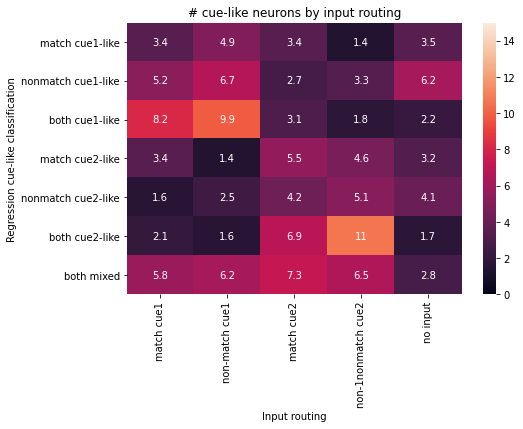

In [17]:
## THESE ARE THE GOOD 2D HIST PLOTS!


import pandas as pd
from operator import add

def get_plot_group(neuron_idx, run_num):
    R = [0, 0, 0, 0, 0, 0, 0]
    
    R[0] = match_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[1] = nonmatch_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[2] = cuelike_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[3] = match_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[4] = nonmatch_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[5] = cuelike_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[6] = cuelike_mixed_neurons[run_num].tolist().count(neuron_idx)
        
    return R

def get_plot_data(min_neuron_idx, max_neuron_idx):
    D = [0, 0, 0, 0, 0, 0, 0]
    for run_num in range(10):
        for neuron_idx in range(min_neuron_idx, max_neuron_idx):
            group = get_plot_group(neuron_idx, run_num)
            D = list(map(add, D, [x/10 for x in group]))
    return D

D_match_cue1 = get_plot_data(0,100)
D_nonmatch_cue1 = get_plot_data(100,200)
D_match_cue2 = get_plot_data(200,300)
D_nonmatch_cue2 = get_plot_data(300,400)
D_noinput = get_plot_data(400,500)
F = np.transpose(np.array([D_match_cue1, D_nonmatch_cue1, D_match_cue2, D_nonmatch_cue2, D_noinput]))

cm_df = pd.DataFrame(F,
                     columns = ['match cue1', 'non-match cue1', 'match cue2', 'non-1nonmatch cue2', 'no input'], 
                     index = ['match cue1-like', 'nonmatch cue1-like', 'both cue1-like', 'match cue2-like', 'nonmatch cue2-like', 'both cue2-like', 'both mixed'])
plt.figure(figsize=(7.5,5))
sns.heatmap(cm_df, annot=True, vmin=0, vmax=15)
plt.title("# cue-like neurons by input routing")
plt.ylabel("Regression cue-like classification")
plt.xlabel("Input routing")
plt.show()


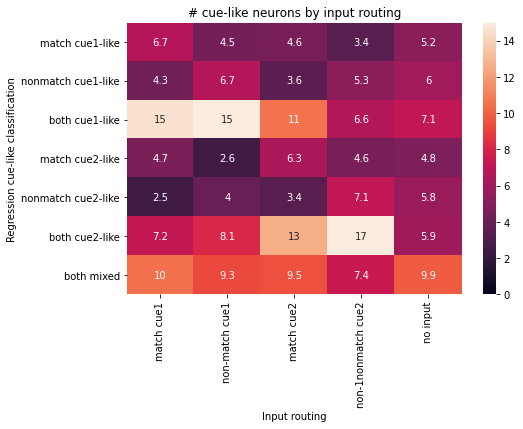

In [18]:
import pandas as pd
from operator import add

def get_plot_group_noMD(neuron_idx, run_num):
    R = [0, 0, 0, 0, 0, 0, 0]
    
    R[0] = match_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[1] = nonmatch_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[2] = cuelike_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[3] = match_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[4] = nonmatch_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[5] = cuelike_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[6] = cuelike_mixed_neurons_noMD[run_num].tolist().count(neuron_idx)
        
    return R


def get_plot_data_noMD(min_neuron_idx, max_neuron_idx):
    D = [0, 0, 0, 0, 0, 0, 0]
    for run_num in range(10):
        for neuron_idx in range(min_neuron_idx, max_neuron_idx):
            group = get_plot_group_noMD(neuron_idx, run_num)
            D = list(map(add, D, [x/10 for x in group]))
    return D

D_match_cue1 = get_plot_data_noMD(0,100)
D_nonmatch_cue1 = get_plot_data_noMD(100,200)
D_match_cue2 = get_plot_data_noMD(200,300)
D_nonmatch_cue2 = get_plot_data_noMD(300,400)
D_noinput = get_plot_data_noMD(400,500)
F = np.transpose(np.array([D_match_cue1, D_nonmatch_cue1, D_match_cue2, D_nonmatch_cue2, D_noinput]))

cm_df = pd.DataFrame(F,
                     columns = ['match cue1', 'non-match cue1', 'match cue2', 'non-1nonmatch cue2', 'no input'], 
                     index = ['match cue1-like', 'nonmatch cue1-like', 'both cue1-like', 'match cue2-like', 'nonmatch cue2-like', 'both cue2-like', 'both mixed'])
plt.figure(figsize=(7.5,5))
sns.heatmap(cm_df, annot=True, vmin=0, vmax=15)
plt.title("# cue-like neurons by input routing")
plt.ylabel("Regression cue-like classification")
plt.xlabel("Input routing")
plt.show()

